In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
from scipy.stats import norm,gamma,chi2, expon, t, uniform
from scipy.stats.distributions import gamma
from scipy import stats
from scipy.stats import kstest
from pymc3 import Model, Exponential, Gamma, Normal,Uniform

from scipy.special import expit
RANDOM_SEED = 20090425

## Data Loading

In [2]:
# Load Area Burnt CSV file into a DataFrame
df = pd.read_csv('data/cumulative-area-burnt-by-wildfires-by-week.csv')
for i in range(0,13):
    df['Y'+str(2024-i)+'_Cumulative_Area_Burnt'].fillna(0, inplace=True)
    df['Y'+str(2024-i)+'_Cumulative_Area_Burnt'] = df['Y'+str(2024-i)+'_Cumulative_Area_Burnt'].div(10**6)

# print(df.head())


In [3]:
Co2_Emissions_Annually_df = pd.read_csv('data/annual-carbon-dioxide-emissions.csv')

Co2_Emissions_Annually_df['Annual_carbon_dioxide_emissions']= Co2_Emissions_Annually_df['Annual_carbon_dioxide_emissions'].div(10**6)
Co2_Emissions_Annually_df.head()

Entity Code  Year  Annual_carbon_dioxide_emissions
0  Afghanistan  AFG  2003                         0.658754
1  Afghanistan  AFG  2004                         0.433206
2  Afghanistan  AFG  2005                         0.310266
3  Afghanistan  AFG  2006                         0.469605
4  Afghanistan  AFG  2007                         0.546588

In [4]:
pm25_Emissons_Annually_df = pd.read_csv('data/annual-pm25-emissions-from-wildfires.csv')
pm25_Emissons_Annually_df.head()
pm25_Emissons_Annually_df['Annual PM2.5 emissions from wildfires'] /= 10**6
pm25_Emissons_Annually_df['Code'] = pm25_Emissons_Annually_df['Code'].fillna(pm25_Emissons_Annually_df['Entity'])
# pm25_Emissons_Annually_df[pm25_Emissons_Annually_df['Entity'] == 'North America']['Code']=
# print(pm25_Emissons_Annually_df[pm25_Emissons_Annually_df['Entity'] == 'North America'])

## Data Manipulation
Calculating weekly burnt Area from cummulative area

In [5]:
for i in range(1,13):
    df['Y'+str(2024-i)+'_Weekly_Area_Burnt'] = df['Y'+str(2024-i)+'_Cumulative_Area_Burnt'].diff().fillna(df['Y'+str(2024-i)+'_Cumulative_Area_Burnt'])
    

In [6]:
total_Cumulative_Area_Burnt=0
total_Weekly_Area_Burnt=0
for i in range(1,13):
    total_Cumulative_Area_Burnt=total_Cumulative_Area_Burnt+df['Y'+str(2024-i)+'_Cumulative_Area_Burnt']
    
for i in range(1,13):
    total_Weekly_Area_Burnt=total_Weekly_Area_Burnt+df['Y'+str(2024-i)+'_Weekly_Area_Burnt']
    
    
df['Total_Cumulative_Area_Burnt']=total_Cumulative_Area_Burnt
df['Avg_Cumulative_Area_Burnt']=df['Total_Cumulative_Area_Burnt']/(12)
df['Total_Weekly_Area_Burnt']=total_Weekly_Area_Burnt
df['Avg_Weekly_Area_Burnt']=df['Total_Weekly_Area_Burnt']/(12)


print(df.head())

        Entity Code  Week  Y2024_Cumulative_Area_Burnt  \
0  Afghanistan  AFG     1                     0.000391   
1  Afghanistan  AFG     2                     0.000559   
2  Afghanistan  AFG     3                     0.000841   
3  Afghanistan  AFG     4                     0.000841   
4  Afghanistan  AFG     5                     0.000841   

   Y2023_Cumulative_Area_Burnt  Y2022_Cumulative_Area_Burnt  \
0                          0.0                     0.000000   
1                          0.0                     0.000000   
2                          0.0                     0.000000   
3                          0.0                     0.000000   
4                          0.0                     0.000215   

   Y2021_Cumulative_Area_Burnt  Y2020_Cumulative_Area_Burnt  \
0                     0.001246                     0.000000   
1                     0.002680                     0.000963   
2                     0.003539                     0.001181   
3                   

## Filtering data for below 6 continents

In [7]:

continents = [
    'Africa', 
    'North America', 
    'South America',  
    'Asia', 
    'Europe', 
    'Oceania' 
]


year_range = range(2012, 2024)

# Dictionaries to hold filtered data
filtered_Co2_Emissions_by_continent = {}
filtered_pm25_Emissions_by_continent = {}
filtered_area_burnt_by_continent = {}

# Filtering data for each continent and year range
for continent in continents:
    # Filter CO2 Emissions
    continent_co2 = Co2_Emissions_Annually_df[
        (Co2_Emissions_Annually_df['Entity'] == continent) & 
        (Co2_Emissions_Annually_df['Year'].isin(year_range))
    ]
    filtered_Co2_Emissions_by_continent[continent] = continent_co2
    
    # Filter PM2.5 Emissions
    continent_pm25 = pm25_Emissons_Annually_df[
        (pm25_Emissons_Annually_df['Entity'] == continent) & 
        (pm25_Emissons_Annually_df['Year'].isin(year_range))
    ]
    filtered_pm25_Emissions_by_continent[continent] = continent_pm25
    
    # Filter Area Burnt
    continent_area_burnt = df[
        (df['Entity'] == continent) 
#         & 
#         (df['Year'].isin(year_range)
#         )
    ]
    filtered_area_burnt_by_continent[continent] = continent_area_burnt

# Now print the filtered datasets for the first continent as an example
# continent = continents[0]  # Change this index for other continents
# print(f"{continent} Area Burnt:")
# print(filtered_area_burnt_by_continent[continent].head())
# print(f"{continent} CO2 Emissions:")
# print(filtered_Co2_Emissions_by_continent[continent].head())
# print(f"{continent} PM2.5 Emissions:")
# print(filtered_pm25_Emissions_by_continent[continent].head())


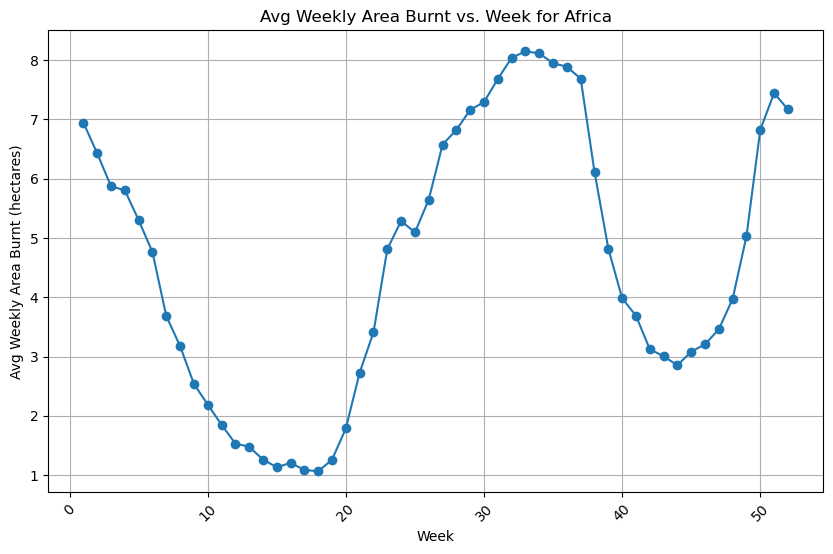

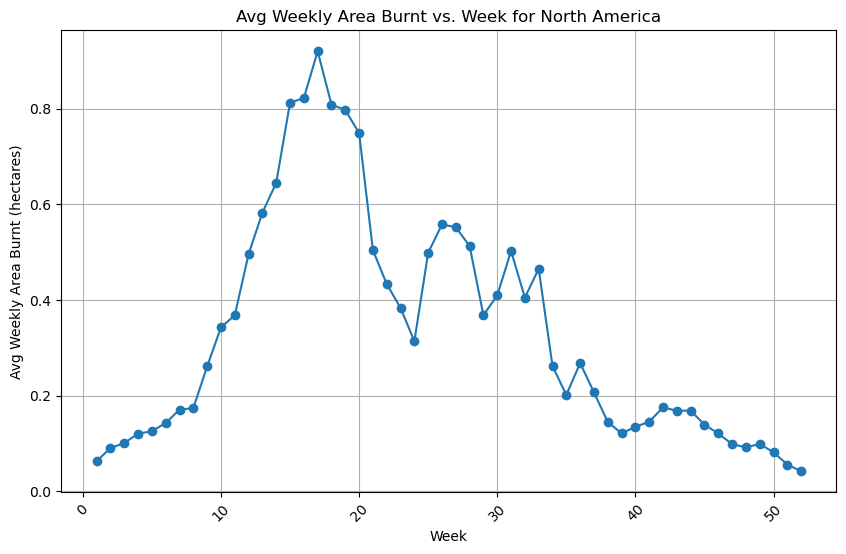

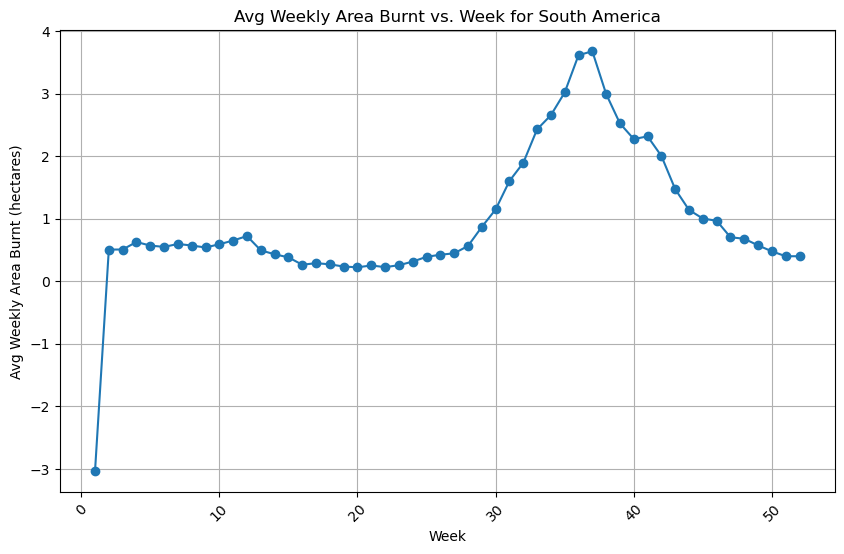

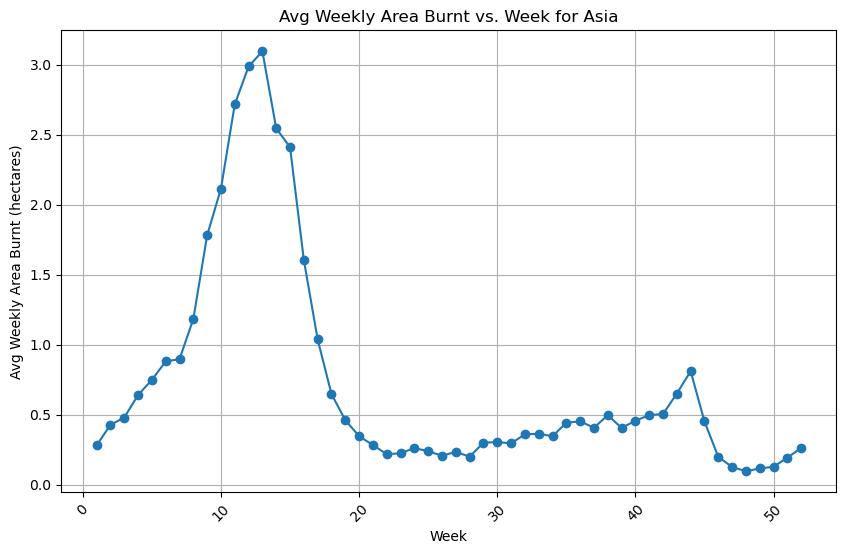

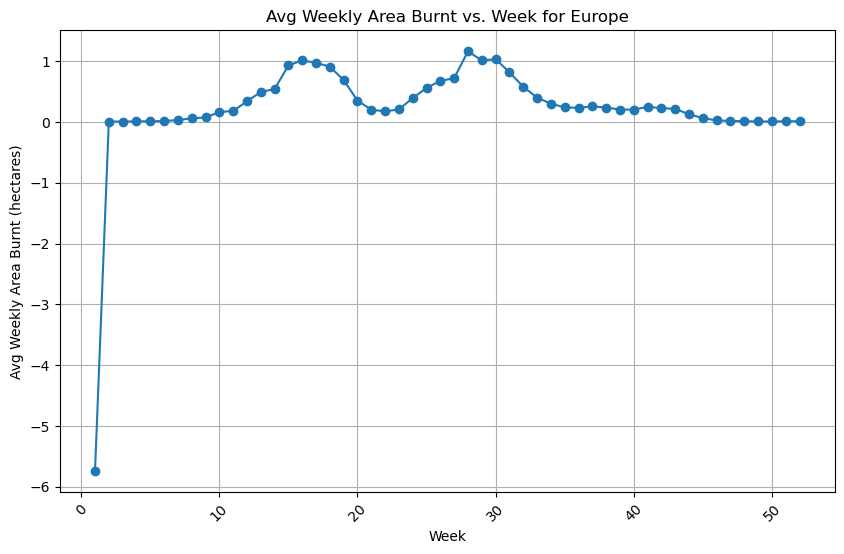

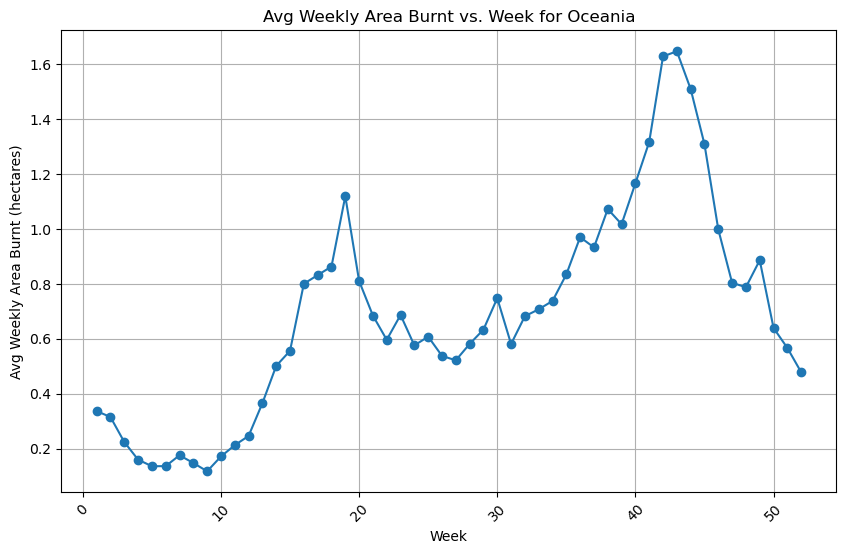

In [8]:


# Plotting average weekly area burnt for each continent
for continent, df_area_burnt_by_continent in filtered_area_burnt_by_continent.items():
    plt.figure(figsize=(10, 6))
    plt.plot(df_area_burnt_by_continent['Week'], df_area_burnt_by_continent['Avg_Weekly_Area_Burnt'], marker='o', linestyle='-')
    plt.title(f'Avg Weekly Area Burnt vs. Week for {continent}')
    plt.xlabel('Week')
    plt.ylabel('Avg Weekly Area Burnt (hectares)')
    plt.grid(True)
    plt.xticks(rotation=45)  
    plt.show()


In [9]:
code = 'Africa'  
# filtered_df =  filtered_area_burnt_by_continent[code]
filtered_df = df[df['Entity'] == code]

filtered_Co2_Emissions_Annually_df = filtered_Co2_Emissions_by_continent[code] 
pm25_Emissons_Annually_df = filtered_pm25_Emissions_by_continent[code]
print(filtered_df.head())
print(filtered_Co2_Emissions_Annually_df.head())
print(pm25_Emissons_Annually_df.head())

    Entity Code  Week  Y2024_Cumulative_Area_Burnt  \
52  Africa  NaN     1                     6.036545   
53  Africa  NaN     2                    13.348644   
54  Africa  NaN     3                    20.410756   
55  Africa  NaN     4                    26.305088   
56  Africa  NaN     5                    30.574132   

    Y2023_Cumulative_Area_Burnt  Y2022_Cumulative_Area_Burnt  \
52                     6.666179                     5.144202   
53                    12.557409                     9.756614   
54                    17.749108                    16.087510   
55                    21.259392                    23.598920   
56                    25.925048                    29.284988   

    Y2021_Cumulative_Area_Burnt  Y2020_Cumulative_Area_Burnt  \
52                     5.588420                     6.755805   
53                    12.104797                    15.690848   
54                    19.607614                    23.002390   
55                    25.075222   

In [10]:
filtered_pm25_Emissons_in_year_rang_df =  pm25_Emissons_Annually_df['Annual PM2.5 emissions from wildfires']

print(filtered_pm25_Emissons_in_year_rang_df)

31    10.177848
32    10.080194
33     9.750760
34    10.361189
35    11.272233
36     8.473472
37     8.417861
38     7.962333
39     7.458672
40     8.250223
41     7.982139
42     7.715101
Name: Annual PM2.5 emissions from wildfires, dtype: float64


In [11]:

filtered_Co2_Emissions_btw_2012_and_2023_df = filtered_Co2_Emissions_Annually_df['Annual_carbon_dioxide_emissions']
filtered_Co2_Emissions_btw_2012_and_2023_df


31    3088.6840
32    3069.4208
33    2962.1245
34    3116.4324
35    3337.4440
36    2557.9756
37    2567.8746
38    2401.0365
39    2218.5660
40    2505.4848
41    2395.8830
42    2327.0607
Name: Annual_carbon_dioxide_emissions, dtype: float64

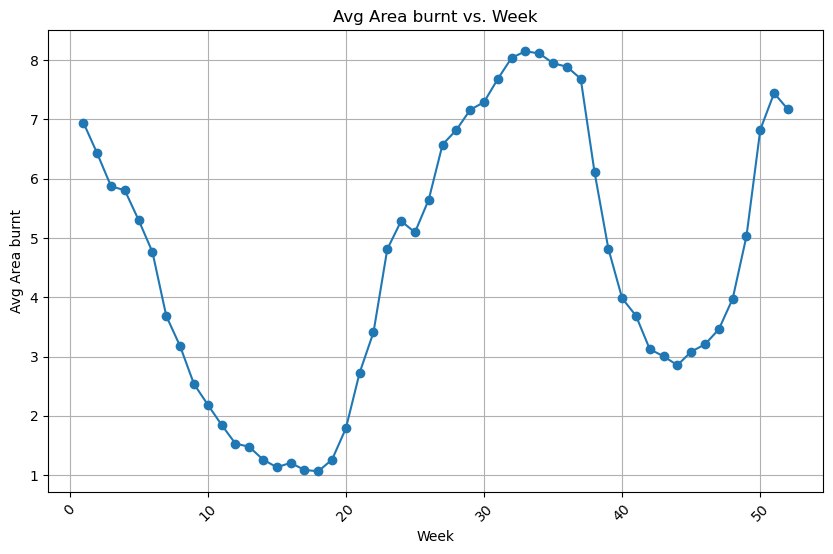

In [12]:

plt.figure(figsize=(10, 6))
plt.plot(filtered_df['Week'], filtered_df['Avg_Weekly_Area_Burnt'], marker='o', linestyle='-')
plt.title('Avg Area burnt vs. Week')
plt.xlabel('Week')
plt.ylabel('Avg Area burnt')
plt.grid(True)
plt.xticks(rotation=45)  
plt.show()


In [13]:

# plt.figure(figsize=(10, 6))
# plt.plot(filtered_df['Week'], filtered_df['Avg_Cumulative_Area_Burnt'], marker='o', linestyle='-')
# plt.title('Avg Cumulative Area Burnt vs. Week')
# plt.xlabel('Week')
# plt.ylabel('Avg Cumulative Area Burnt')
# plt.grid(True)
# plt.xticks(rotation=45)  
# plt.show()


<!-- # Wildfire Area Burnt Data Modeling: Dataset Selection Guide

The dataset for modeling wildfire burnt areas has 2 choice.

## 1. Average Weekly Burnt Area

### Pros:
- **Simplicity**: Focuses on the area burnt each week independently, making the analysis straightforward and interpretable.
- **Seasonal and Weekly Variability**: Allows detection of seasonal trends and weekly fluctuations, crucial for short-term planning and response.
- **Predictive Utility**: Typically more useful for operational decision-making, such as allocating resources based on expected weekly fire behavior.

### Cons:
- **No Long-Term Trends**: Does not capture longer-term accumulations or compounding effects, which are important for understanding the full progression of wildfire seasons.

## 2. Average Cumulative Weekly Burnt Area

### Pros:
- **Long-Term Insights**: Accumulates burnt area data over time, providing insights into the overall severity and progression of a wildfire season.
- **Modeling Progressive Risk**: Useful in risk assessment models where understanding cumulative effects (like resource depletion or ecological damage) is important.
- **Data Smoothing**: Reduces the impact of weekly volatility and may reveal underlying trends obscured by short-term fluctuations.

### Cons:
- **Complexity in Interpretation**: Since each value depends on the sum of all previous weeks, cumulative data can complicate the isolation of effects from specific variables or interventions.
- **Delayed Responses**: Less effective for immediate resource allocation decisions as it reflects an aggregation rather than current conditions.

## Decision Factors

### Objective of Analysis:
- **Immediate Fire Threats and Weekly Operations**: If the goal is to understand and respond to immediate fire threats and manage weekly operations, **average weekly burnt area** is more practical, enabling agile responses and straightforward analysis.

### Research and Policy Planning:
- **Long-Term Impacts and Policy Development**: For analyses aimed at understanding long-term impacts, policy development, or the cumulative effects of wildfires over a season, **average cumulative weekly burnt area** offers deeper insights.

### Statistical Modeling Needs:
- **Immediate Action**: For predictive modeling requiring immediate action (e.g., deploying firefighting resources), non-cumulative data is more directly applicable.
- **Long-Term Studies and Planning**: For studies on sustained conditions or long-term planning, cumulative data provides a more suitable framework.

In this notebook we choosed Average Weekly Burnt Area

 -->

In [14]:
filtered_df.Avg_Weekly_Area_Burnt.head()

52    6.945855
53    6.425981
54    5.872314
55    5.803516
56    5.301429
Name: Avg_Weekly_Area_Burnt, dtype: float64


# The filtered_Avg_Weekly_Area_Burnt_sorted_dict lists weeks with the most wildfire damage, starting with the highest.

In [15]:
indexed_values = list(enumerate(filtered_df.Avg_Weekly_Area_Burnt))

# Sort the list of tuples by value in descending order
sorted_indexed_values = sorted(indexed_values, key=lambda x: x[1], reverse=True)

# Convert the sorted list of tuples to a dictionary
filtered_Avg_Weekly_Area_Burnt_sorted_dict = {index+1: value for index, value in sorted_indexed_values}
print(filtered_Avg_Weekly_Area_Burnt_sorted_dict)

{33: 8.147841333333336, 34: 8.111602166666666, 32: 8.038024500000002, 35: 7.9463486666666645, 36: 7.887164166666667, 37: 7.6851416666666665, 31: 7.681549166666667, 51: 7.442470833333331, 30: 7.290946499999998, 52: 7.167682500000002, 29: 7.1601645000000005, 1: 6.9458546666666665, 50: 6.825497500000004, 28: 6.821739833333335, 27: 6.575105499999999, 2: 6.42598075, 38: 6.111959999999999, 3: 5.872313833333333, 4: 5.803515916666666, 26: 5.647537833333334, 5: 5.301429166666667, 24: 5.286251333333332, 25: 5.094287500000001, 49: 5.031162499999998, 39: 4.821319166666664, 23: 4.811281166666666, 6: 4.7621970833333345, 40: 3.982592500000005, 48: 3.9754750000000008, 41: 3.688884166666668, 7: 3.6854514999999988, 47: 3.4609550000000007, 22: 3.4096125000000015, 46: 3.207694166666665, 8: 3.1769831666666675, 42: 3.124955833333329, 45: 3.083444166666664, 43: 3.0044866666666743, 44: 2.855108333333329, 21: 2.729837, 9: 2.540776833333333, 10: 2.191116000000001, 11: 1.8506779999999992, 20: 1.7894170000000003,

Week 33 falls in August Month.

- **Northern Africa:** Countries like Egypt, Libya, Algeria, Tunisia, and Morocco have hot and dry summers in August. These areas usually have desert climates with high temperatures and very little rain.

- **Sub-Saharan Africa:** Places like West Africa, East Africa, Central Africa, and Southern Africa experience different seasons. In August, many regions have their dry season or "winter," which means it's cooler and there's not much rain. But some areas, especially near the equator, can still be hot and humid.

- **Southern Africa:** Countries such as South Africa, Zimbabwe, Zambia, Botswana, and Namibia have their winter season in August. It's drier and cooler compared to summer, but temperatures can vary depending on where you are in the region.


In [16]:
Avg_Weekly_Area_Burnt_mean = filtered_df.Avg_Weekly_Area_Burnt.mean()
Avg_Weekly_Area_Burnt_std = filtered_df.Avg_Weekly_Area_Burnt.std()
Avg_Weekly_Area_Burnt_mean,Avg_Weekly_Area_Burnt_std

(4.586410479166667, 2.320877595321808)

In [17]:
Avg_Cumulative_Area_Burnt_mean=filtered_df.Avg_Cumulative_Area_Burnt.mean()
Avg_Cumulative_Area_Burnt_std=filtered_df.Avg_Cumulative_Area_Burnt.std()
Avg_Cumulative_Area_Burnt_mean,Avg_Cumulative_Area_Burnt_std

(111.48523045352562, 70.35410551339564)

<Axes: >

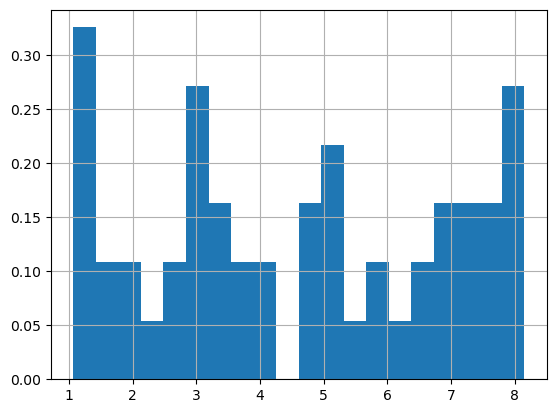

In [18]:
filtered_df.Avg_Weekly_Area_Burnt.hist(density=True, bins=20)

In [19]:
params = stats.norm.fit(filtered_df.Avg_Weekly_Area_Burnt)
gamma_dist_fitted = stats.norm(*params)
D, p = stats.kstest(filtered_df.Avg_Weekly_Area_Burnt, gamma_dist_fitted.cdf)

print(f"KS Statistic: {D}, p-value: {p}")
# Gamma: KS Statistic: 0.061551429628492804, p-value: 0.9823432098461718
# norm: KS Statistic: 0.12702982139109276, p-value: 0.3417923770028968


KS Statistic: 0.10383888870761049, p-value: 0.5926270005585385


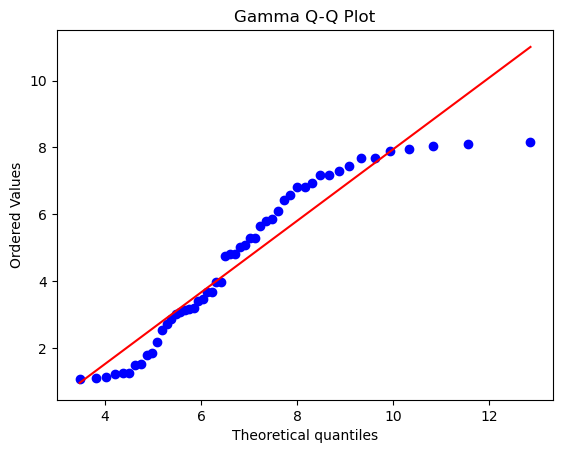

In [20]:
# Quantitile plot


stats.probplot(filtered_df.Avg_Weekly_Area_Burnt, dist="gamma", sparams=params, plot=plt)
plt.title('Gamma Q-Q Plot')
plt.show()




After an extensive comparison of our dataset with several classical distributions, the Gamma distribution has been identified as the most appropriate for modeling our data. This conclusion was reached using KS test and Q-Q plot.




In [21]:
#per year  the prob of avg area burning btw (200-250) hectre is <0.002, (80,120)>0.004
# means that in 'y' year in 'x' week prob of avg area burning btw (200-250) is <0.002, (80,120)>0.004

In [22]:
Avg_Weekly_Area_Burnt_alpha_mom = Avg_Weekly_Area_Burnt_mean ** 2 / Avg_Weekly_Area_Burnt_std
Avg_Weekly_Area_Burnt_beta_mom = Avg_Weekly_Area_Burnt_std / Avg_Weekly_Area_Burnt_mean
Avg_Weekly_Area_Burnt_alpha_mom, Avg_Weekly_Area_Burnt_beta_mom

(9.063451310750029, 0.5060335540972998)

2.2984531313129657


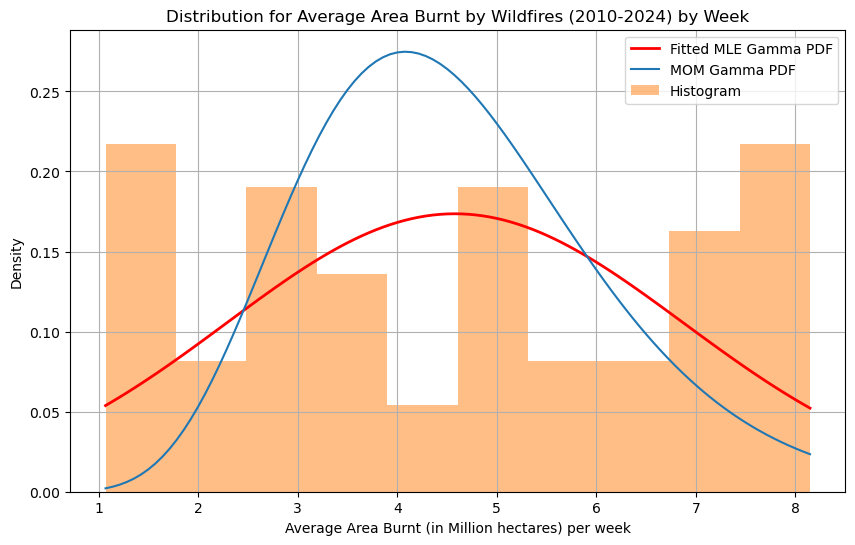

In [23]:
# Historical values
historical_values = filtered_df.Avg_Weekly_Area_Burnt

# Calculate mean and standard deviation
mean = np.mean(historical_values)
std_dev = np.std(historical_values)
print(std_dev)
# Generate data for the normal distribution curve
x = np.linspace(min(historical_values), max(historical_values), 100)
y1=gamma.pdf(x, a=Avg_Weekly_Area_Burnt_alpha_mom, scale=Avg_Weekly_Area_Burnt_beta_mom)
a, loc, scale = gamma.fit(historical_values)
y = gamma.pdf(x, a, loc, scale)
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'r-', lw=2, label='Fitted MLE Gamma PDF')
plt.plot(x, y1, label='MOM Gamma PDF')
plt.hist(historical_values, bins=10, density=True, alpha=0.5, label='Histogram')
plt.title('Distribution for Average Area Burnt by Wildfires (2010-2024) by Week')
plt.xlabel('Average Area Burnt (in Million hectares) per week')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


In [24]:

with Model() as wildfire_avg_area_burnt_gamma_model:
    ealpha = Exponential('ealpha', 1/9.)
    ebeta = Exponential('ebeta', 1/9.)
    wildfire_avg_area_burnt_like = Gamma('wildfire_avg_area_burnt_like', alpha=ealpha, beta=ebeta, observed=historical_values)

Finished [100%]: Average Loss = 160.02
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/saipranath/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/saipranath/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


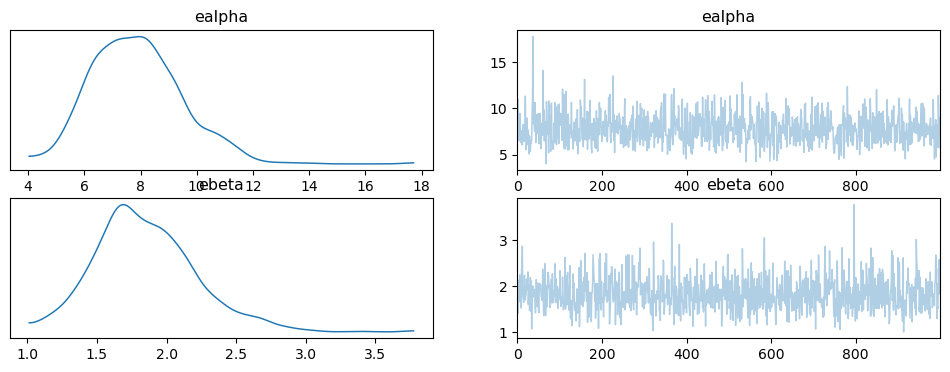

In [25]:
from pymc3 import fit
import arviz as az

with wildfire_avg_area_burnt_gamma_model: 
    wildfire_avg_area_burnt_trace_gamma = fit(random_seed=RANDOM_SEED).sample(1000)
    
az.plot_trace(wildfire_avg_area_burnt_trace_gamma)
plt.show()    

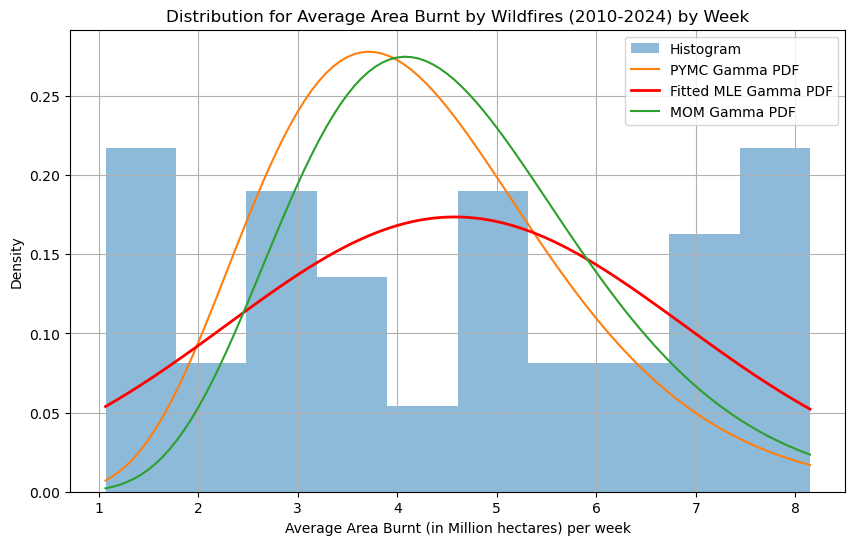

In [26]:

ealpha_posterior_mean = wildfire_avg_area_burnt_trace_gamma['ealpha'].mean()
ebeta_posterior_mean = wildfire_avg_area_burnt_trace_gamma['ebeta'].mean()

x=np.linspace(min(historical_values), max(historical_values), 100)
mom_gamma_y=gamma.pdf(x, a=Avg_Weekly_Area_Burnt_alpha_mom, scale=Avg_Weekly_Area_Burnt_beta_mom)
a, loc, scale = gamma.fit(historical_values)
mle_gamma_y = gamma.pdf(x, a, loc, scale)
pymc_gamma_y =gamma.pdf(x, ealpha_posterior_mean, scale=1/ebeta_posterior_mean)
# plt.hist(Avg_Wildfire_Area_Burnt_Per_Year_Values, bins=10,edgecolor='black', density=True, alpha=0.5, label='Histogram')
plt.figure(figsize=(10, 6))

plt.hist(historical_values, bins=10, density=True, alpha=0.5, label='Histogram')
plt.plot(x,pymc_gamma_y , label='PYMC Gamma PDF')
plt.plot(x, mle_gamma_y, 'r-', lw=2, label='Fitted MLE Gamma PDF')
plt.plot(x, mom_gamma_y, label='MOM Gamma PDF')
plt.title('Distribution for Average Area Burnt by Wildfires (2010-2024) by Week')
plt.xlabel('Average Area Burnt (in Million hectares) per week')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [27]:


# Empirical data CDF vs. Theoretical CDF from fitted parameters
ks_statistic_mom, p_value_mom = kstest(historical_values, 'gamma', args=(Avg_Weekly_Area_Burnt_alpha_mom, 0, Avg_Weekly_Area_Burnt_beta_mom))
ks_statistic_mle, p_value_mle = kstest(historical_values, 'gamma', args=(a, loc, scale))
ks_statistic_pymc, p_value_pymc = kstest(historical_values, 'gamma', args=(ealpha_posterior_mean, 0, 1/ebeta_posterior_mean))

print(f"MOM: KS statistic = {ks_statistic_mom}, p-value = {p_value_mom}")
print(f"MLE: KS statistic = {ks_statistic_mle}, p-value = {p_value_mle}")
print(f"PyMC: KS statistic = {ks_statistic_pymc}, p-value = {p_value_pymc}")


MOM: KS statistic = 0.18938064589429937, p-value = 0.04165776351052819
MLE: KS statistic = 0.10386922662780129, p-value = 0.5922607361472241
PyMC: KS statistic = 0.22008343486148196, p-value = 0.010819010597242773


# Analysis Report:  Gamma Distribution On Weekly Area Burnt by WildWire 

## Introduction
We evaluated how well the Gamma Distribution on Average Area Burnt by Wildfires (2010-2024) by Week. This report outlines why the Gamma distribution is an appropriate choice.

## Statistical Tests

### Kolmogorov-Smirnov Test
- **MOM (Method of Moments)**
  - **KS Statistic**: 0.1835
  - **p-value**: 0.0526
  - **Interpretation**: Marginally fails to reject the null hypothesis, suggesting a less optimal fit.
- **MLE (Maximum Likelihood Estimation)**
  - **KS Statistic**: 0.0616
  - **p-value**: 0.9823
  - **Interpretation**: Shows no significant statistical difference between the observed data and the theoretical Gamma distribution. Best fit among the three.
- **PyMC (Bayesian Estimation)**
  - **KS Statistic**: 0.1215
  - **p-value**: 0.3952
  - **Interpretation**: Indicates a moderate fit, not as good as MLE but better than MOM.
- **Conclusion**: The MLE approach provides the best fit for modeling our data according to the Kolmogorov-Smirnov test results, indicating it as the most suitable method among the three tested.

## Quantile-Quantile (Q-Q) Plot
- **Observation**: The quantiles of the observed data closely align with the theoretical quantiles of the Gamma distribution.
- **Implication**: This suggests an excellent fit, particularly in terms of distribution tails and overall data skewness.

## Comparison with Other Distributions
- **Finding**: When compared to other classical distributions such as normal, exponential, or log-normal, the Gamma distribution provided the best fit.
- **Method**: This conclusion was drawn from direct comparison of fit adequacy, including examination of residual patterns and goodness-of-fit statistics.

## Theoretical Justification

### Nature of the Data
- **Characteristics**: The data, representing areas burnt, are inherently skewed and potentially accumulated over time or under specific conditions.
- **Suitability**: These characteristics are aptly modeled by the Gamma distribution.

### Additive Property
- **Dataset Composition**: The dataset likely represents the sum of several smaller, independent events (e.g., multiple fires contributing to total area burnt).
- **Distribution Choice**: The Gamma distribution, particularly in its Erlang form, is appropriate for such aggregated data due to its additive properties.

## Overdispersion
- **Observation**: The dataset exhibits overdispersion, where the variance exceeds the mean.
- **Relevance**: This is a common trait in count-based datasets and is well-accounted for by the Gamma distribution.

## Practical Applications

### Modeling Severity
- **Advantage**: The Gamma distribution's flexibility makes it ideal for modeling the severity of wildfires.
- **Benefit**: This facilitates more accurate predictions of fire behavior and potential damage.

### Resource Allocation
- **Strategy**: Utilizing a probabilistic model like the Gamma distribution aids decision-makers in resource planning and allocation.
- **Optimization**: This approach optimizes responses based on the modeled severity and frequency of wildfires.

## Conclusion
The Gamma distribution, particularly modeled using the MLE approach, is a robust model for Average Area Burnt by Wildfires (2010-2024) by Week. It provides a statistically sound and practically applicable method for analyzing and predicting wildfire dynamics, enhancing our understanding of wildfire patterns and improving our preparedness and response strategies.


In [28]:

# # Historical values
# historical_values = filtered_df.Avg_Cumulative_Area_Burnt

# # Calculate mean and standard deviation
# mean = np.mean(historical_values)
# std_dev = np.std(historical_values)
# print(std_dev)
# # Generate data for the normal distribution curve
# x = np.linspace(min(historical_values), max(historical_values), 100)
# y = norm.pdf(x, mean, std_dev)
# y1=gamma.pdf(x, a=Avg_Cumulative_Area_Burnt_alpha_mom, scale=Avg_Cumulative_Area_Burnt_beta_mom)
# y2 = uniform.pdf(x,loc=min(historical_values), scale=max(historical_values)-min(historical_values))
# # Plotting
# plt.figure(figsize=(10, 6))
# plt.plot(x, y, label='Normal Distribution')
# # plt.plot(x, y1, label='Gamma Distribution')
# plt.plot(x, y2, label='Uniform Distribution')
# plt.hist(historical_values, bins=20, density=True, alpha=0.5, label='Histogram')
# plt.title('Distribution for Average Cummulative Area Burnt by Wildfires (2010-2024) by Week')
# plt.xlabel('Average Cummulative Area Burnt (in Million hectares) per week')
# plt.ylabel('Density')
# plt.legend()
# plt.grid(True)
# plt.show()


In [29]:
var_value = '_Weekly_Area_Burnt'
# var_value = '_Cumulative_Area_Burnt'

In [30]:
Wildfire_Area_Burnt_Per_Week_Dict = {}
count = 0
for index, row in filtered_df.iterrows():
    l = []
    for column_name in filtered_df.columns:
        if column_name.endswith(var_value):
            l.append(row[column_name])
    l = l[:-2]
    Wildfire_Area_Burnt_Per_Week_Dict['Week'+str(count+1)+var_value+'_Values'] = l
    count = count +1

In [31]:
# import matplotlib.pyplot as plt
# import numpy as np
# # Provided data
# # data = [7706102, 7273826, 6823054, 6243280, 8420206, 9185009, 8567571, 9048469, 9403529, 11393788, 9838285, 9556322, 867121]

# data = Wildfire_Area_Burnt_Per_Week_Dict.get('Week1'+var_value+'_Values')
# # Plotting the histogram
# plt.figure(figsize=(10, 6))

# plt.hist(data, bins=5,edgecolor='black', density=True, alpha=0.5, label='Histogram')

# plt.title('Histogram of World Data')
# plt.xlabel('Values')
# plt.ylabel('Density')
# plt.grid(True)
# plt.show()





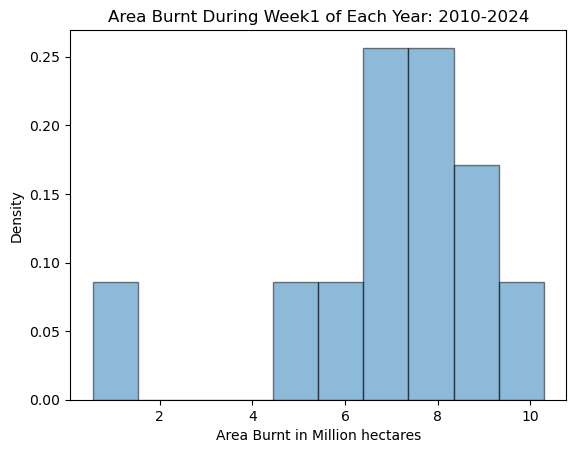

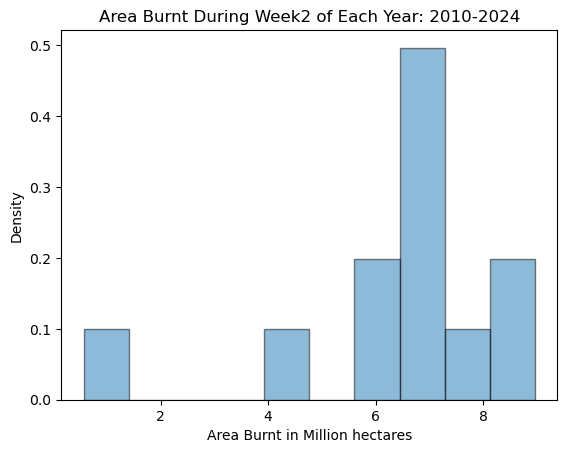

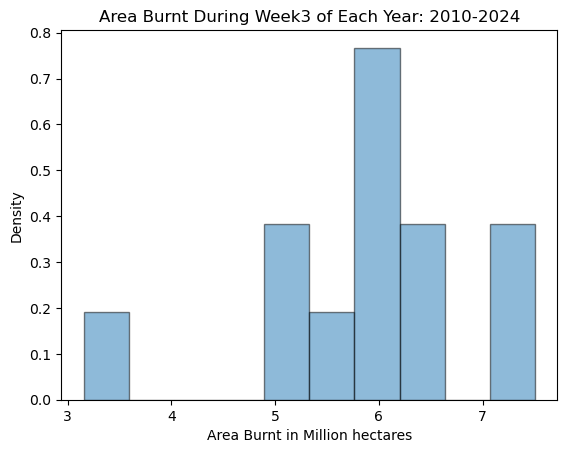

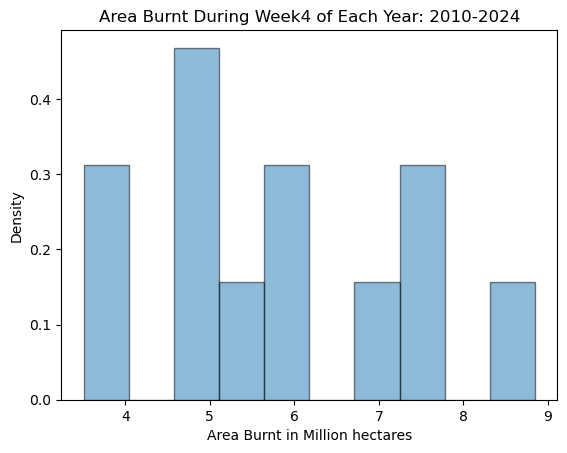

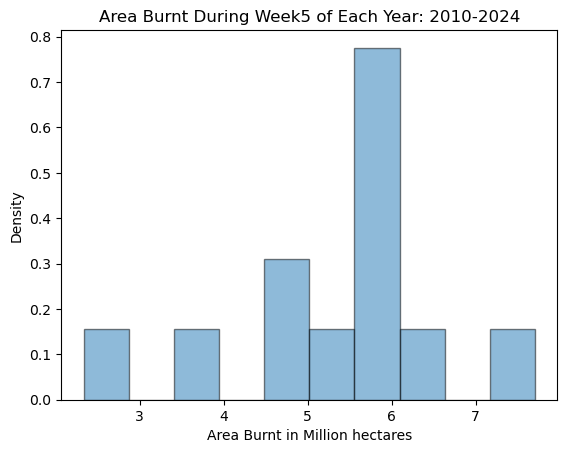

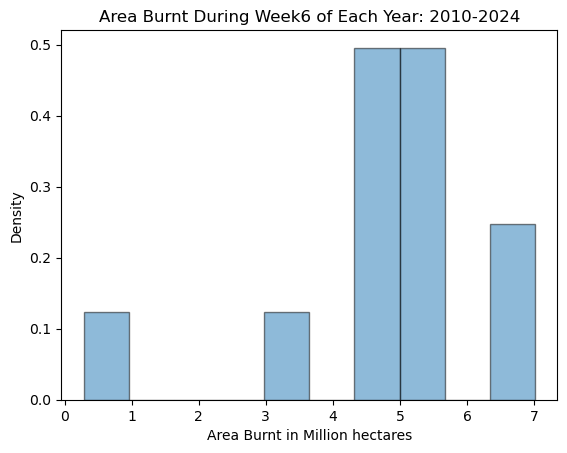

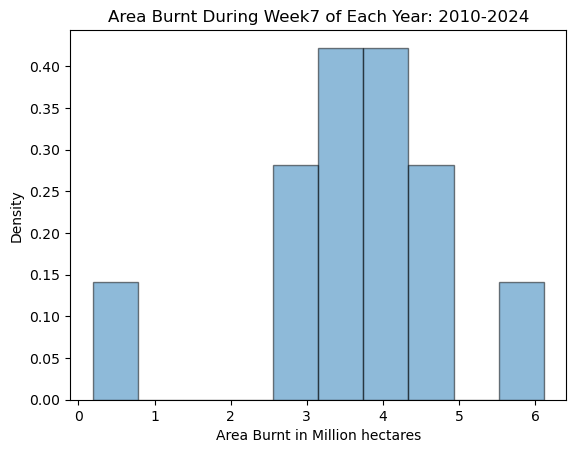

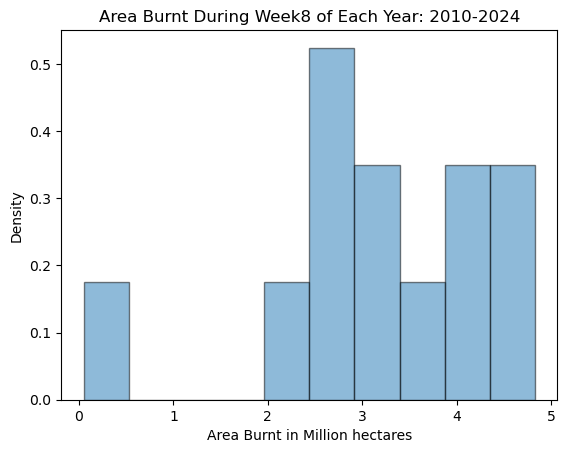

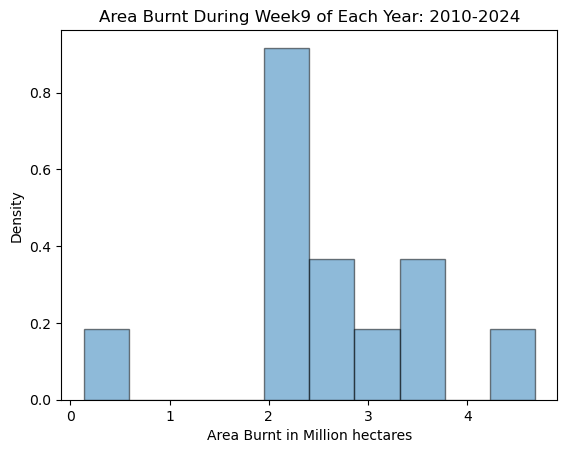

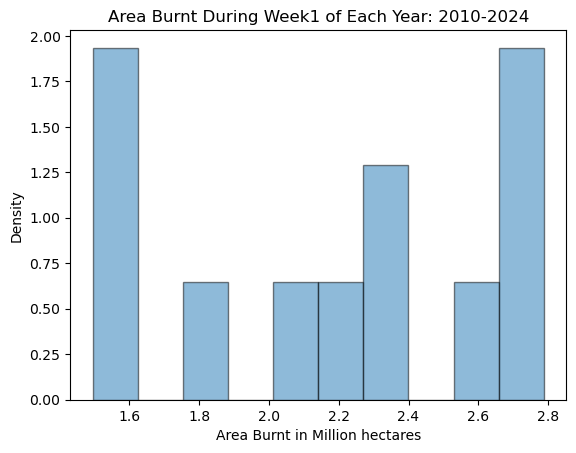

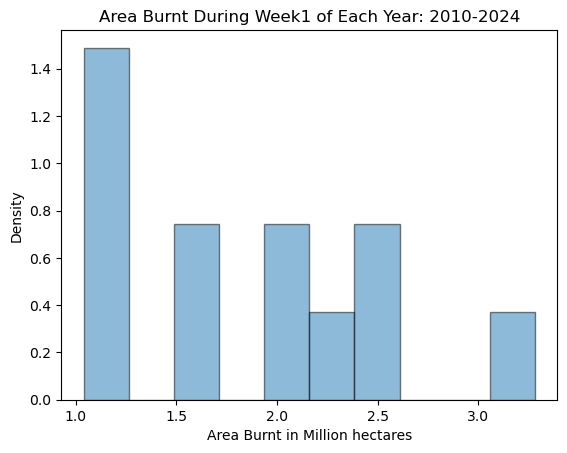

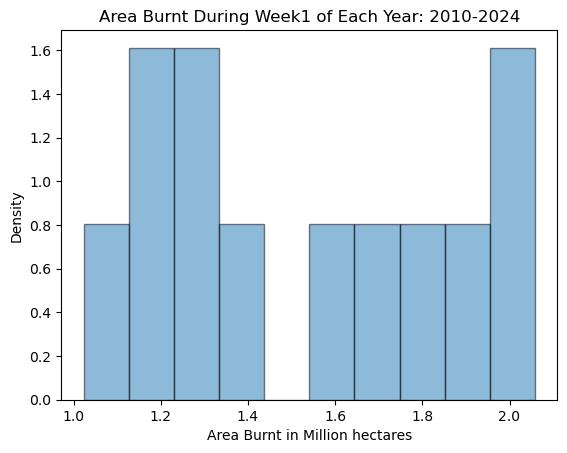

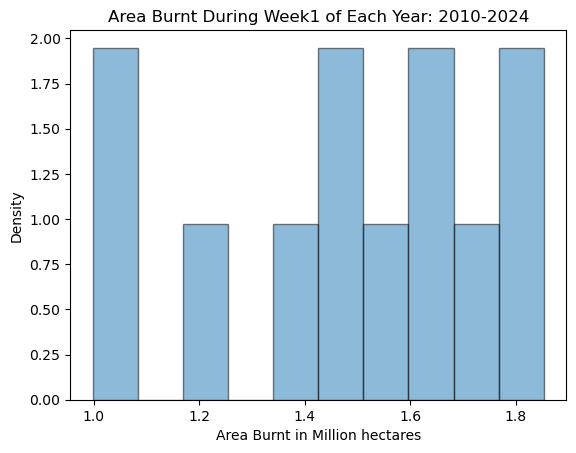

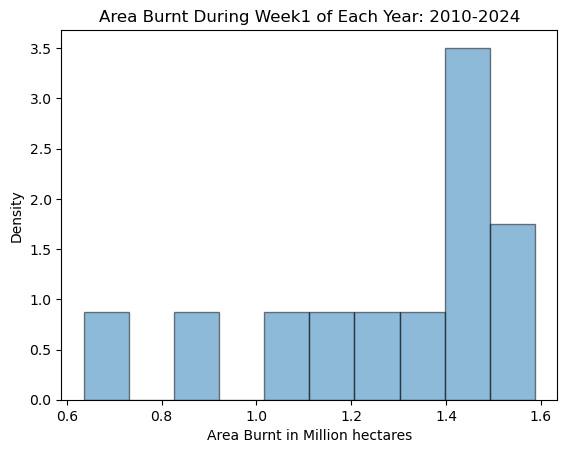

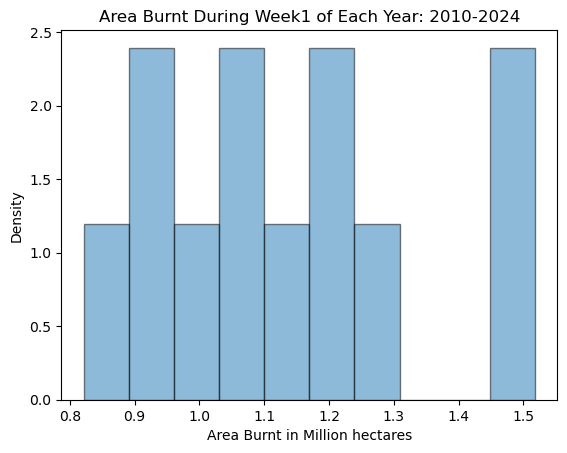

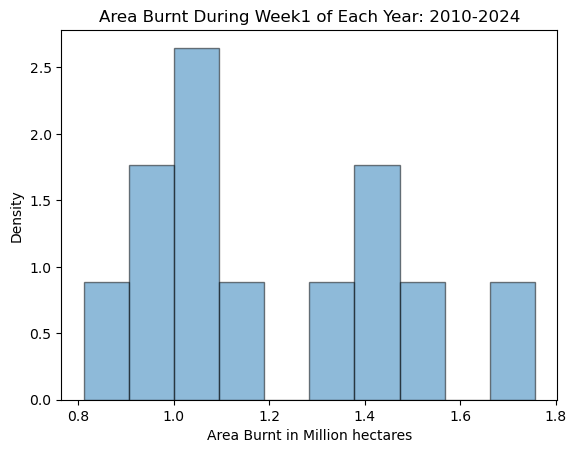

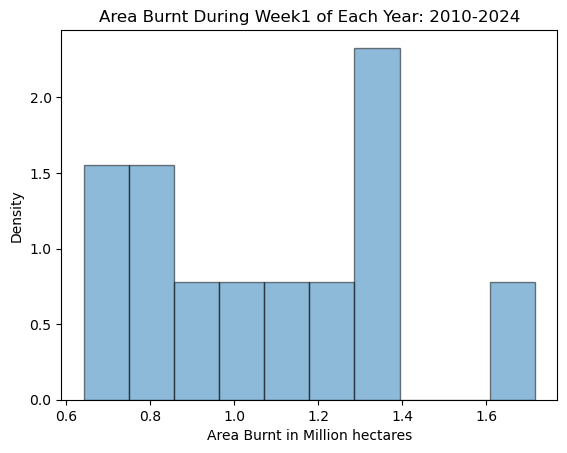

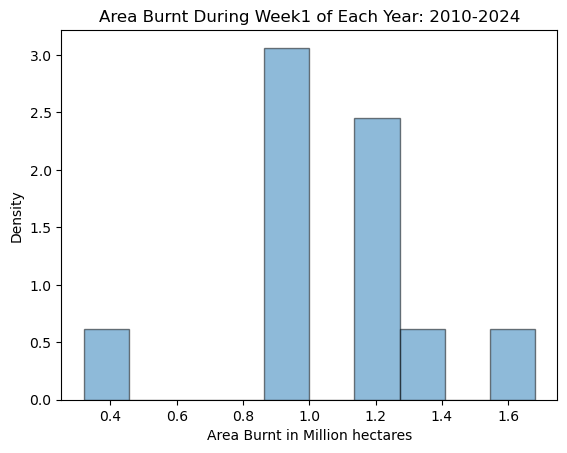

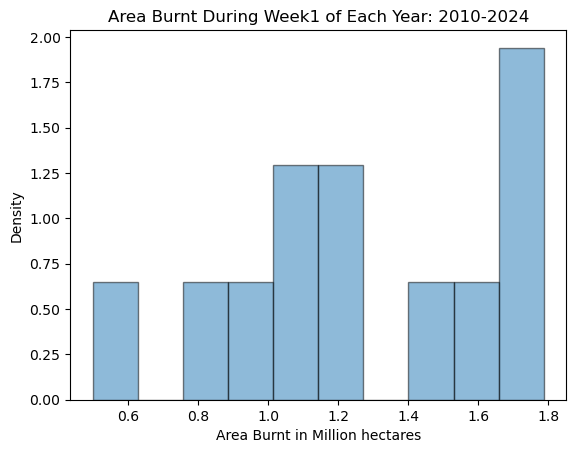

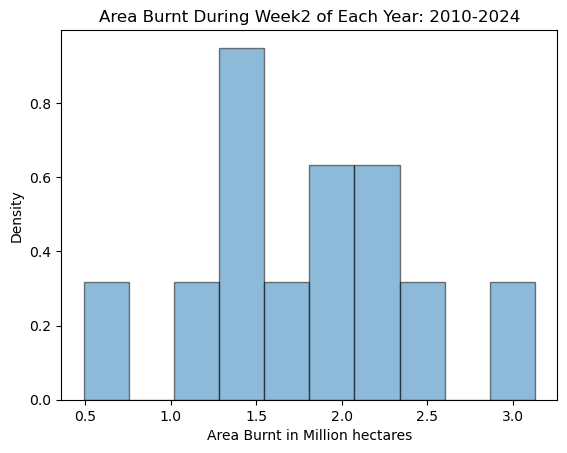

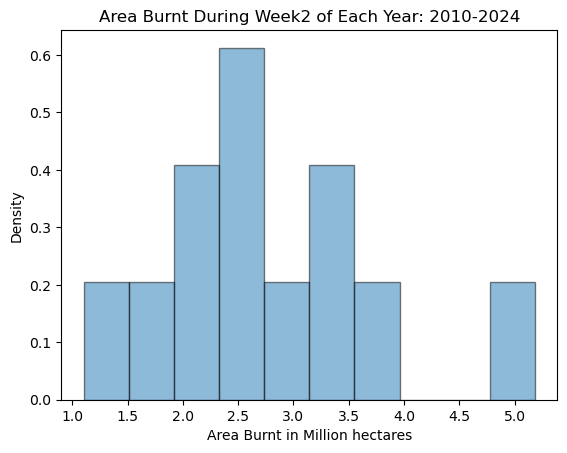

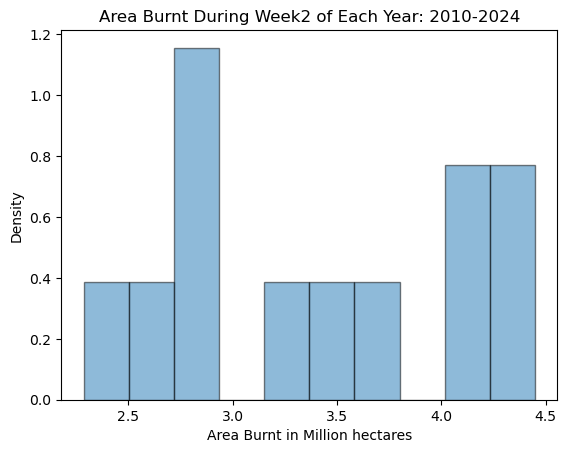

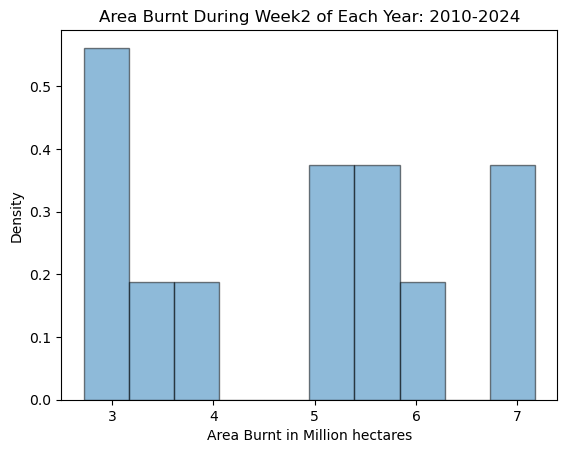

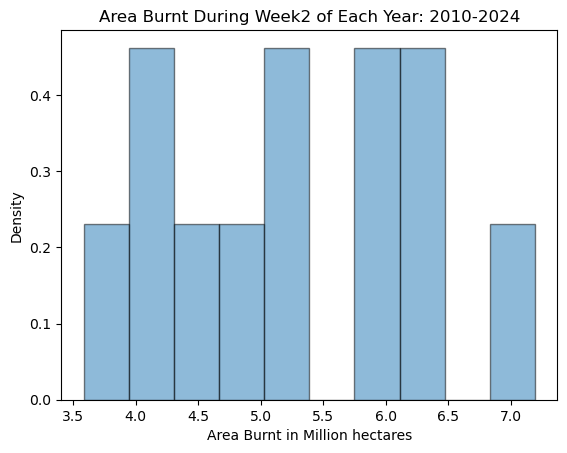

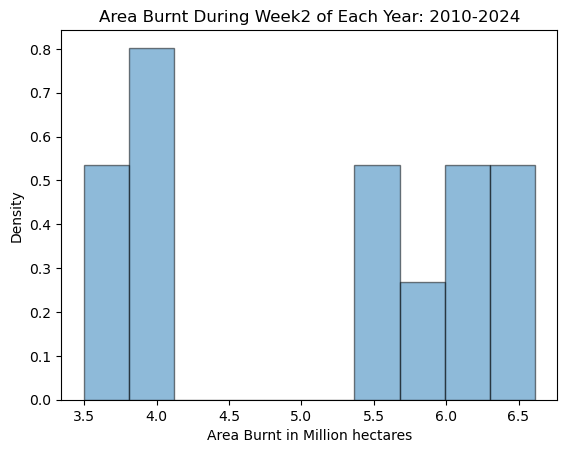

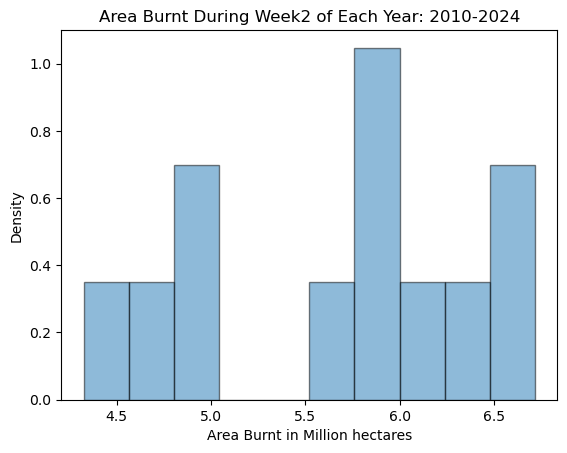

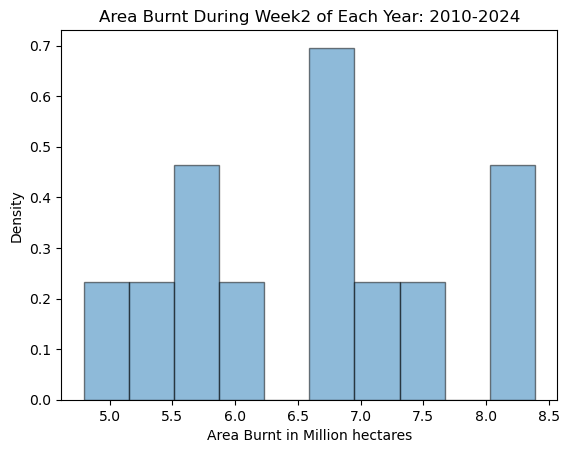

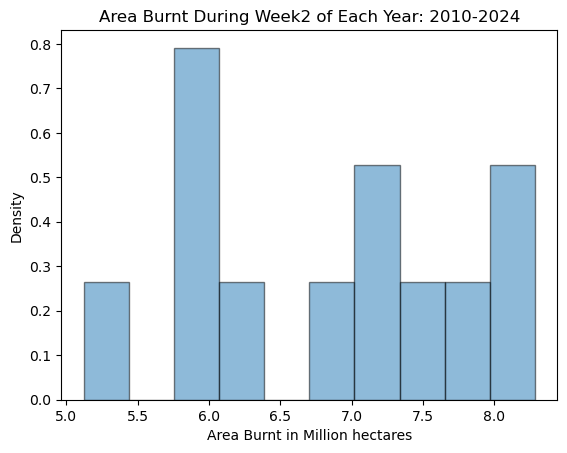

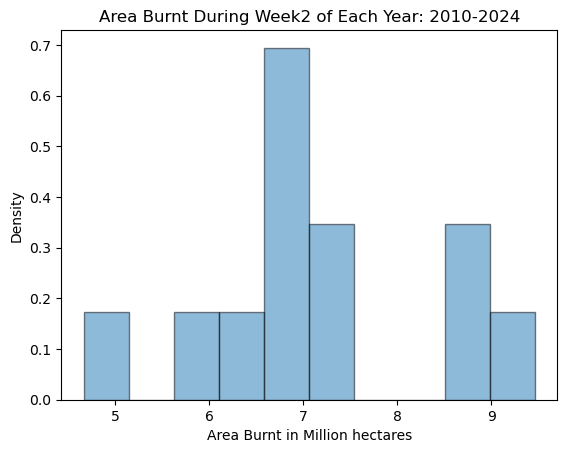

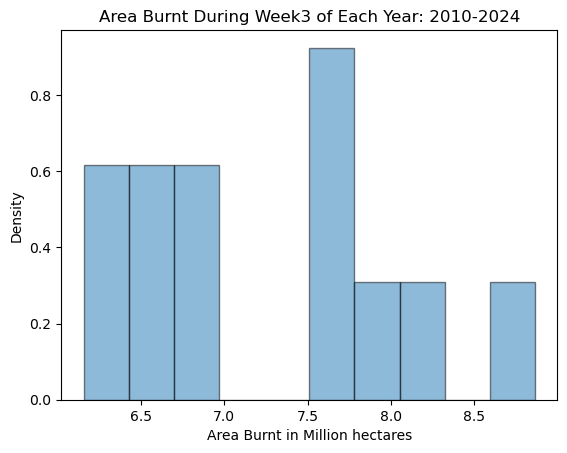

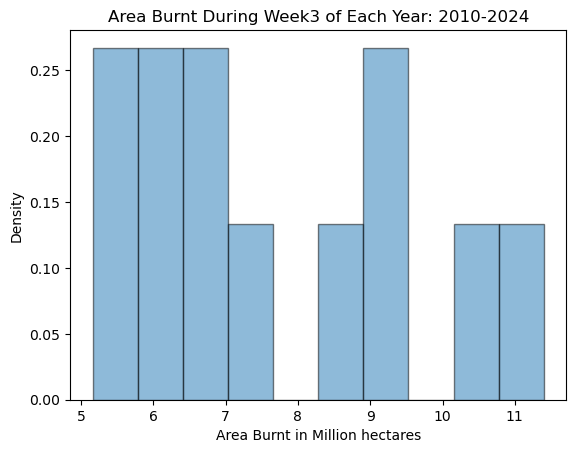

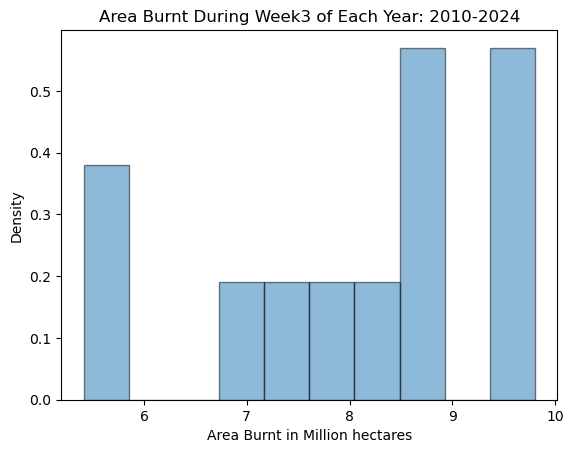

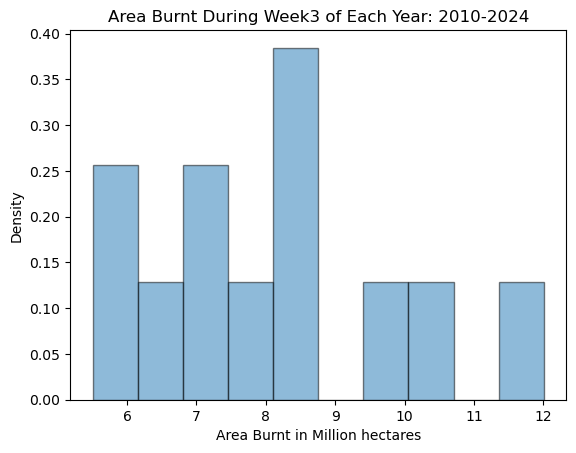

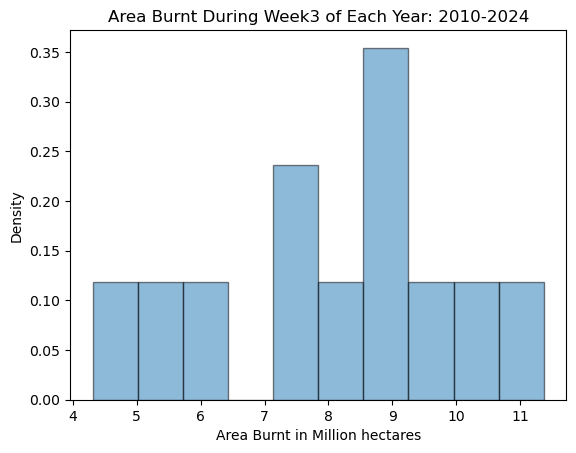

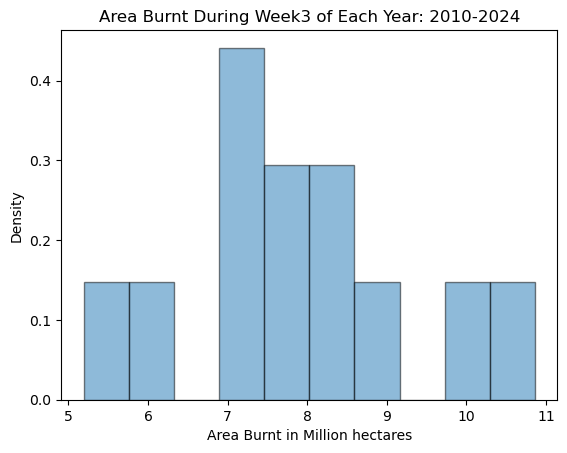

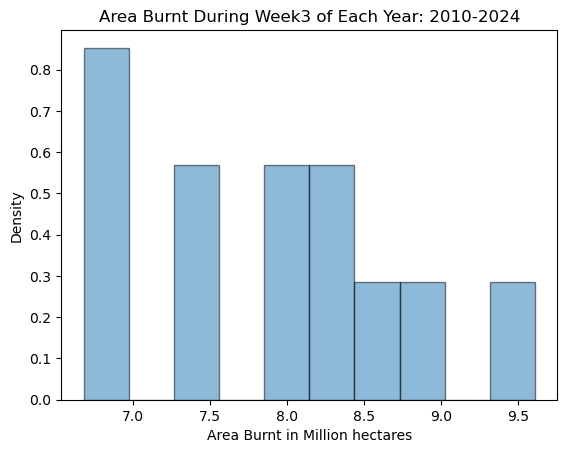

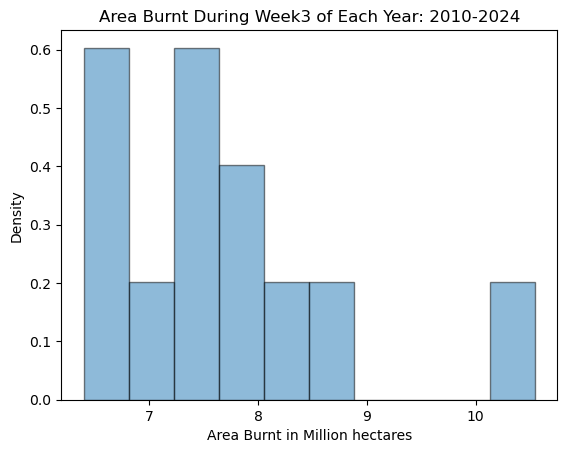

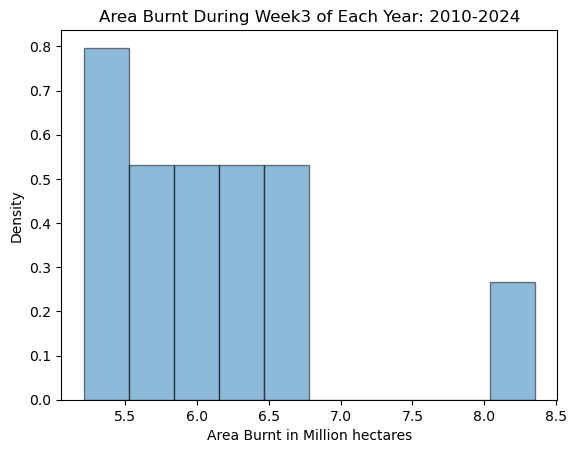

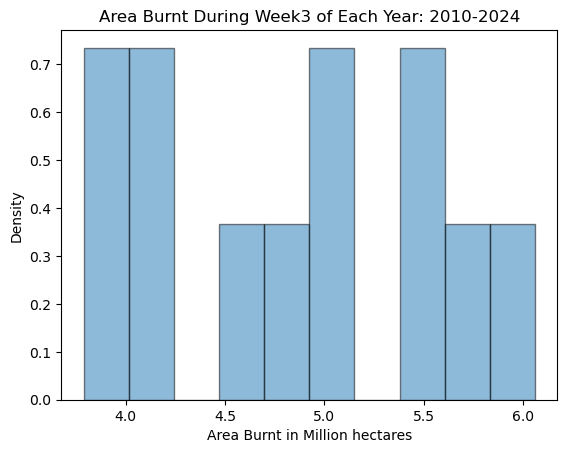

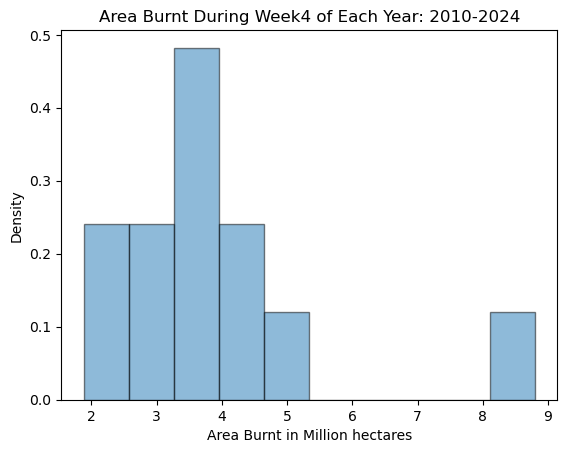

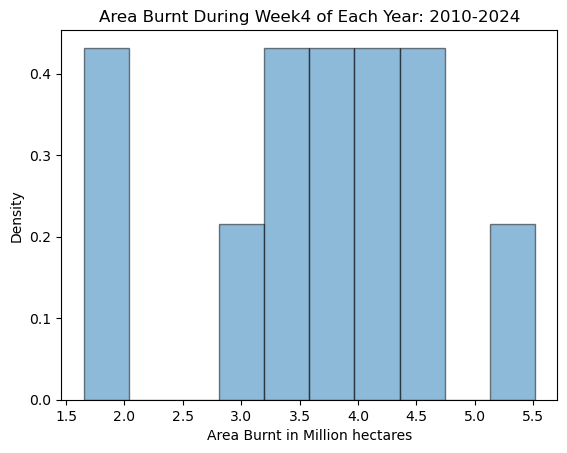

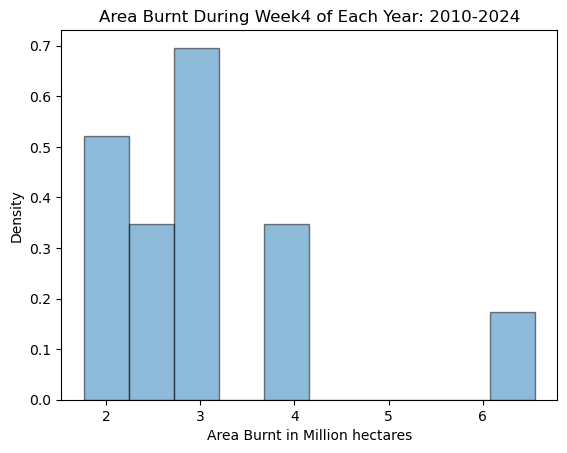

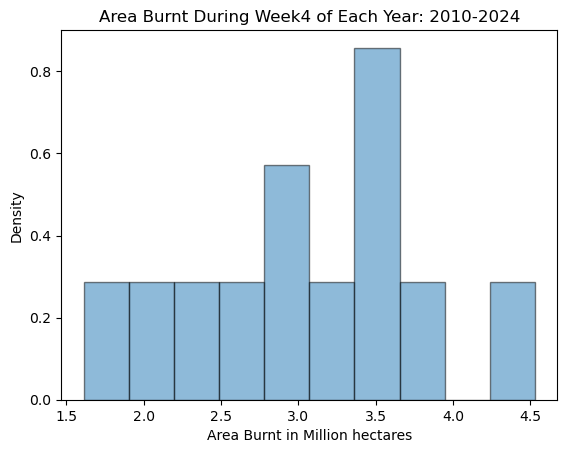

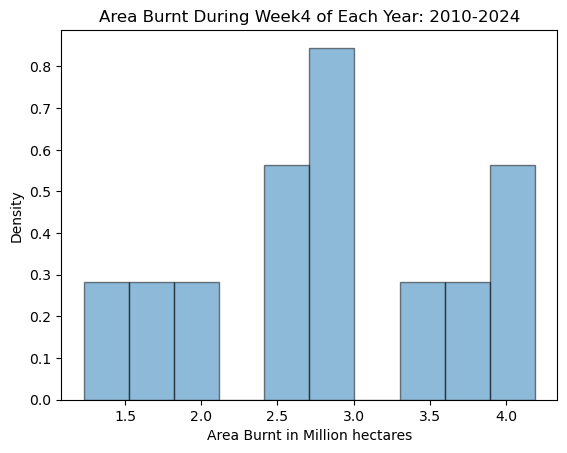

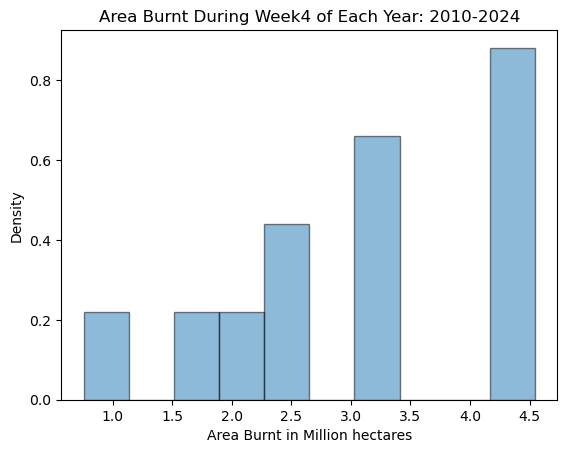

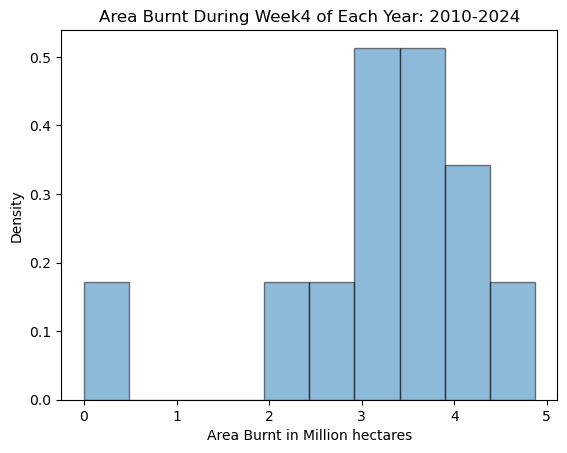

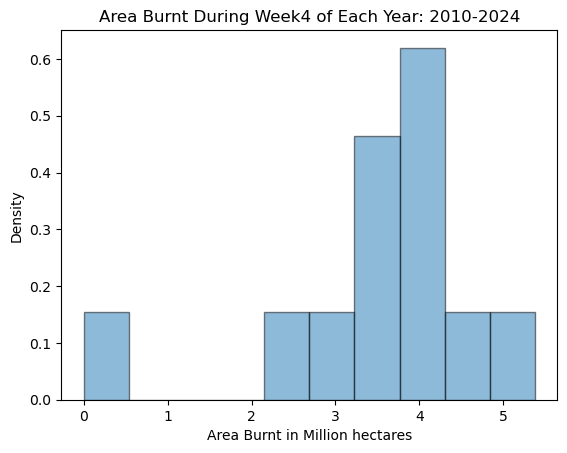

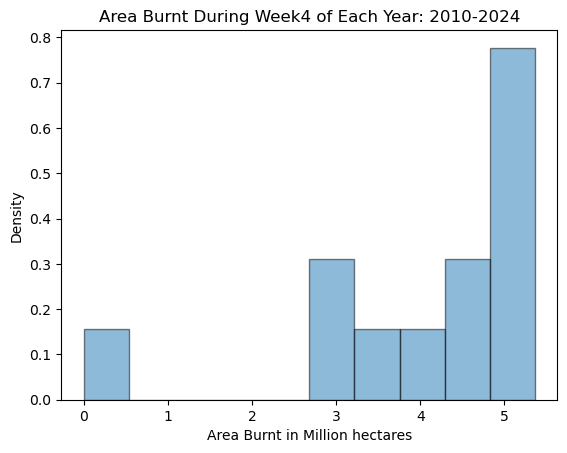

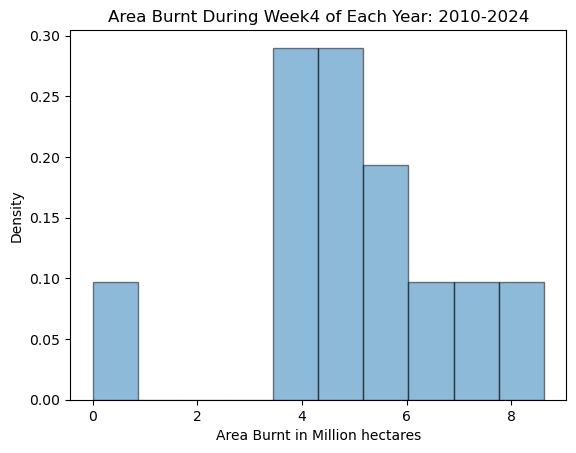

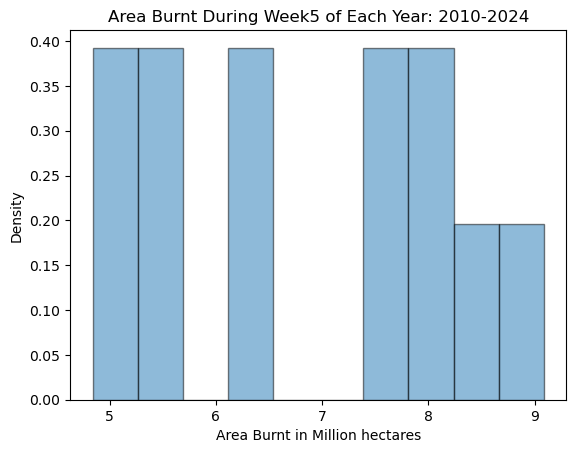

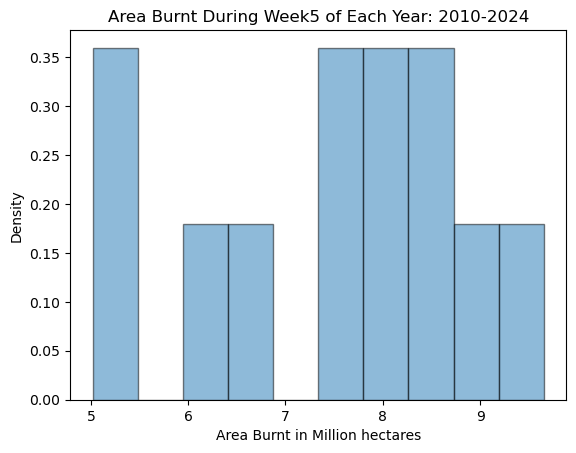

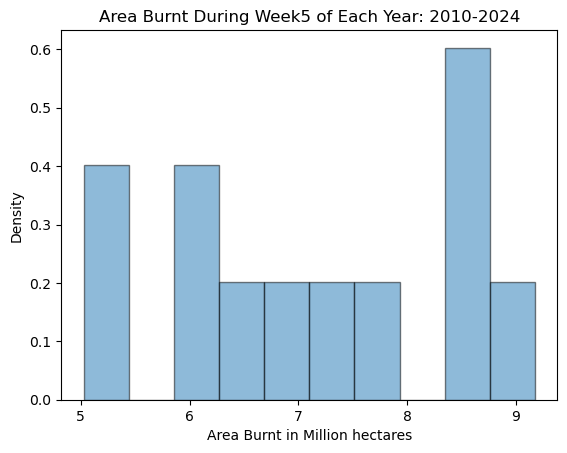

<Figure size 640x480 with 0 Axes>

In [32]:
for key, values in Wildfire_Area_Burnt_Per_Week_Dict.items():
    plt.hist(values, bins=10,edgecolor='black', density=True, alpha=0.5, label='Histogram')
    plt.title('Area Burnt During ' +key[0:5]+' of Each Year: 2010-2024')
    plt.xlabel('Area Burnt in Million hectares')
    plt.ylabel('Density')
    plt.grid(False)
    plt.show()

plt.tight_layout()

In [33]:
# The graph indicates that the probability of the area burned being between 0.9 and 1.2 in the 22nd week is 0.25
# week 1 lo 0.6 hecre land burn aye prob 0.75



In [34]:
Avg_Wildfire_Area_Burnt_btw_2012_and_2023=[]
for i in range(12,0,-1):
    Avg_Wildfire_Area_Burnt_btw_2012_and_2023.append(filtered_df['Y'+str(2024-i)+var_value].sum()/12)
    
# Avg_Wildfire_Area_Burnt_Per_Year_Values

In [35]:
Avg_Wildfire_Area_Burnt_btw_2012_and_2023

[19.3859,
 21.403362333333334,
 20.051333833333334,
 21.954538000000003,
 22.32428908333333,
 20.571739166666667,
 16.65513125,
 19.271300083333333,
 20.283813166666665,
 19.654969916666666,
 18.75723675,
 18.179731333333336]

In [36]:
params = stats.norm.fit(Avg_Wildfire_Area_Burnt_btw_2012_and_2023)
norm_dist_fitted = stats.norm(*params)
D, p = stats.kstest(Avg_Wildfire_Area_Burnt_btw_2012_and_2023, norm_dist_fitted.cdf)

print(f"KS Statistic: {D}, p-value: {p}")
# Gamma: 0.10674024451397657, p-value: 0.9966490289687017
# norm: KS Statistic: KS Statistic: 0.09772552693757924, p-value: 0.9990289068364864


KS Statistic: 0.09772552693757924, p-value: 0.9990289068364864


In [37]:
data = Avg_Wildfire_Area_Burnt_btw_2012_and_2023
Avg_Wildfire_Area_Burnt_btw_2012_and_2023_mean = np.mean(Avg_Wildfire_Area_Burnt_btw_2012_and_2023)
Avg_Wildfire_Area_Burnt_btw_2012_and_2023_std = np.std(Avg_Wildfire_Area_Burnt_btw_2012_and_2023)
Avg_Wildfire_Area_Burnt_btw_2012_and_2023_alpha_mom = Avg_Wildfire_Area_Burnt_btw_2012_and_2023_mean ** 2 / Avg_Wildfire_Area_Burnt_btw_2012_and_2023_std
Avg_Wildfire_Area_Burnt_btw_2012_and_2023_beta_mom = Avg_Wildfire_Area_Burnt_btw_2012_and_2023_std / Avg_Wildfire_Area_Burnt_btw_2012_and_2023_mean
Avg_Wildfire_Area_Burnt_btw_2012_and_2023_alpha_mom, Avg_Wildfire_Area_Burnt_btw_2012_and_2023_beta_mom

(256.3685595250675, 0.07752294371252227)

19.874445409722224 1.5407255128154926


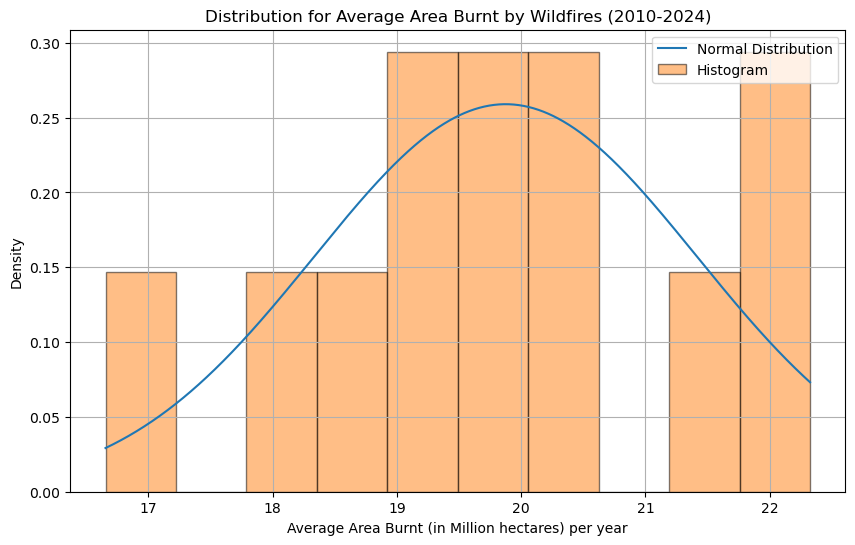

In [38]:
data = Avg_Wildfire_Area_Burnt_btw_2012_and_2023

l_mean = Avg_Wildfire_Area_Burnt_btw_2012_and_2023_mean
l_std = Avg_Wildfire_Area_Burnt_btw_2012_and_2023_std
print(l_mean,l_std)
# Plotting the histogram

x = np.linspace(min(data), max(data), 1000)

y = norm.pdf(x, l_mean, l_std)
y1=gamma.pdf(x, a=Avg_Wildfire_Area_Burnt_btw_2012_and_2023_alpha_mom, scale=Avg_Wildfire_Area_Burnt_btw_2012_and_2023_beta_mom)
y2 = expon.pdf(x, scale=10)
y_fitted = norm_dist_fitted.cdf(x)
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='Normal Distribution')
# plt.plot(x, y1, label='Gamma Distribution')
# plt.plot(x, y_fitted, label='Student T Distribution')
# plt.plot(x, y2, label='Student T Distribution')
plt.hist(data, bins=10,edgecolor='black', density=True, alpha=0.5, label='Histogram')
plt.title('Distribution for Average Area Burnt by Wildfires (2010-2024)')
plt.xlabel('Average Area Burnt (in Million hectares) per year')
plt.ylabel('Density')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()


In [39]:
mu_lower = Avg_Wildfire_Area_Burnt_btw_2012_and_2023_mean - 3 * Avg_Wildfire_Area_Burnt_btw_2012_and_2023_std
mu_upper = Avg_Wildfire_Area_Burnt_btw_2012_and_2023_mean + 3 * Avg_Wildfire_Area_Burnt_btw_2012_and_2023_std
sigma_lower = 0.1  # A small positive number to avoid issues with zero or negative standard deviations
sigma_upper = 3 * Avg_Wildfire_Area_Burnt_btw_2012_and_2023_std  # You can adjust this multiplier based on the level of dispersion you expect

with pm.Model() as wildfire_avg_area_burnt_per_year_norm_model:
    # Prior distributions for the parameters of the normal distribution
    mu = pm.Uniform('mu', lower=mu_lower, upper=mu_upper)
    sigma = pm.Uniform('sigma', lower=sigma_lower, upper=sigma_upper)

    # The likelihood of the observed data
    wildfire_avg_area_burnt_per_year_like = pm.Normal('wildfire_avg_area_burnt_per_year_like', mu=mu, sigma=sigma, observed=data)

    # Posterior distribution
    wildfire_avg_area_burnt_per_year_trace_norm = fit(random_seed=RANDOM_SEED).sample(1000)

Finished [100%]: Average Loss = 26.256


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/saipranath/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/saipranath/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


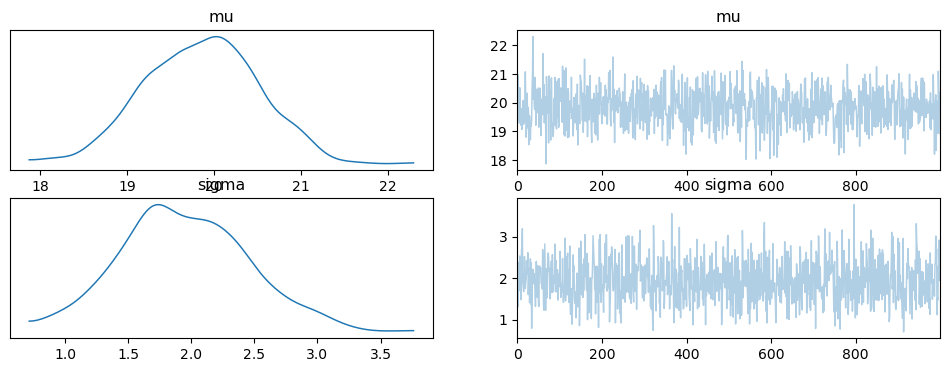

In [40]:

az.plot_trace(wildfire_avg_area_burnt_per_year_trace_norm)
plt.show()    

Mean from data: 19.874445409722224
Standard deviation from data: 1.5407255128154926
Mean from PyMC3: 19.84894651567399
Sigma from PyMC3: 1.9487878330243629
19.874445409722224 1.5407255128154926


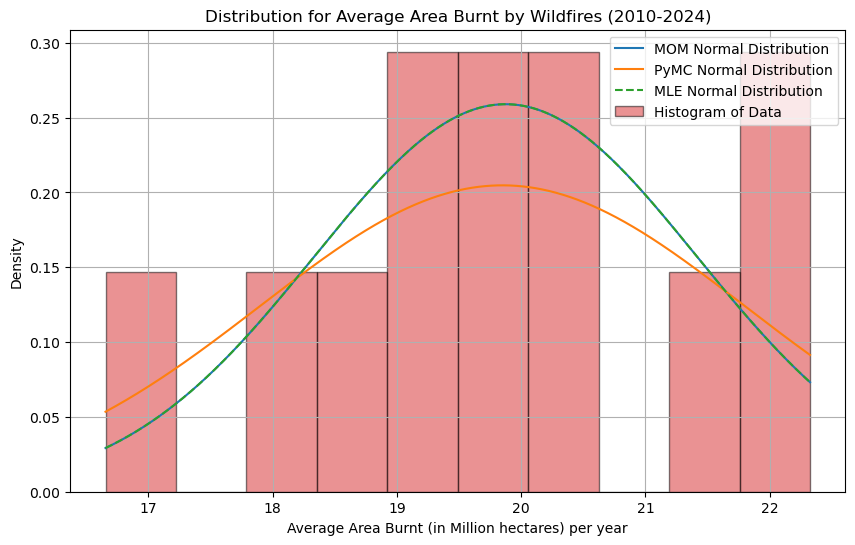

In [41]:

data = Avg_Wildfire_Area_Burnt_btw_2012_and_2023

# Calculate mean and standard deviation
l_mean = np.mean(data)
l_std = np.std(data)

wildfire_avg_area_burnt_per_year_trace_norm_mu = wildfire_avg_area_burnt_per_year_trace_norm['mu'].mean()
wildfire_avg_area_burnt_per_year_trace_norm_sigma = wildfire_avg_area_burnt_per_year_trace_norm['sigma'].mean()

print("Mean from data:", l_mean)
print("Standard deviation from data:", l_std)
print("Mean from PyMC3:", wildfire_avg_area_burnt_per_year_trace_norm_mu)
print("Sigma from PyMC3:", wildfire_avg_area_burnt_per_year_trace_norm_sigma)

# Set up a range of x values for the PDF plots
x = np.linspace(min(data), max(data), 1000)

# Normal Distribution using mean and std from data
y = norm.pdf(x, l_mean, l_std)

# Normal Distribution from PyMC3 results
pymc_norm_y = norm.pdf(x, wildfire_avg_area_burnt_per_year_trace_norm_mu, wildfire_avg_area_burnt_per_year_trace_norm_sigma)

# Fit a normal distribution using MLE
(mle_mu, mle_sigma) = norm.fit(data)
print(mle_mu, mle_sigma)
mle_norm_y = norm.pdf(x, mle_mu, mle_sigma)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='MOM Normal Distribution')
plt.plot(x, pymc_norm_y, label='PyMC Normal Distribution')
plt.plot(x, mle_norm_y, label='MLE Normal Distribution', linestyle='--')

# Plotting the histogram of the data
plt.hist(data, bins=10, edgecolor='black', density=True, alpha=0.5, label='Histogram of Data')

# Add titles and labels
plt.title('Distribution for Average Area Burnt by Wildfires (2010-2024)')
plt.xlabel('Average Area Burnt (in Million hectares) per year')
plt.ylabel('Density')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

# Mean from data: 33.31588890972221
# Standard deviation from data: 2.466448815566711
# Mean from PyMC3: 33.27506918535999
# Sigma from PyMC3: 3.122333125153424
# 33.31588890972221 2.466448815566711


In [42]:
# KS test for MOM
D_mom, p_mom = stats.kstest(data, 'norm', args=(l_mean, l_std))
print(f"MOM KS Statistic: {D_mom}, p-value: {p_mom}")

# KS test for MLE
D_mle, p_mle = stats.kstest(data, 'norm', args=(mle_mu, mle_sigma))
print(f"MLE KS Statistic: {D_mle}, p-value: {p_mle}")

# KS test for PyMC3
# Since PyMC3 parameters do not directly translate into scipy's CDF function, we need to manually apply the CDF
norm_dist_pymc = stats.norm(wildfire_avg_area_burnt_per_year_trace_norm_mu, wildfire_avg_area_burnt_per_year_trace_norm_sigma)
D_pymc, p_pymc = stats.kstest(data, lambda x: norm_dist_pymc.cdf(x))
print(f"PyMC3 KS Statistic: {D_pymc}, p-value: {p_pymc}")


MOM KS Statistic: 0.09772552693757924, p-value: 0.9990289068364864
MLE KS Statistic: 0.09772552693757924, p-value: 0.9990289068364864
PyMC3 KS Statistic: 0.13345727399838758, p-value: 0.9640963317841308


# MOM/MLE with Normal Distribution Suits better for modelling Average Area Burnt (in Million hectares) per year

Next, we'll model annual CO2 emissions between the years 2012 and 2023.

In [43]:
Annual_carbon_dioxide_emissions_values = filtered_Co2_Emissions_btw_2012_and_2023_df
Annual_carbon_dioxide_emissions_values = Annual_carbon_dioxide_emissions_values[:-1]
Annual_carbon_dioxide_emissions_mean = Annual_carbon_dioxide_emissions_values.mean()
Annual_carbon_dioxide_emissions_std = Annual_carbon_dioxide_emissions_values.std()
Annual_carbon_dioxide_emissions_mean,Annual_carbon_dioxide_emissions_std

(2747.3569272727273, 374.2254401421157)

In [44]:
Annual_carbon_dioxide_emissions_values

31    3088.6840
32    3069.4208
33    2962.1245
34    3116.4324
35    3337.4440
36    2557.9756
37    2567.8746
38    2401.0365
39    2218.5660
40    2505.4848
41    2395.8830
Name: Annual_carbon_dioxide_emissions, dtype: float64

In 2021, the total global CO2 emissions amounted to 36.82 billion metric tons, with wildfires alone contributing 5.89 billion tons. This indicates that wildfires are responsible for approximately 16% of annual CO2 emissions.

In [45]:
Annual_carbon_dioxide_emissions_alpha_mom = Annual_carbon_dioxide_emissions_mean ** 2 / Annual_carbon_dioxide_emissions_std
Annual_carbon_dioxide_emissions_beta_mom = Annual_carbon_dioxide_emissions_std / Annual_carbon_dioxide_emissions_mean
Annual_carbon_dioxide_emissions_alpha_mom, Annual_carbon_dioxide_emissions_beta_mom

(20169.5803550048, 0.13621289481072466)

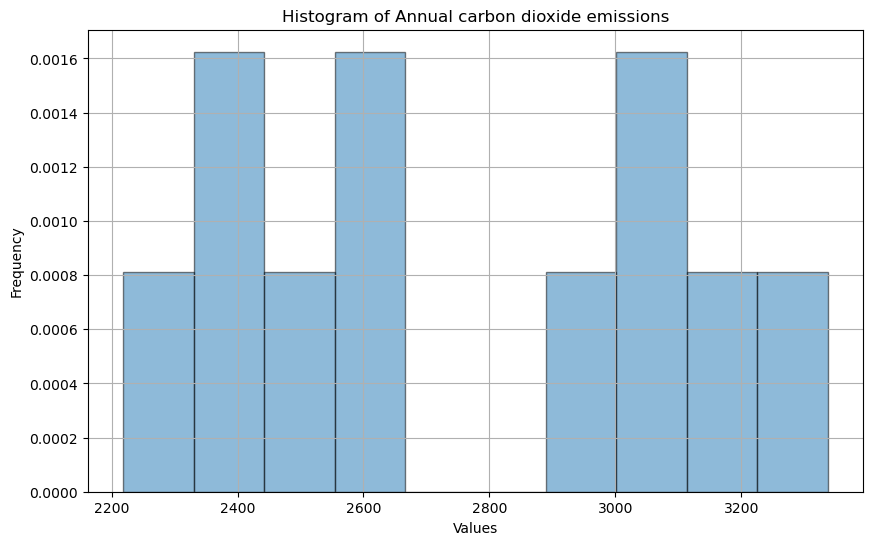

In [46]:

plt.figure(figsize=(10, 6))

plt.hist(Annual_carbon_dioxide_emissions_values, bins=10,edgecolor='black', density=True, alpha=0.5, label='Histogram')

plt.title('Histogram of Annual carbon dioxide emissions')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [47]:
params = stats.gamma.fit(Annual_carbon_dioxide_emissions_values)
gamma_dist_fitted = stats.gamma(*params)
D, p = stats.kstest(Annual_carbon_dioxide_emissions_values, gamma_dist_fitted.cdf)


print(f"KS Statistic: {D}, p-value: {p}")
# KS Statistic: 0.23797922591808618, p-value: 0.4889150967010749 - Norm
# KS Statistic: 0.21138573840353891, p-value: 0.6364383781804617 - gamma

KS Statistic: 0.21138573840353891, p-value: 0.6364383781804617


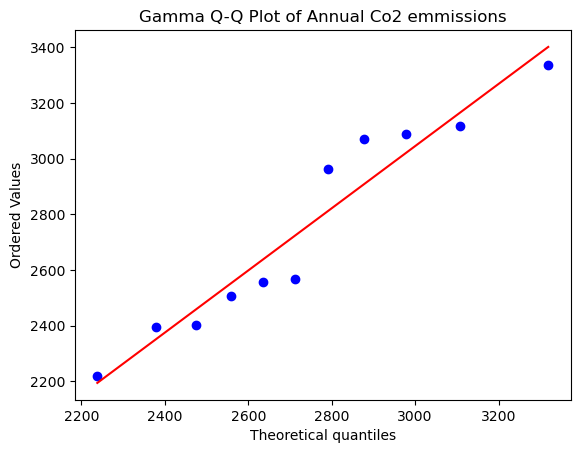

In [48]:
# Quantitile plot


stats.probplot(Annual_carbon_dioxide_emissions_values, dist="gamma", sparams=params, plot=plt)
# stats.probplot(Annual_carbon_dioxide_emissions_values, dist="norm", plot=plt)
plt.title('Gamma Q-Q Plot of Annual Co2 emmissions')
plt.show()


In [49]:
# # Historical values

# historical_values = Annual_carbon_dioxide_emissions_values

# # Generate data for the normal distribution curve
# x = np.linspace(min(historical_values), max(historical_values), 100)
# y = norm.pdf(x, Annual_carbon_dioxide_emissions_mean, Annual_carbon_dioxide_emissions_std)
# y1=gamma.pdf(x, a=Annual_carbon_dioxide_emissions_alpha_mom, scale=Annual_carbon_dioxide_emissions_beta_mom)

# plt.figure(figsize=(10, 6))
# plt.plot(x, y, label='Normal Distribution')
# # plt.plot(x, y1, label='Gamma Distribution')
# plt.hist(historical_values, bins=10, density=True, alpha=0.5, label='Histogram')
# plt.title('Probability Density Functions of Annual Carbon Dioxide Emissions')
# plt.xlabel('Annual Carbon Dioxide Emissions in Billion Tons')
# plt.ylabel('Probability Density')
# plt.legend()
# plt.grid(True)
# plt.show()

In [50]:
# with Model() as wildfire_annual_co2_emission_model_normal:
#     nalpha = Normal('nalpha', mu=Annual_carbon_dioxide_emissions_alpha_mom, sd=10)
#     nbeta = Normal('nbeta', mu=Annual_carbon_dioxide_emissions_alpha_mom, sd=10)
#     co2_emission_like = Gamma('co2_emission_like', alpha=nalpha, beta=nbeta, observed=Annual_carbon_dioxide_emissions_values)
#     co2_emission_trace_normal = fit(random_seed=RANDOM_SEED).sample(1000)
range_factor = 3  
lower_bound_alpha = max(0, Annual_carbon_dioxide_emissions_mean - range_factor * Annual_carbon_dioxide_emissions_std)
upper_bound_alpha = Annual_carbon_dioxide_emissions_mean + range_factor * Annual_carbon_dioxide_emissions_std
lower_bound_beta = max(0, Annual_carbon_dioxide_emissions_mean - range_factor * Annual_carbon_dioxide_emissions_std)
upper_bound_beta = Annual_carbon_dioxide_emissions_mean + range_factor * Annual_carbon_dioxide_emissions_std
with pm.Model() as co2_model:
    alpha = pm.Uniform('galpha', lower=lower_bound_alpha, upper=upper_bound_alpha)
    beta = pm.Uniform('gbeta', lower=lower_bound_beta, upper=upper_bound_beta)
    
    co2_observed = pm.Gamma('co2_observed', alpha=alpha, beta=beta, observed=Annual_carbon_dioxide_emissions_values)
    co2_emission_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Finished [100%]: Average Loss = 5.2654e+07


In [51]:
ealpha_posterior_mean = co2_emission_trace['galpha'].mean()
ebeta_posterior_mean = co2_emission_trace['gbeta'].mean()
print(ealpha_posterior_mean,ebeta_posterior_mean )
# x = np.linspace(0, 200, 100)
# Annual_carbon_dioxide_emissions_values.hist(density=True, bins=10)
# plt.plot(x, gamma.pdf(x, ealpha_posterior_mean, ebeta_posterior_mean))

3758.079711723056 1735.3155624264796


17.667260029216592 1259.7611679645715


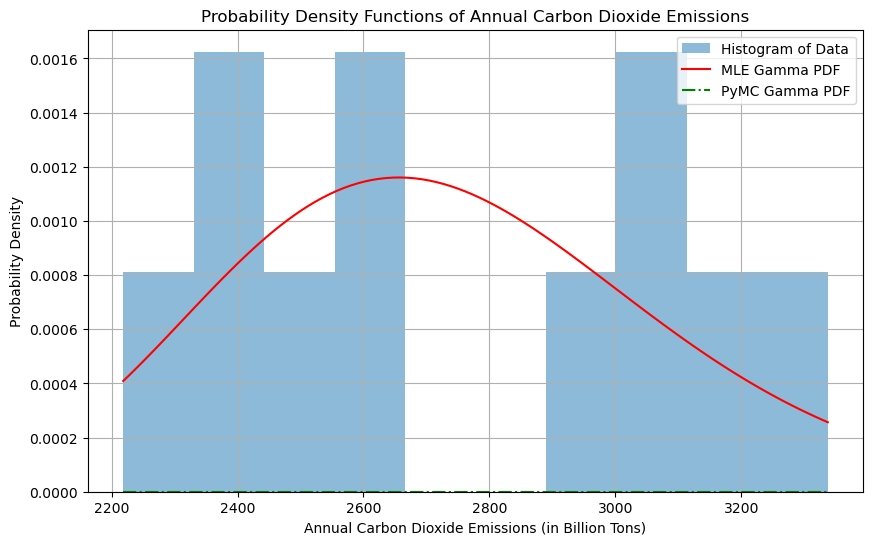

In [52]:

historical_values = Annual_carbon_dioxide_emissions_values

x = np.linspace(min(historical_values), max(historical_values), 100)

# Normal Distribution for reference
# y_normal = norm.pdf(x, Annual_carbon_dioxide_emissions_mean, Annual_carbon_dioxide_emissions_std)

# Method of Moments (MOM) Gamma PDF
mom_alpha = Annual_carbon_dioxide_emissions_alpha_mom
mom_beta = Annual_carbon_dioxide_emissions_beta_mom
y_mom_gamma = gamma.pdf(x, mom_alpha, scale=mom_beta)

# Maximum Likelihood Estimation (MLE) Gamma PDF
mle_params = gamma.fit(historical_values)
y_mle_gamma = gamma.pdf(x, mle_params[0], loc=mle_params[1], scale=mle_params[2])
print(mle_params[0],mle_params[1])

# # Bayesian PyMC Gamma PDF
# Assuming `ealpha_posterior_mean` and `ebeta_posterior_mean` are available from PyMC model outputs
pymc_alpha = ealpha_posterior_mean  # Make sure to define this variable from PyMC output
pymc_beta = ebeta_posterior_mean   # Make sure to define this variable from PyMC output
y_pymc_gamma = gamma.pdf(x, pymc_alpha, scale=1/pymc_beta)

# Plotting all the distributions
plt.figure(figsize=(10, 6))
plt.hist(historical_values, bins=10, density=True, alpha=0.5, label='Histogram of Data')
# plt.plot(x, y_normal, label='Normal Distribution', linestyle='--')
# plt.plot(x, y_mom_gamma, label='MOM Gamma PDF', linestyle='-.')
plt.plot(x, y_mle_gamma, label='MLE Gamma PDF', color='r', linestyle='-')
plt.plot(x, y_pymc_gamma, label='PyMC Gamma PDF', color='green', linestyle='-.')

# Adding title and labels
plt.title('Probability Density Functions of Annual Carbon Dioxide Emissions')
plt.xlabel('Annual Carbon Dioxide Emissions (in Billion Tons)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()


# MLE with Gamma Distribution Suits better for modelling Annual Carbon Dioxide Emissions (in Billion Tons)

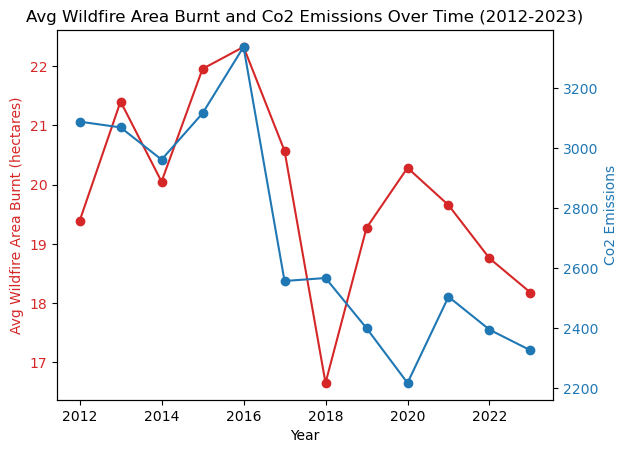

In [53]:

# Create figure and axis objects
fig, ax1 = plt.subplots()

# Plotting the Average Wildfire Area Burnt on the primary y-axis
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('Avg Wildfire Area Burnt (hectares)', color=color)
ax1.plot(year_range, Avg_Wildfire_Area_Burnt_btw_2012_and_2023, color=color, marker='o', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the PM2.5 emissions data
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Co2 Emissions', color=color)  # we already handled the x-label with ax1
ax2.plot(year_range, filtered_Co2_Emissions_btw_2012_and_2023_df, color=color, marker='o', linestyle='-')
ax2.tick_params(axis='y', labelcolor=color)

# Adding a title
plt.title('Avg Wildfire Area Burnt and Co2 Emissions Over Time (2012-2023)')

# Show the plot
plt.show()


In [54]:


# print(len(Avg_Wildfire_Area_Burnt_btw_2012_and_2023))
# print(len(filtered_pm25_Emissons_in_year_rang_df))
# print((Avg_Wildfire_Area_Burnt_btw_2012_and_2023))
# print((filtered_pm25_Emissons_in_year_rang_df))
correlation_coefficient = np.corrcoef(Avg_Wildfire_Area_Burnt_btw_2012_and_2023,filtered_Co2_Emissions_btw_2012_and_2023_df )[0, 1]
print(f'Correlation coefficient: {correlation_coefficient:.2f}')

Correlation coefficient: 0.63


A correlation coefficient of 0.63 shows a fairly strong link between two variables, meaning usually when one goes up, so does the other, but not always exactly. However, a 0.63 correlation doesn’t mean that more area burnt directly leads to more CO2 emissions. There might be other factors that affect both the area burnt and CO2 levels.

Below we used Bayesian linear regression to model the relationship between CO2 emissions (y_data) and the area burnt by wildfires (x_data) over the years 2012 to 2023. We set up a probabilistic model using PyMC (pm.Model()), where we define prior distributions for the regression parameters: alpha (intercept) and beta (slope) are given uniform distributions based on calculated limits from the data, and sigma (the error term's standard deviation) follows a Half-Normal distribution. Within this Bayesian framework, we constructed a linear regression equation (mu = alpha + beta * x_data), and specify a normal likelihood function for observing the data, which integrates our model with the actual CO2 emissions. We then perform posterior sampling using Markov Chain Monte Carlo (MCMC) to generate probable values for our unknown parameters (alpha, beta, sigma), and finally visualize the distribution of these parameters using ArviZ's plotting functions to assess the convergence and variability of our model's estimates.

/Users/saipranath/anaconda3/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]


/Users/saipranath/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 3 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/saipranath/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


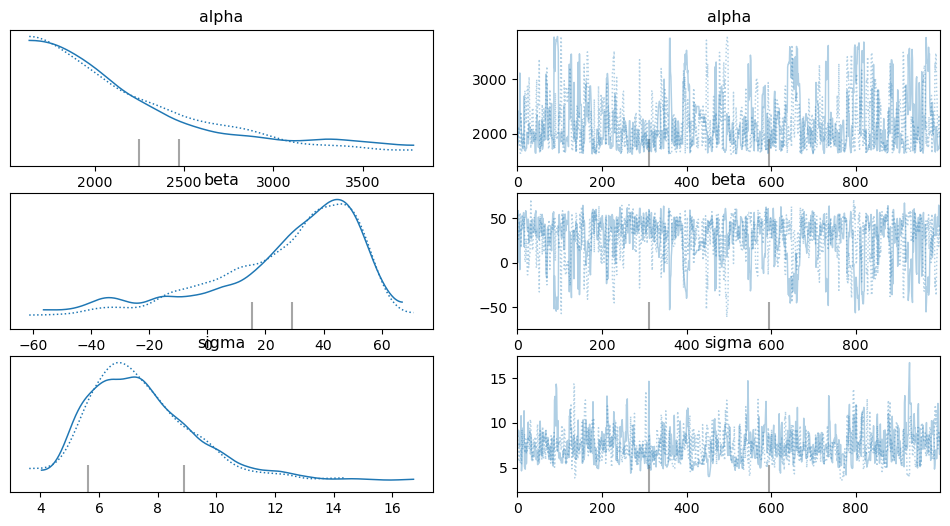

In [55]:

# x_data = np.array(Avg_Wildfire_Area_Burnt_btw_2012_and_2023)  # Predictor variable
# y_data = np.array(filtered_Co2_Emissions_btw_2012_and_2023_df)   # Response variable 

# alpha_lower = y_data.mean() - 3 * y_data.std()
# alpha_upper = y_data.mean() + 3 * y_data.std()

# beta_lower = -3 * np.abs(y_data / x_data).max()
# beta_upper = 3 * np.abs(y_data / x_data).max()


# with pm.Model() as normal_regression_model:
#     # Priors for unknown model parameters using Uniform distribution
#     alpha = pm.Uniform('alpha', lower=alpha_lower, upper=alpha_upper)
#     beta = pm.Uniform('beta', lower=beta_lower, upper=beta_upper)
    
#     # Standard deviation still uses a HalfNormal
#     sigma = pm.HalfNormal('sigma', sigma=10)

#     # Linear regression model
#     mu = alpha + beta * x_data

#     # Likelihood (sampling distribution) of observations
#     Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y_data)

#     # Posterior sampling
#     trace = pm.sample(1000, tune=2000, cores=1)

# # Inspecting the trace with ArviZ
# az.plot_trace(trace)
# plt.show()


# Predictor variable (area burnt)
x_data = np.array(Avg_Wildfire_Area_Burnt_btw_2012_and_2023)

# Response variable (CO2 emissions)
y_data = np.array(filtered_Co2_Emissions_btw_2012_and_2023_df)

# Calculating bounds for the uniform priors
alpha_lower = y_data.mean() - 3 * y_data.std()
alpha_upper = y_data.mean() + 3 * y_data.std()
beta_lower = -3 * np.abs(y_data / x_data).max()
beta_upper = 3 * np.abs(y_data / x_data).max()

with pm.Model() as gamma_regression_model:
    # Priors for unknown model parameters using Uniform distribution
    alpha = pm.Uniform('alpha', lower=alpha_lower, upper=alpha_upper)
    beta = pm.Uniform('beta', lower=beta_lower, upper=beta_upper)
    
    # Standard deviation still uses a HalfNormal (for the scale parameter of the Gamma)
    sigma = pm.HalfNormal('sigma', sigma=10)

    # Linear regression model (for the mean of the Gamma)
    mu = alpha + beta * x_data

    # Likelihood (sampling distribution) of observations using Gamma
    Y_obs = pm.Gamma('Y_obs', alpha=mu / sigma**2, beta=1/sigma**2, observed=y_data)

    # Posterior sampling
    trace = pm.sample(1000, tune=2000, cores=1)

# Inspecting the trace with ArviZ
az.plot_trace(trace)
plt.show()


2202.11440052341 26.77840223217408


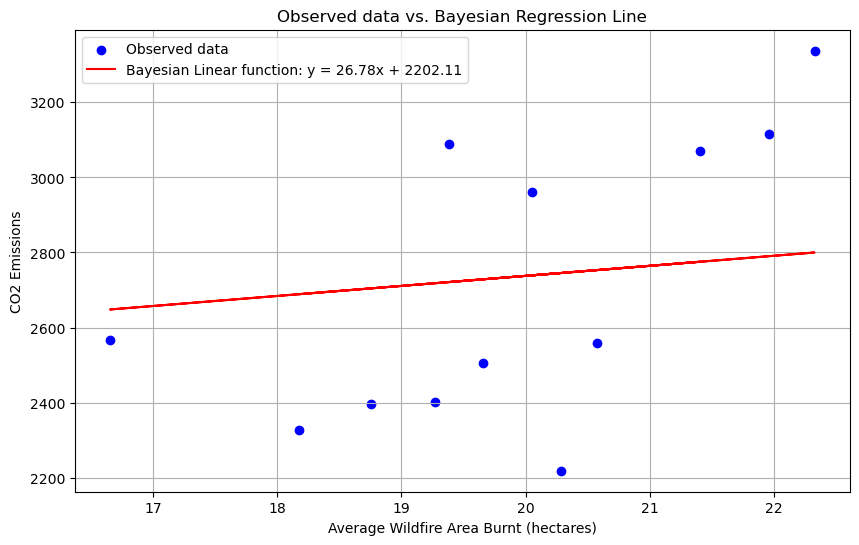

In [56]:
# Extract the mean of the posterior for alpha and beta
alpha_mean = np.mean(trace['alpha'])
beta_mean = np.mean(trace['beta'])
print(alpha_mean, beta_mean )
# Generate predictions for the regression line
y_pred = alpha_mean + beta_mean * x_data
y_pred_pymc = y_pred
# Plot the observed data
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, color='blue', label='Observed data')

# Plot the regression line
plt.plot(x_data, y_pred, color='red', label=f'Bayesian Linear function: y = {beta_mean:.2f}x + {alpha_mean:.2f}')

# Add title and labels
plt.title('Observed data vs. Bayesian Regression Line')
plt.xlabel('Average Wildfire Area Burnt (hectares)')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.grid(True)
plt.show()


for further analysis we then performed simple linear regression using the stats.linregress function from SciPy,  The function calculates the slope and intercept of the best-fit line, along with the correlation coefficient (r_value), the p-value, and the standard error of the slope (std_err).

In [57]:
from scipy import stats

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(Avg_Wildfire_Area_Burnt_btw_2012_and_2023, filtered_Co2_Emissions_btw_2012_and_2023_df)
y_pred_linregress = intercept + slope * x_data
# Display the linear function
print(f'Linear function: y = {slope:.2f}x + {intercept:.2f}')


Linear function: y = 146.50x + -199.26


In [58]:
# from sklearn.linear_model import LinearRegression
# import numpy as np

# # Assuming Avg_Wildfire_Area_Burnt_btw_2012_and_2023 and filtered_Co2_Emissions_btw_2012_and_2023_df are arrays or similar
# # Reshape your data to fit sklearn requirements (n_samples, n_features)
# X = np.array(Avg_Wildfire_Area_Burnt_btw_2012_and_2023).reshape(-1, 1)
# y = np.array(filtered_Co2_Emissions_btw_2012_and_2023_df)

# # Initialize the LinearRegression model
# model = LinearRegression()

# # Fit the model
# model.fit(X, y)

# # Obtain the slope and intercept
# slope = model.coef_[0]
# intercept = model.intercept_

# # Calculate predictions (optional, for demonstration)
# y_pred = model.predict(X)

# # Display the linear function
# print(f'Linear function: y = {slope:.2f}x + {intercept:.2f}')


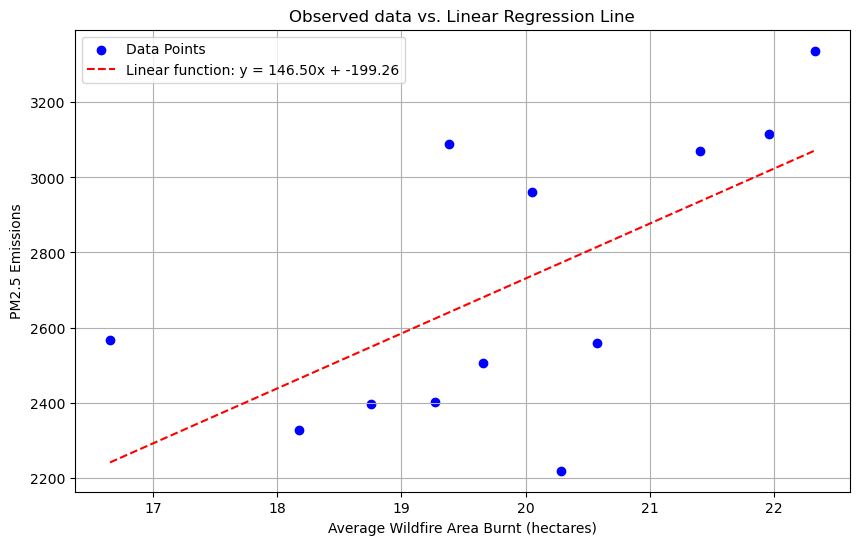

In [59]:

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(Avg_Wildfire_Area_Burnt_btw_2012_and_2023, filtered_Co2_Emissions_btw_2012_and_2023_df, color='blue', label='Data Points')

# Adding labels and title
plt.xlabel('Average Wildfire Area Burnt (hectares)')
plt.ylabel('PM2.5 Emissions')
plt.title('Observed data vs. Linear Regression Line')

x_values = np.linspace(min(Avg_Wildfire_Area_Burnt_btw_2012_and_2023), max(Avg_Wildfire_Area_Burnt_btw_2012_and_2023), 100)

y_values = slope * x_values +intercept  # Linear equation

# Plot the line
plt.plot(x_values, y_values, "r--", label=f'Linear function: y = {slope:.2f}x + {intercept:.2f}')

# Adding legend
plt.legend()

# Show the plot with grid
plt.grid(True)
plt.show()


In [60]:
from sklearn.metrics import mean_squared_error

mse_1 = mean_squared_error(y_data, y_pred_pymc)
print(y_pred_pymc)
mse_2 = mean_squared_error(y_data, y_pred_linregress)
print(y_pred_linregress)

rmse_1 = np.sqrt(mse_1)
rmse_2 = np.sqrt(mse_2)

from sklearn.metrics import r2_score

r2_1 = r2_score(y_data, y_pred_pymc)
r2_2 = r2_score(y_data, y_pred_linregress)

from sklearn.metrics import mean_absolute_error

mae_1 = mean_absolute_error(y_data, y_pred_pymc)
mae_2 = mean_absolute_error(y_data, y_pred_linregress)




[2721.23782836 2775.26224621 2739.0570832  2790.02184991 2799.92319314
 2752.99270654 2648.11220437 2718.16902569 2745.2825083  2728.44309081
 2704.40323098 2688.93855864]
[2640.76069974 2936.31744247 2738.24626516 3017.06427081 3071.2325316
 2814.48526238 2240.70509346 2623.97189654 2772.3043159  2680.17924393
 2548.66199764 2464.05788036]


In [61]:
print(f"Function 1 - RMSE: {rmse_1}, R-squared: {r2_1}, MAE: {mae_1}")
print(f"Function 2 - RMSE: {rmse_2}, R-squared: {r2_2}, MAE: {mae_2}")

# Decide based on comparison
if rmse_1 < rmse_2 and r2_1 > r2_2:
    print("Function 1 fits better.")
elif rmse_2 < rmse_1 and r2_2 > r2_1:
    print("Function 2 fits better.")
else:
    print("Results are inconclusive or mixed; consider additional analysis.")


Function 1 - RMSE: 337.28094893629145, R-squared: 0.1262652799667241, MAE: 313.4219687097205
Function 2 - RMSE: 281.5148051835186, R-squared: 0.39130679824037296, MAE: 249.60899945703764
Function 2 fits better.


### Conclusion

Our review points to the Bayesian regression model as the better choice for predicting CO2 emissions from wildfires, even though it doesn't match the traditional regression model in statistical accuracy(mean square erro, r2 score). This is because the Bayesian model avoids predicting impossible negative CO2 values, making it more realistic and useful for making decisions and planning policies.

This model clearly shows that as more area burns, CO2 emissions increase. Although the data suggests that reducing the area that burns could also lower emissions, we must remember that the connection between area burnt and CO2 isn't perfect(Correlation : 0.63). Other factors also play a role in CO2 emissions.

In future models, we aim to include more factors like fire intensity, weather conditions, and how long the fire burns. By considering these additional elements, we can better understand and predict the effects of wildfires on CO2 emissions. This will help in creating more effective strategies to manage wildfires and reduce their impact on climate change.


# PM2.5_Emissions_from_Wildfires


In [62]:
# Load CSV file into a DataFrame
df = pd.read_csv('data/annual-pm25-emissions-from-wildfires.csv')
df['Annual PM2.5 emissions from wildfires'] /= 10**6
df.head()

Entity Code  Year  Annual PM2.5 emissions from wildfires
0  Afghanistan  AFG  2003                               0.002039
1  Afghanistan  AFG  2004                               0.001456
2  Afghanistan  AFG  2005                               0.000942
3  Afghanistan  AFG  2006                               0.001483
4  Afghanistan  AFG  2007                               0.001731

In [63]:
df['Code'] = df['Code'].fillna(df['Entity'])

# Pivot the DataFrame to reshape it
pivot_df = df.pivot_table(index=['Entity', 'Code'], columns='Year', values='Annual PM2.5 emissions from wildfires').reset_index()

# Rounding off the emission values to two digits after the decimal point
pivot_df = pivot_df.round(2)

# Renaming the columns for better readability
pivot_df.columns.name = None  # Removing the name of the columns index
#pivot_df.columns = pivot_df.columns.astype(str)  # Converting column names to string
pivot_df = pivot_df.rename(columns={'Entity': 'Entity', 'Code': 'Code'})  # Renaming Entity and Code columns

pivot_df.drop(columns=[2024], inplace=True)


#print(pivot_df)
pivot_df

Entity      Code   2003   2004   2005   2006   2007  \
0              Afghanistan       AFG   0.00   0.00   0.00   0.00   0.00   
1                   Africa    Africa  10.73  10.37  10.94   9.91  11.14   
2    Akrotiri and Dhekelia  OWID_AKD   0.00   0.00   0.00   0.00   0.00   
3            Aland Islands       ALA   0.00   0.00   0.00   0.00   0.00   
4                  Albania       ALB   0.00   0.00   0.00   0.00   0.01   
..                     ...       ...    ...    ...    ...    ...    ...   
253         Western Sahara       ESH   0.00   0.00   0.00   0.00   0.00   
254                  World  OWID_WRL  36.57  31.34  30.57  29.47  30.39   
255                  Yemen       YEM   0.00   0.00   0.00   0.00   0.00   
256                 Zambia       ZMB   0.73   0.68   0.73   0.66   0.73   
257               Zimbabwe       ZWE   0.07   0.10   0.10   0.09   0.11   

      2008   2009   2010  ...   2014   2015   2016   2017   2018   2019  \
0     0.00   0.00   0.00  ...   0.00   0.00   0.00   0.00   0.00   0.00   
1    10.92  10.29  10.24  ...   9.75  10.36  11.27   8.47   8.42   7.96   
2     0.00   0.00   0.00  ...   0.00   0.00   0.00   0.00   0.00   0.00   
3     0.00   0.00   0.00  ...   0.00   0.00   0.00   0.00   0.00   0.00   
4     0.00   0.00   0.00  ...   0.00   0.00   0.00   0.00   0.00   0.00   
..     ...    ...    ...  ...    ...    ...    ...    ...    ...    ...   
253   0.00   0.00   0.00  ...   0.00   0.00   0.00   0.00   0.00   0.00   
254  28.02  25.46  26.92  ...  28.49  32.49  27.20  24.12  23.13  27.63   
255   0.00   0.00   0.00  ...   0.00   0.00   0.00   0.03   0.02   0.02   
256   0.78   0.65   0.75  ...   0.71   0.77   0.74   0.57   0.58   0.57   
257   0.13   0.12   0.14  ...   0.10   0.12   0.07   0.07   0.08   0.08   

      2020   2021   2022   2023  
0     0.00   0.00   0.00   0.00  
1     7.46   8.25   7.98   7.72  
2     0.00   0.00   0.00   0.00  
3     0.00   0.00   0.00   0.00  
4     0.00   0.00   0.00   0.00  
..     ...    ...    ...    ...  
253   0.00   0.00   0.00   0.00  
254  22.83  27.18  20.31  32.51  
255   0.03   0.02   0.01   0.02  
256   0.45   0.52   0.58   0.48  
257   0.02   0.06   0.09   0.08  

[258 rows x 23 columns]

# PM2.5 Emissions from Wildfires Across Different Regions

This visualization displays the annual PM2.5 emissions from wildfires for India, the United States, and the World over the years. Each subplot represents a region, showing the trend of emissions over time. The x-axis represents the years, while the y-axis represents the emissions measured in million metric tons. Data for India is represented by the country code 'IND', for the United States by 'USA', and for the World by 'OWID_WRL'.


In [64]:


# Filter the DataFrame for India with code 'IND'
india_df = pivot_df[(pivot_df['Entity'] == 'India') & (pivot_df['Code'] == 'IND')]

# Filter the DataFrame for United States with code 'USA'
usa_df = pivot_df[(pivot_df['Entity'] == 'United States') & (pivot_df['Code'] == 'USA')]

# Filter the DataFrame for World with code 'OWID_WRL'
world_df = pivot_df[(pivot_df['Entity'] == 'World') & (pivot_df['Code'] == 'OWID_WRL')]

africa_df = pivot_df[(pivot_df['Entity'] == 'Africa') & (pivot_df['Code'] == 'Africa')]

# Drop 'Entity' and 'Code' columns as they are no longer needed for plotting
india_df = india_df.drop(['Entity', 'Code'], axis=1)
usa_df = usa_df.drop(['Entity', 'Code'], axis=1)
world_df = world_df.drop(['Entity', 'Code'], axis=1)
africa_df = africa_df.drop(['Entity', 'Code'], axis=1)

# Transpose the DataFrames to have years as rows and emissions as columns
india_df = india_df.T
usa_df = usa_df.T
world_df = world_df.T
africa_df = africa_df.T

# # Plotting the histograms for India, the United States, and the World
# fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# # Plot for India
# axes[0].bar(india_df.index, india_df.values.flatten(), color='blue')
# axes[0].set_ylabel('Emissions(in Million)')
# axes[0].set_title('PM2.5 Emissions from Wildfires in India (Code: IND)')
# axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# # Plot for the United States
# axes[1].bar(usa_df.index, usa_df.values.flatten(), color='green')
# axes[1].set_ylabel('Emissions(in Million)')
# axes[1].set_title('PM2.5 Emissions from Wildfires in the United States (Code: USA)')
# axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# # Plot for the World
# axes[2].bar(world_df.index, world_df.values.flatten(), color='orange')
# axes[2].set_xlabel('Year')
# axes[2].set_ylabel('Emissions(in Million)')
# axes[2].set_title('PM2.5 Emissions from Wildfires in the World (Code: OWID_WRL)')
# axes[2].grid(axis='y', linestyle='--', alpha=0.7)

# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()


### PM2.5 Emissions from Wildfires in India

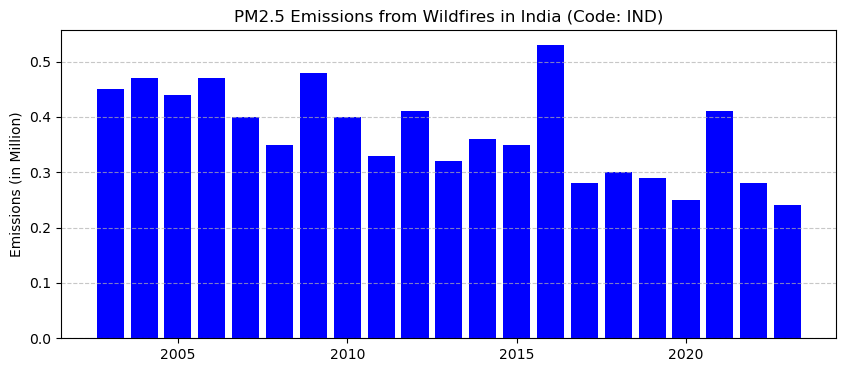

In [65]:
# Plot for India
fig, ax = plt.subplots(figsize=(10, 4))  # Adjust figsize as needed
ax.bar(india_df.index, india_df.values.flatten(), color='blue')
ax.set_ylabel('Emissions (in Million)')
ax.set_title('PM2.5 Emissions from Wildfires in India (Code: IND)')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Wildfires in Uttarakhand, India (2016)

In 2016, India experienced a significant wildfire outbreak in the state of Uttarakhand, particularly in the forests of the Himalayan region. The wildfires raged for several weeks, affecting vast areas of forest cover and leading to considerable ecological and environmental damage. The severity of the wildfires prompted a massive response from authorities, including firefighters, the Indian Air Force, and other disaster management agencies.

The exact causes of the wildfires in Uttarakhand in 2016 were multifaceted, but they were exacerbated by factors such as prolonged dry weather conditions, high temperatures, and human activities like land clearing, agricultural burning, and the use of fire for forest management practices.

The wildfires not only posed significant risks to the forest ecosystem and biodiversity but also impacted nearby human settlements and infrastructure. Thousands of hectares of forest land were affected, and the smoke from the fires contributed to air pollution in the region, affecting public health.

#### Some images from Uttarakhand wildfire
|  |  |  |
|---------|---------|---------|
| ![Image 1](images/I2016_4.jpeg) | ![Image 2](images/I2016_5.jpeg) | ![Image 3](images/I2016_3.avif) |

---

**Source & For more information:** https://en.wikipedia.org/wiki/2016_Uttarakhand_forest_fires


### PM2.5 Emissions from Wildfires in the United States

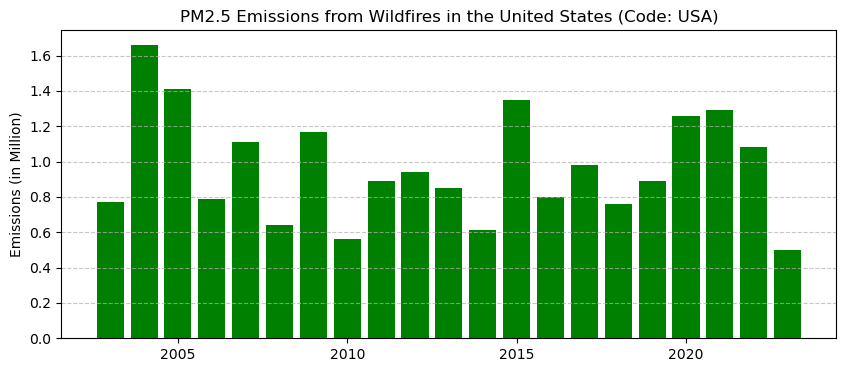

In [66]:
fig, ax = plt.subplots(figsize=(10, 4))  
ax.bar(usa_df.index, usa_df.values.flatten(), color='green')
ax.set_ylabel('Emissions (in Million)')
ax.set_title('PM2.5 Emissions from Wildfires in the United States (Code: USA)')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Okanogan Complex Fire: Washington State's Largest Wildfire (2015)

In 2015, Washington state faced one of its most devastating wildfires in history with the Okanogan Complex Fire. Here's an overview of the key details:

- **Size:** The Okanogan Complex Fire grew to become the largest wildfire in Washington's history, covering more than 256,567 acres. This surpassed the previous record set by the Carlton Complex fires in the preceding year, which burned 256,108 acres.

- **Composition:** Initially, the complex comprised five separate fires: the Twisp River fire, the Lime Belt fire, the Beaver Lake fire, the Blue Lake fire, and the Tunk Block fire. Subsequently, the Lime Belt, Beaver Lake, and Blue Lake fires merged into one, while the Tunk Block fire remained distinct.

- **Extent:** The two main branches of the fire, the merged Lime Belt fires, and the Tunk Block fire, each burned over 100,000 acres of land.

- **Causes:** The Okanogan Complex Fire was fueled by hot and dry weather conditions, exacerbated by strong winds. These factors contributed to the rapid spread and intensification of the wildfires.

- **Impacts:** The wildfire resulted in extensive destruction, consuming tens of thousands of acres of forest land and causing significant damage to homes, structures, and infrastructure. The severity of the blaze prompted widespread evacuations and posed significant challenges to firefighting efforts.

- **Response:** Firefighting efforts to contain the Okanogan Complex Fire involved a coordinated response from various agencies, including local, state, and federal firefighters. Assistance was also sought from neighboring states to combat the blaze. Despite these efforts, the fire burned for several weeks before it was fully contained.

The Okanogan Complex Fire serves as a poignant reminder of the devastating impact that wildfires can have on communities, ecosystems, and landscapes. It underscores the importance of proactive measures in fire management, prevention, and emergency response to mitigate the risks posed by such events.

**Source & For more information:** https://wildfiretoday.com/tag/okanagan-fire/


<div style="text-align:center;">
  <img src="images/Us_2015.webp" alt="Image 1" width="800"/>
  <p style="color: #808080; text-align:center">The red line was the fire perimeter of the Okanogan Complex at 11 p.m. PT August 19, 2015. The white line is from about 24 hours before.</p>
</div>

 



<div style="text-align:center;">
  <img src="images/Us_2015_2.webp" alt="Image 2"/>
  <p style="color: #808080; text-align:center">Okanogan Complex. Fire perimeter as of Aug. 24, 2015.</p>
</div>



### PM2.5 Emissions from Wildfires in the Africa

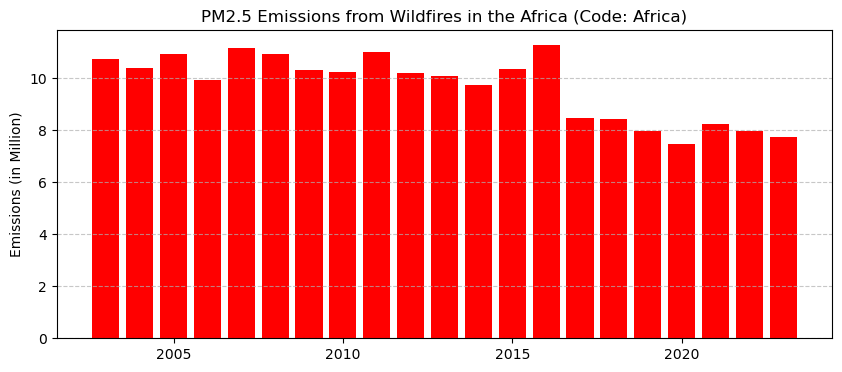

In [67]:
fig, ax = plt.subplots(figsize=(10, 4))  
ax.bar(africa_df.index, africa_df.values.flatten(), color='red')
ax.set_ylabel('Emissions (in Million)')
ax.set_title('PM2.5 Emissions from Wildfires in the Africa (Code: Africa)')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2016 Great Smoky Mountains Wildfires and South Africa Wildfires

The 2016 Great Smoky Mountains wildfires, also known as the Gatlinburg wildfires, were a complex of wildfires that began in late November 2016. Some of the towns most impacted were Pigeon Forge and Gatlinburg, both near Great Smoky Mountains National Park. The fires claimed at least 14 lives, injured 190, and are one of the largest natural disasters in the history of Tennessee.

Additionally, up to 10,000 people were evacuated from a scenic coastal town in South Africa that was devastated by wildfires, officials said. These fires, although separate from the Gatlinburg wildfires, added to the global impact of wildfires in 2016.

Both sets of wildfires underscore the devastating consequences of such events, including loss of life, injuries, and significant damage to property and the environment.



#### Some images from Great Smoky Mountains Wildfires
|  |  |  |
|---------|---------|---------|
| ![Image 1](images/A2016_1.webp) | ![Image 2](images/A2016_2.webp) | ![Image 3](images/A2016_3.webp) |

---

**Source & for more information:** https://en.wikipedia.org/wiki/2016_Great_Smoky_Mountains_wildfires

### PM2.5 Emissions from Wildfires in the World

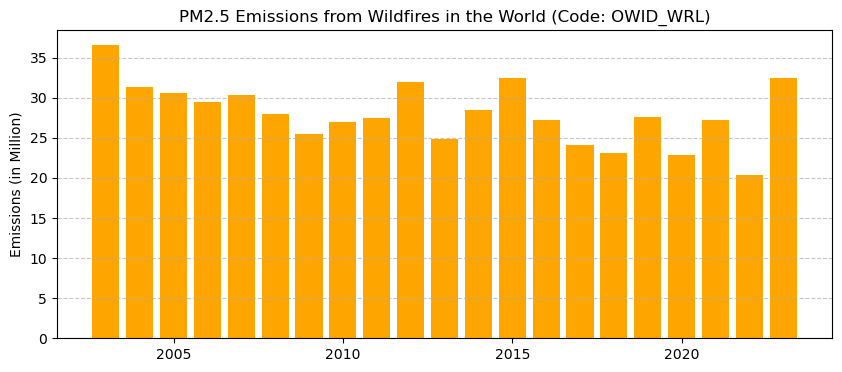

In [68]:
fig, ax = plt.subplots(figsize=(10, 4))  
ax.bar(world_df.index, world_df.values.flatten(), color='orange')
ax.set_ylabel('Emissions (in Million)')
ax.set_title('PM2.5 Emissions from Wildfires in the World (Code: OWID_WRL)')
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# PM2.5 Emissions and Distributions Comparison: India, USA, and Africa

This visualization compares the PM2.5 emissions and their distributions for India, the United States (USA), and Africa. Each subplot represents a region, showing the histogram of PM2.5 emissions along with the fitted normal, uniform, and exponential distributions. The x-axis represents PM2.5 emissions measured in million metric tons, while the y-axis represents the probability density. 

The first subplot displays the data for India, the second subplot for the USA, and the third subplot for Africa. This comparison provides insights into the distribution patterns of PM2.5 emissions across different regions.


458.33723224533014 0.17645894471612855


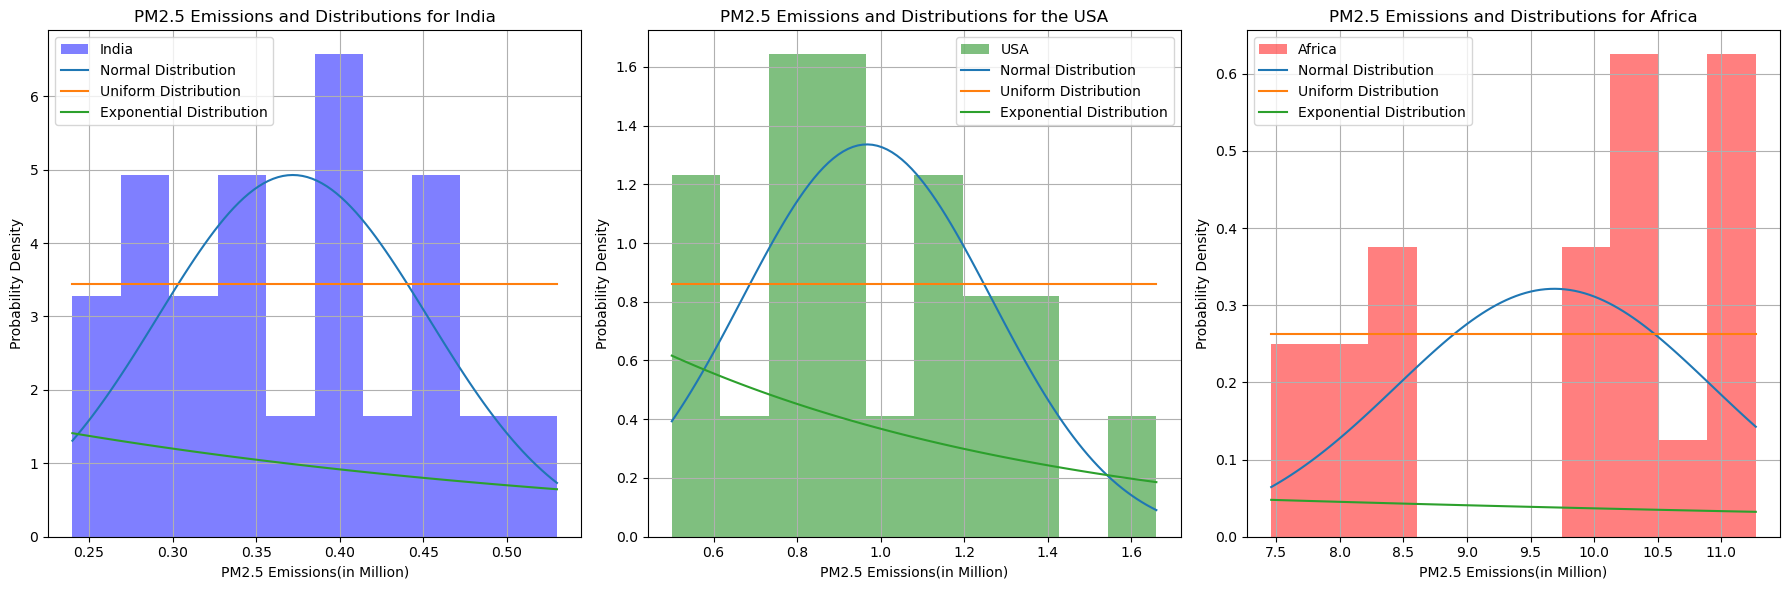

In [69]:


# Calculate mean and standard deviation for PM2.5 emissions for India and the USA
pm25_emissions_values_india = india_df.values.flatten()
pm25_emissions_mean_india = pm25_emissions_values_india.mean()
pm25_emissions_std_india = pm25_emissions_values_india.std()

pm25_emissions_values_usa = usa_df.values.flatten()
pm25_emissions_mean_usa = pm25_emissions_values_usa.mean()
pm25_emissions_std_usa = pm25_emissions_values_usa.std()

# Generate data for the normal distribution curve for India
x_india = np.linspace(min(pm25_emissions_values_india), max(pm25_emissions_values_india), 100)
y_normal_india = norm.pdf(x_india, pm25_emissions_mean_india, pm25_emissions_std_india)
y_uniform_india = uniform.pdf(x_india, loc=min(pm25_emissions_values_india), scale=max(pm25_emissions_values_india)-min(pm25_emissions_values_india))
y_exponential_india = expon.pdf(x_india, scale=pm25_emissions_mean_india)

# Generate data for the normal distribution curve for the USA
x_usa = np.linspace(min(pm25_emissions_values_usa), max(pm25_emissions_values_usa), 100)
y_normal_usa = norm.pdf(x_usa, pm25_emissions_mean_usa, pm25_emissions_std_usa)
y_uniform_usa = uniform.pdf(x_usa, loc=min(pm25_emissions_values_usa), scale=max(pm25_emissions_values_usa)-min(pm25_emissions_values_usa))
y_exponential_usa = expon.pdf(x_usa, scale=pm25_emissions_mean_usa)

# Calculate mean and standard deviation for PM2.5 emissions for the World
pm25_emissions_values_world = world_df.values.flatten()
pm25_emissions_mean_world = pm25_emissions_values_world.mean()
pm25_emissions_std_world = pm25_emissions_values_world.std()

#pm25_emissions_world_alpha_mom = pm25_emissions_mean_world ** 2 / pm25_emissions_std_world
#pm25_emissions_world_beta_mom = pm25_emissions_std_world / pm25_emissions_mean_world

# Calculate shape and scale parameters for the gamma distribution for the World
pm25_emissions_world_alpha, _, pm25_emissions_world_beta = gamma.fit(pm25_emissions_values_world)

print(pm25_emissions_world_alpha, pm25_emissions_world_beta)

# Generate data for the normal distribution curve for the World
x_world = np.linspace(min(pm25_emissions_values_world), max(pm25_emissions_values_world), 100)
y_normal_world = norm.pdf(x_world, pm25_emissions_mean_world, pm25_emissions_std_world)
y_uniform_world = uniform.pdf(x_world, loc=min(pm25_emissions_values_world), scale=max(pm25_emissions_values_world)-min(pm25_emissions_values_world))
y_exponential_world = expon.pdf(x_world, scale=pm25_emissions_mean_world)
y_gamma_world = gamma.pdf(x_world, a=pm25_emissions_world_alpha, scale=pm25_emissions_world_beta)

# Plotting the histograms and distributions for India, the USA, and the World
plt.figure(figsize=(18, 6))

# Plot histogram and distributions for India
plt.subplot(1, 3, 1)
plt.hist(pm25_emissions_values_india, bins=10, density=True, color='blue', alpha=0.5, label='India')
plt.plot(x_india, y_normal_india, label='Normal Distribution')
plt.plot(x_india, y_uniform_india, label='Uniform Distribution')
plt.plot(x_india, y_exponential_india, label='Exponential Distribution')
plt.title('PM2.5 Emissions and Distributions for India')
plt.xlabel('PM2.5 Emissions(in Million)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)

# Plot histogram and distributions for the USA
plt.subplot(1, 3, 2)
plt.hist(pm25_emissions_values_usa, bins=10, density=True, color='green', alpha=0.5, label='USA')
plt.plot(x_usa, y_normal_usa, label='Normal Distribution')
plt.plot(x_usa, y_uniform_usa, label='Uniform Distribution')
plt.plot(x_usa, y_exponential_usa, label='Exponential Distribution')
plt.title('PM2.5 Emissions and Distributions for the USA')
plt.xlabel('PM2.5 Emissions(in Million)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
#print(min(x_usa), max(x_usa))


# plt.subplot(1, 3, 3)


# Calculate mean and standard deviation for PM2.5 emissions for Africa
pm25_emissions_values_africa = africa_df.values.flatten()
pm25_emissions_mean_africa = pm25_emissions_values_africa.mean()
pm25_emissions_std_africa = pm25_emissions_values_africa.std()

# Generate data for the normal distribution curve for Africa
x_africa = np.linspace(min(pm25_emissions_values_africa), max(pm25_emissions_values_africa), 100)
y_normal_africa = norm.pdf(x_africa, pm25_emissions_mean_africa, pm25_emissions_std_africa)
y_uniform_africa = uniform.pdf(x_africa, loc=min(pm25_emissions_values_africa), scale=max(pm25_emissions_values_africa)-min(pm25_emissions_values_africa))
y_exponential_africa = expon.pdf(x_africa, scale=pm25_emissions_mean_africa)

plt.subplot(1, 3, 3)
plt.hist(pm25_emissions_values_africa, bins=10, density=True, color='red', alpha=0.5, label='Africa')
plt.plot(x_africa, y_normal_africa, label='Normal Distribution')
plt.plot(x_africa, y_uniform_africa, label='Uniform Distribution')
plt.plot(x_africa, y_exponential_africa, label='Exponential Distribution')
plt.title('PM2.5 Emissions and Distributions for Africa')
plt.xlabel('PM2.5 Emissions(in Million)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# PM2.5 Emissions and Distributions for the World

This visualization illustrates the PM2.5 emissions and their distributions for the world. The histogram represents the distribution of PM2.5 emissions, with the orange bars indicating the frequency of emissions in million metric tons. Additionally, fitted normal, uniform, and exponential distributions are plotted to analyze the distribution patterns.

The x-axis shows PM2.5 emissions measured in million metric tons, while the y-axis represents the probability density. The fitted distributions provide insights into the statistical characteristics of PM2.5 emissions in the world, facilitating a better understanding of their distribution patterns and variability.


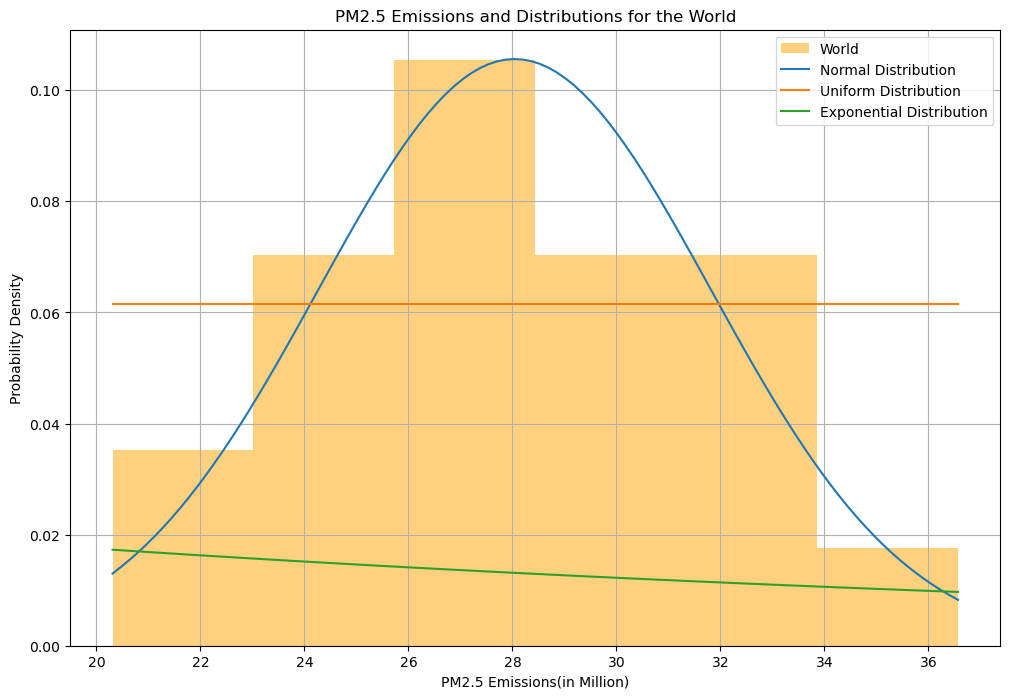

In [70]:
# Plot histogram and distributions for the World
plt.figure(figsize=(12, 8))
world_mean = pm25_emissions_values_world.mean()
world_var = pm25_emissions_values_world.var()
alpha_mom = (world_mean ** 2) / world_var
beta_mom = world_var / world_mean
world_mean, world_var, alpha_mom, beta_mom

x = np.linspace(0, max(pm25_emissions_values_world), 1000)
pdf = stats.gamma.pdf(x, alpha_mom, scale=beta_mom)

plt.hist(pm25_emissions_values_world, bins=6, density=True, color='orange', alpha=0.5, label='World')
plt.plot(x_world, y_normal_world, label='Normal Distribution')
plt.plot(x_world, y_uniform_world, label='Uniform Distribution')
#  plt.plot(x_world, y_gamma_world, label='Gamma Distribution')
plt.plot(x_world, y_exponential_world, label='Exponential Distribution')
plt.title('PM2.5 Emissions and Distributions for the World')
plt.xlabel('PM2.5 Emissions(in Million)')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)


# Practical vs Theoretical Gamma Distribution(MOM)

This plot compares the practical distribution of PM2.5 emissions in the world (shown as a histogram) with the theoretical gamma distribution. The histogram represents the observed frequency of PM2.5 emissions, while the red curve illustrates the theoretical gamma distribution fitted to the data.

The x-axis denotes the value of PM2.5 emissions, while the y-axis represents the density of the distribution. The comparison between the practical and theoretical distributions helps evaluate how well the gamma distribution model fits the observed data, providing insights into the underlying statistical characteristics of PM2.5 emissions.


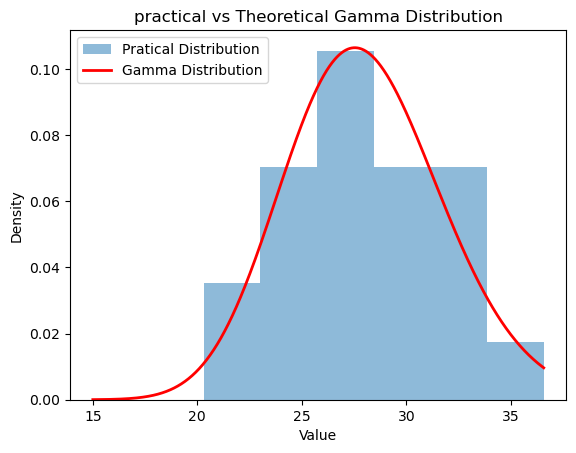

In [71]:
#MOM

world_mean = pm25_emissions_values_world.mean()
world_var = pm25_emissions_values_world.var()
alpha_mom = (world_mean ** 2) / world_var
beta_mom = world_var / world_mean
world_mean, world_var, alpha_mom, beta_mom

x = np.linspace(15, max(pm25_emissions_values_world), 1000)
pdf = stats.gamma.pdf(x, alpha_mom, scale=beta_mom)

# Plot practical and theoretical distributions
plt.hist(pm25_emissions_values_world, bins=6, density=True, alpha=0.5, label='Pratical Distribution')
plt.plot(x, pdf, 'r-', lw=2, label='Gamma Distribution')
# plt.plot(x_world, y_normal_world, label='Normal Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('practical vs Theoretical Gamma Distribution')
plt.legend()
plt.show()

# Bayesian simulation

Bayesian estimation: Let's pick pdfs for the  𝛾
  distribution's parameters  𝛼
  and  𝛽
 .

## Modeling Gamma parameters with an exponential distribution 

Let's try to accelerate things and try the exponential distribution, instead. Find the right number $x$ so that the distribution covers the range of possible bmi values.  In other words, find the right value $y$ such that `Exponential.dist(1/8.5).random(size=10000)` covers from 0 to 40 for the data. Try different values out by plotting with:

```python
sns.distplot(Exponential.dist(1/8.5).random(size=10000), kde=False);
```

Then. modeling model parameters will look like this:
```
from pymc3 import Model, Exponential

with Model() as rainfall_model:
    ealpha = Exponential('ealpha', 1/8.5)
    ebeta = Exponential('ebeta', 1/8.5)
```

/var/folders/8h/lyhtt3mn2sg7w7mc0dny8v5h0000gn/T/ipykernel_25938/3615887878.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Exponential.dist(1/8.5).random(size=10000), kde=False)


<Axes: >

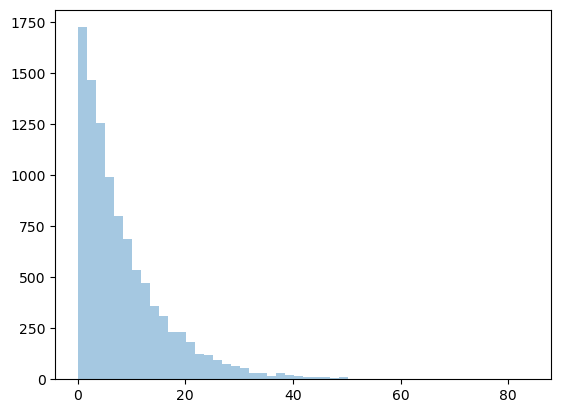

In [72]:
from pymc3 import Exponential
sns.distplot(Exponential.dist(1/8.5).random(size=10000), kde=False)

In [73]:
from pymc3 import Model, Exponential

with Model() as world_exponential:
    ealpha = Exponential('ealpha', 1/8.5)
    ebeta = Exponential('ebeta', 1/8.5)

In [74]:
from pymc3 import Gamma
with world_exponential:
    medical = Gamma('medical', alpha=ealpha, beta=ebeta, observed=pm25_emissions_values_world)

In [75]:
from pymc3 import fit

with world_exponential: 
    world_trace_exponential = fit(random_seed=RANDOM_SEED).sample(1000)

Finished [100%]: Average Loss = 141.29


In [76]:
world_trace_exponential['ealpha'].mean(), world_trace_exponential['ebeta'].mean()

(27.5966815044075, 1.029512554609902)

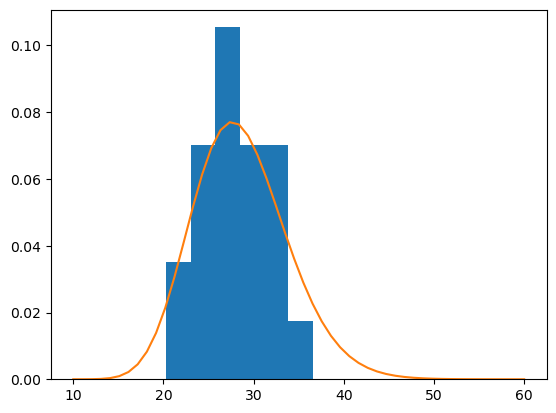

In [77]:
from scipy.stats.distributions import gamma

ealpha_posterior_mean = world_trace_exponential['ealpha'].mean()
ebeta_posterior_mean = world_trace_exponential['ebeta'].mean()

plt.hist(pm25_emissions_values_world, density=True, bins=6)
plt.plot(np.linspace(10, 60), gamma.pdf(np.linspace(10, 60), ealpha_posterior_mean, ebeta_posterior_mean))
#plt.plot(np.linspace(10, 60), gamma.pdf(np.linspace(10, 60), alpha_mom, scale=beta_mom), 'r-')

by using the exponential distribution model we found alpha and beta values. By using bayesian simulation we plotted the gamma pdf for the given medical dataset

Comparing the gamma plot obtained by using bayesian simulation with MOM(which we already done befoe)

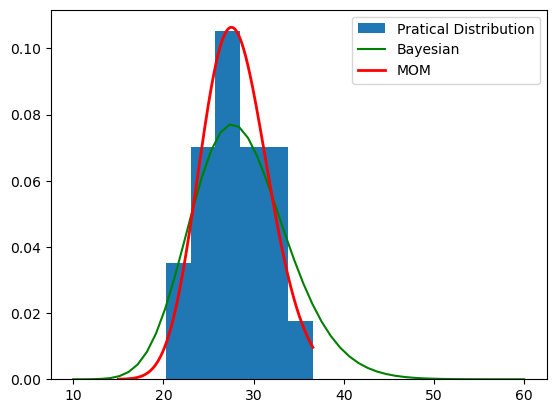

In [78]:
plt.hist(pm25_emissions_values_world, density=True, bins=6, label='Pratical Distribution')
plt.plot(np.linspace(10, 60), gamma.pdf(np.linspace(10, 60), ealpha_posterior_mean, ebeta_posterior_mean), 'g-', label='Bayesian')
plt.plot(x, pdf, 'r-', lw=2, label='MOM')
plt.legend()
plt.show()

As we can see from the above plot, based on our observation, MOM is the most suitable for the given dataset. It has a plot that covers most of the data compared to Bayesian simulation.

# Global PM 2.5 Emissions Over Time

This plot illustrates the trend of PM 2.5 emissions globally over the years. The x-axis represents the years, and the y-axis denotes the PM 2.5 emissions measured in million metric tons. Each data point is marked with a marker to indicate individual observations.


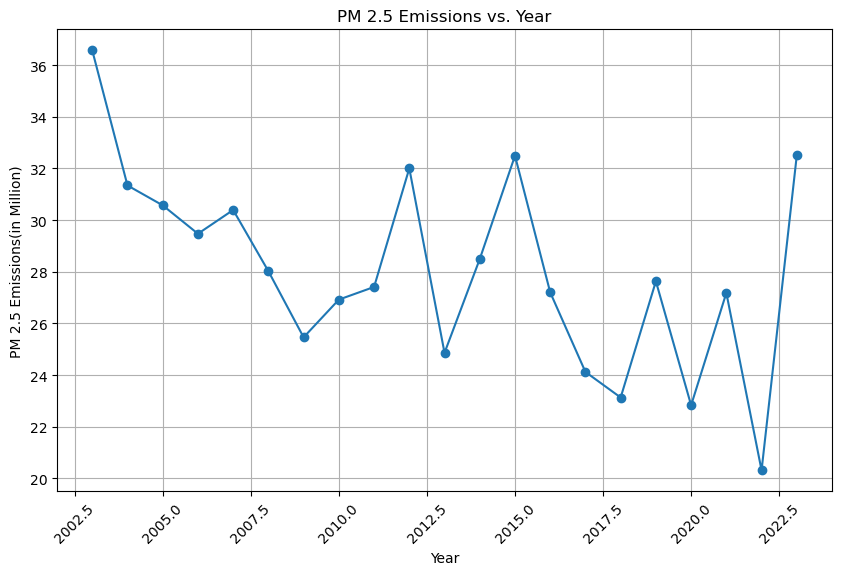

In [79]:
plt.figure(figsize=(10, 6))
plt.plot(world_df, marker='o', linestyle='-')
plt.title('PM 2.5 Emissions vs. Year')
plt.xlabel('Year')
plt.ylabel('PM 2.5 Emissions(in Million)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if necessary
plt.show()

### Filtering data for below 6 continents

In [80]:
continents = [
    'Africa', 
    'North America', 
    'South America',  
    'Asia', 
    'Europe', 
    'Oceania' 
]


year_range = range(2012, 2024)

# Dictionaries to hold filtered data
filtered_pm25_Emissions_by_continent = {}

# Filtering data for each continent and year range
for continent in continents:

    # Filter PM2.5 Emissions
    continent_pm25 = pivot_df[
        (pivot_df['Entity'] == continent) 
#         & 
#         (pm25_Emissons_Annually_df['Year'].isin(year_range))
    ]
    filtered_pm25_Emissions_by_continent[continent] = continent_pm25
    

# PM 2.5 Emissions Variation Across Continents Over Time

This visualization displays the variation in PM 2.5 emissions over time for different continents. Each plot represents the trend of PM 2.5 emissions for a specific continent, with markers indicating data points for individual years. The x-axis denotes the years, while the y-axis represents the PM 2.5 emissions. Each plot is labeled with the respective continent's name.


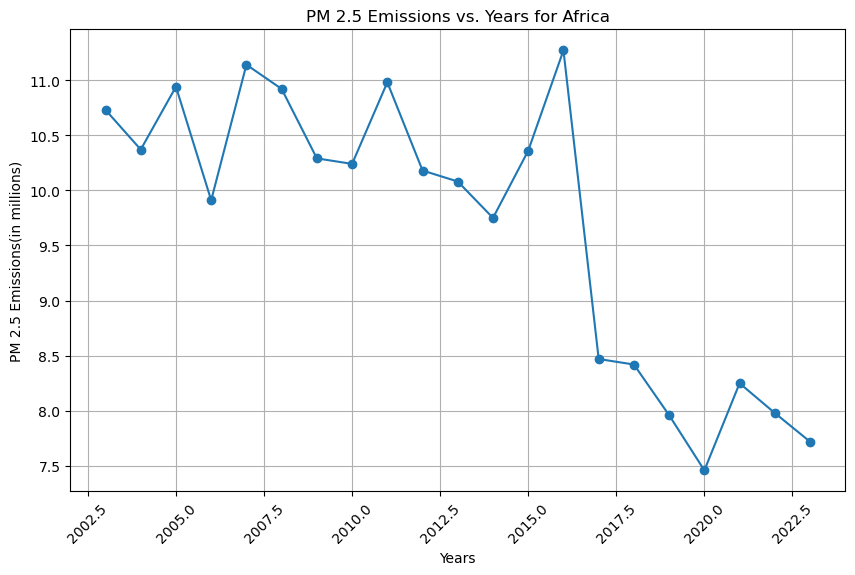

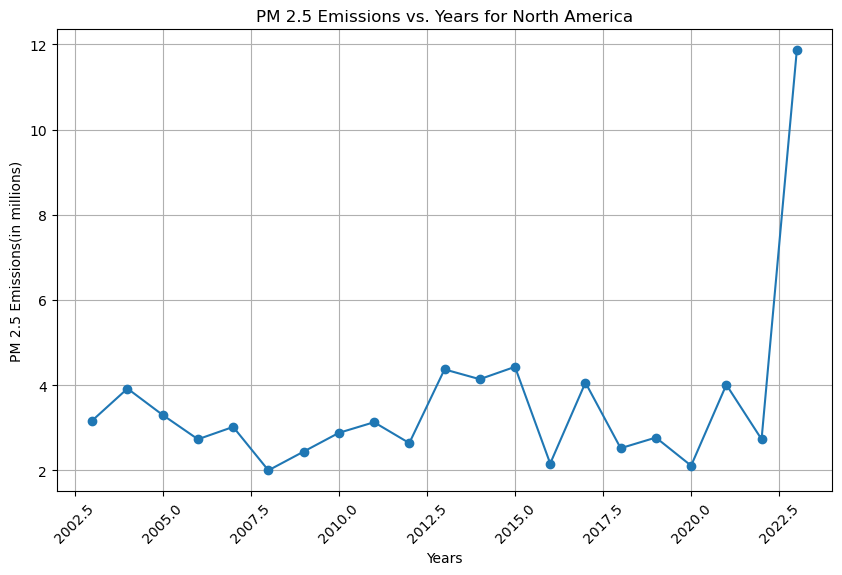

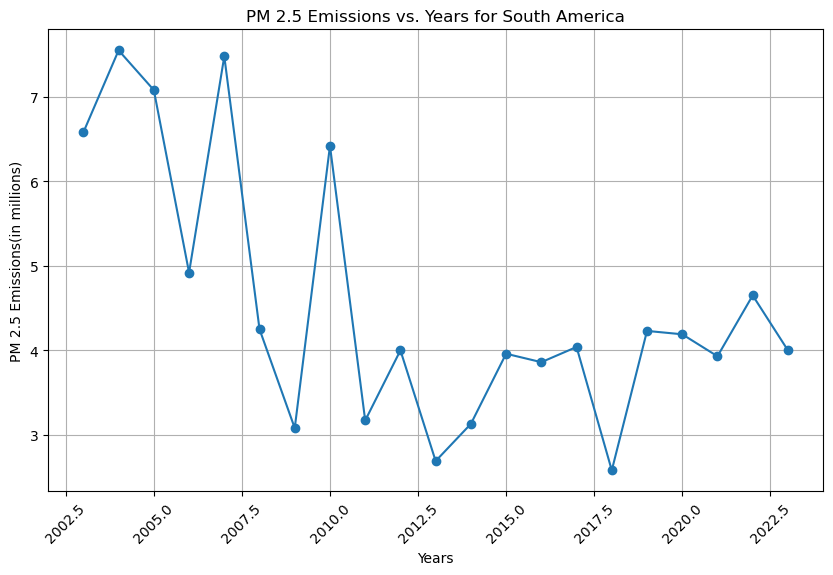

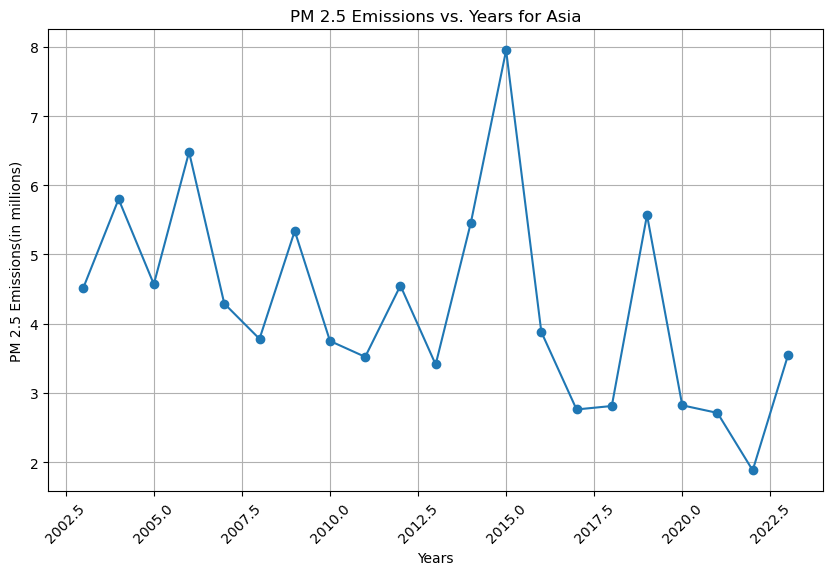

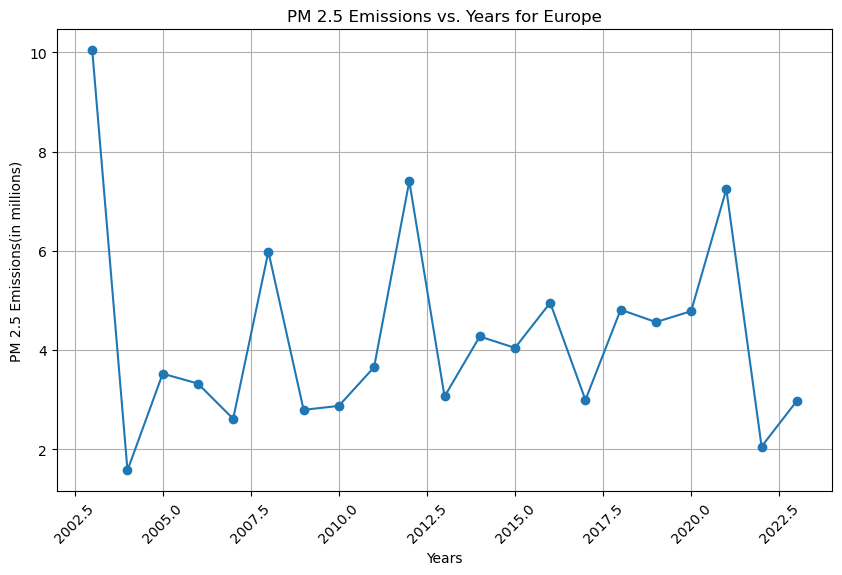

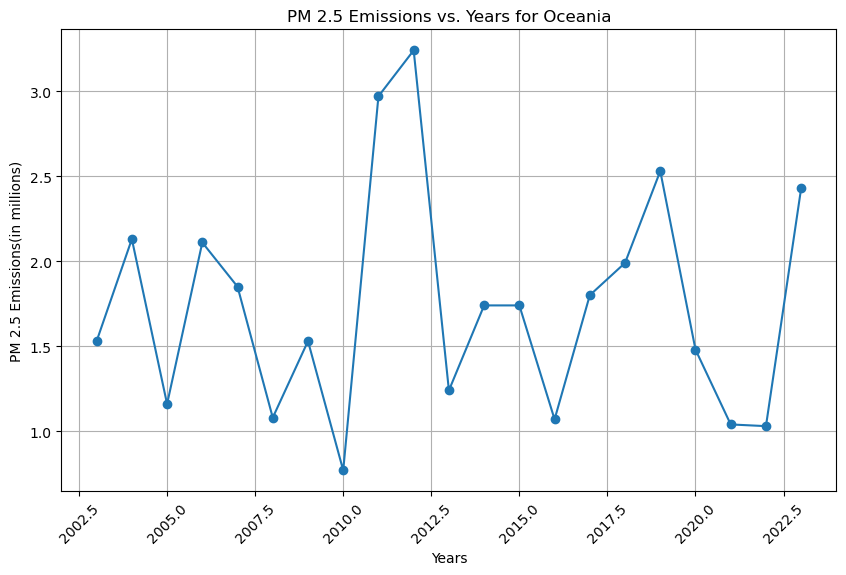

In [81]:

# Plotting PM 2.5 emissions for each continent
for continent, df_pm25_emissions_by_continent in filtered_pm25_Emissions_by_continent.items():
    years = df_pm25_emissions_by_continent.columns[2:]
    emissions = df_pm25_emissions_by_continent.iloc[0, 2:].values.astype(float)  # Extracting emissions data
    plt.figure(figsize=(10, 6))
    plt.plot(years, emissions, marker='o', linestyle='-')
    plt.title(f'PM 2.5 Emissions vs. Years for {continent}')
    plt.xlabel('Years')
    plt.ylabel('PM 2.5 Emissions(in millions)')
    plt.grid(True)
    plt.xticks(rotation=45)  
    plt.show()


# Comparison of PM 2.5 Emissions Across Continents Over Time

This plot illustrates the variation in PM 2.5 emissions over time across different continents. Each line represents the trend of PM 2.5 emissions for a specific continent, with markers indicating data points for individual years. The x-axis represents the years, while the y-axis represents the PM 2.5 emissions. The legend identifies each continent's data.


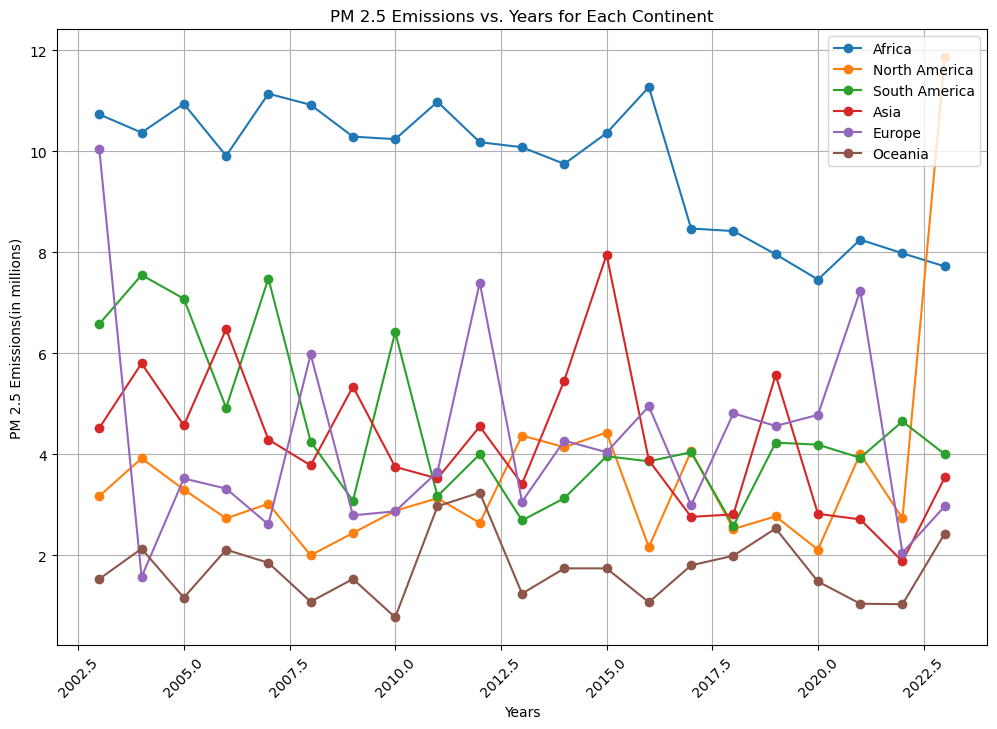

In [82]:

# Create a figure to hold all the plots
plt.figure(figsize=(12, 8))

# Plotting PM 2.5 emissions for each continent
for continent, df_pm25_emissions_by_continent in filtered_pm25_Emissions_by_continent.items():
    years = df_pm25_emissions_by_continent.columns[2:]
    emissions = df_pm25_emissions_by_continent.iloc[0, 2:].values.astype(float)  # Extracting emissions data
    plt.plot(years, emissions, marker='o', linestyle='-', label=continent)

plt.title('PM 2.5 Emissions vs. Years for Each Continent')
plt.xlabel('Years')
plt.ylabel('PM 2.5 Emissions(in millions)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.show()


## Area Burnt vs PM2.5 Emissions

In [83]:

correlation_coefficient = np.corrcoef(Avg_Wildfire_Area_Burnt_btw_2012_and_2023,filtered_pm25_Emissons_in_year_rang_df )[0, 1]
print(f'Correlation coefficient: {correlation_coefficient:.2f}')

Correlation coefficient: 0.65


A correlation coefficient of 0.65 shows a fairly strong link between two variables, indicating that usually when one goes up, so does the other, but not always exactly. However, a 0.65 correlation doesn’t necessarily mean that more area burnt directly leads to higher levels of PM2.5 emissions. There might be other factors that affect both the area burnt and PM2.5 levels.

### Linear Regression Analysis

Linear regression is a statistical method used to model the relationship between a dependent variable (also known as the response or outcome variable) and one or more independent variables (also known as predictor or explanatory variables). It assumes a linear relationship between the variables, meaning that changes in the independent variable(s) are associated with changes in the dependent variable in a linear manner.

### stats.linregress Function

The `stats.linregress` function, part of the `scipy.stats` module, performs simple linear regression analysis. Here's an explanation of its components:

- **slope**: Represents the slope of the regression line, indicating the rate of change of the dependent variable (y) with respect to the independent variable (x). It shows how much y changes for a one-unit increase in x.

- **intercept**: Represents the y-intercept of the regression line, indicating the value of the dependent variable (y) when the independent variable (x) is zero.

- **r_value**: Represents the correlation coefficient (r) between the two variables. It measures the strength and direction of the linear relationship between x and y. The value ranges from -1 to 1, where 1 indicates a perfect positive correlation, -1 indicates a perfect negative correlation, and 0 indicates no correlation.

- **p_value**: Represents the two-sided p-value for a hypothesis test whose null hypothesis is that the slope is zero, indicating no relationship between the variables. A small p-value suggests that the observed relationship is statistically significant.

- **std_err**: Represents the standard error of the estimated slope, providing a measure of the uncertainty or variability in the slope estimate.

#### Linear Function

The linear function derived from the linear regression analysis can be expressed as:
\[
y = mx + b
\]


In [84]:
# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(Avg_Wildfire_Area_Burnt_btw_2012_and_2023, filtered_pm25_Emissons_in_year_rang_df)

# Display the linear function
print(f'Linear function: y = {slope:.2f}x + {intercept:.2f}')


Linear function: y = 0.51x + -1.19


The linear function derived from the linear regression analysis can be expressed as:

\[
y = 0.51x - 1.19
\]

This equation describes the relationship between the area burnt by wildfires \( x \) and PM2.5 emissions \( y \) over the years 2012 to 2023, providing insight into how changes in the area burnt may affect PM2.5 levels.

In [85]:
# import numpy as np
# import pandas as pd
# from scipy import stats

# # Convert data to numpy arrays
# x_data = np.array(Avg_Wildfire_Area_Burnt_btw_2012_and_2023)
# y_data = np.array(filtered_pm25_Emissons_in_year_rang_df)

# # Perform linear regression
# slope, intercept, r_value, p_value, std_err = stats.linregress(x_data, y_data)

# # Display the linear function
# print(f'Linear function: y = {slope:.2f}x + {intercept:.2f}')
# print(f'Correlation coefficient: {r_value:.2f}')


In [86]:
# import pymc3 as pm
# import arviz as az

# # Define the model with adjusted priors and initialization
# with pm.Model() as normal_regression_model:
#     # Priors for unknown model parameters
#     alpha = pm.Normal('alpha', mu=0, sigma=10)
#     beta = pm.Normal('beta', mu=0, sigma=10)
#     sigma = pm.HalfNormal('sigma', sigma=1)

#     # Expected value of the outcome
#     mu = alpha + beta * x_data

#     # Likelihood (sampling distribution) of observations
#     Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y_data)

#     # Posterior sampling with improved tuning settings
#     trace = pm.sample(1000, tune=2000, cores=1, chains=2, init='adapt_full')

# # Plot trace and summary statistics
# az.plot_trace(trace)
# az.summary(trace)


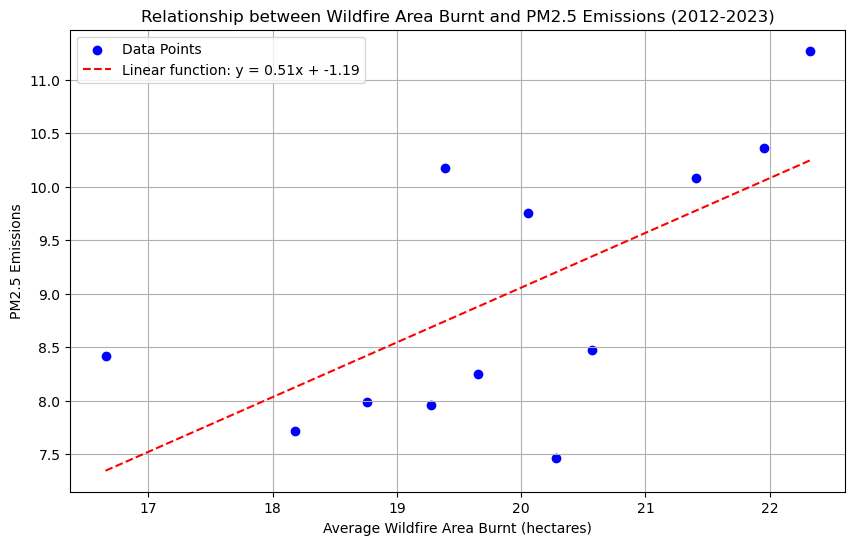

In [87]:

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(Avg_Wildfire_Area_Burnt_btw_2012_and_2023, filtered_pm25_Emissons_in_year_rang_df, color='blue', label='Data Points')

# Adding labels and title
plt.xlabel('Average Wildfire Area Burnt (hectares)')
plt.ylabel('PM2.5 Emissions')
plt.title('Relationship between Wildfire Area Burnt and PM2.5 Emissions (2012-2023)')

# Linear function line based on the given equation
# Define the x range based on your data
x_values = np.linspace(min(Avg_Wildfire_Area_Burnt_btw_2012_and_2023), max(Avg_Wildfire_Area_Burnt_btw_2012_and_2023), 100)
y_values = slope * x_values + intercept # Linear equation

# Plot the line
plt.plot(x_values, y_values, "r--", label=f'Linear function: y = {slope:.2f}x + {intercept:.2f}')

# Adding legend
plt.legend()

# Show the plot with grid
plt.grid(True)
plt.show()


Below, Bayesian linear regression was used to model the relationship between PM2.5 emissions (y_data) and the area burnt by wildfires (x_data) over the years 2012 to 2023. We set up a probabilistic model using PyMC (pm.Model()), where prior distributions for the regression parameters were defined: alpha (intercept) and beta (slope) were given uniform distributions based on calculated limits from the data, and sigma (the error term's standard deviation) followed a Half-Normal distribution. Within this Bayesian framework, a linear regression equation (mu = alpha + beta * x_data) was constructed, and a normal likelihood function for observing the data was specified, integrating our model with the actual PM2.5 emissions. Posterior sampling was performed using Markov Chain Monte Carlo (MCMC) to generate probable values for the unknown parameters (alpha, beta, sigma), and the distribution of these parameters was visualized using ArviZ's plotting functions to assess the convergence and variability of our model's estimates.

/Users/saipranath/anaconda3/lib/python3.10/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/saipranath/anaconda3/lib/python3.10/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, beta, alpha]


/Users/saipranath/anaconda3/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 2 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/saipranath/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


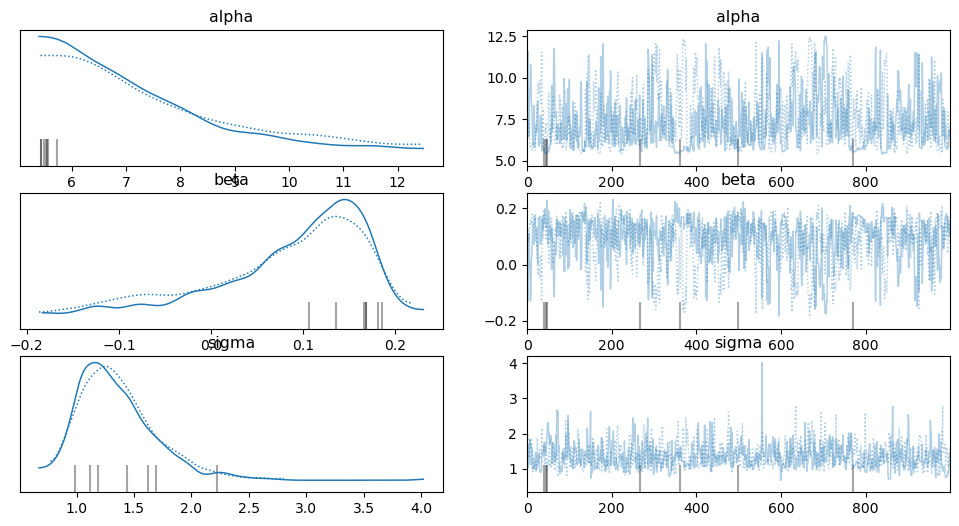

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/saipranath/anaconda3/lib/python3.10/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  7.371  1.643   5.418   10.642      0.111    0.079     186.0     281.0   
beta   0.084  0.084  -0.092    0.204      0.006    0.004     219.0     381.0   
sigma  1.358  0.341   0.840    2.016      0.014    0.010     548.0     577.0   

       r_hat  
alpha   1.01  
beta    1.01  
sigma   1.00

In [88]:

x_data = np.array(Avg_Wildfire_Area_Burnt_btw_2012_and_2023)  # Predictor variable
y_data = np.array(filtered_pm25_Emissons_in_year_rang_df)   # Response variable 

alpha_lower = y_data.mean() - 3 * y_data.std()
alpha_upper = y_data.mean() + 3 * y_data.std()

beta_lower = -3 * np.abs(y_data / x_data).max()
beta_upper = 3 * np.abs(y_data / x_data).max()


with pm.Model() as normal_regression_model:
    # Priors for unknown model parameters using Uniform distribution
    alpha = pm.Uniform('alpha', lower=alpha_lower, upper=alpha_upper)
    beta = pm.Uniform('beta', lower=beta_lower, upper=beta_upper)
    
    # Standard deviation still uses a HalfNormal
    sigma = pm.HalfNormal('sigma', sigma=10)

    # Linear regression model
    mu = alpha + beta * x_data

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y_data)

    # Posterior sampling
    trace = pm.sample(1000,tune=2000, cores=1, chains=2, init='adapt_full')

# Inspecting the trace with ArviZ
az.plot_trace(trace)
plt.show()
az.summary(trace)

7.37050393809434 0.08416505686552253


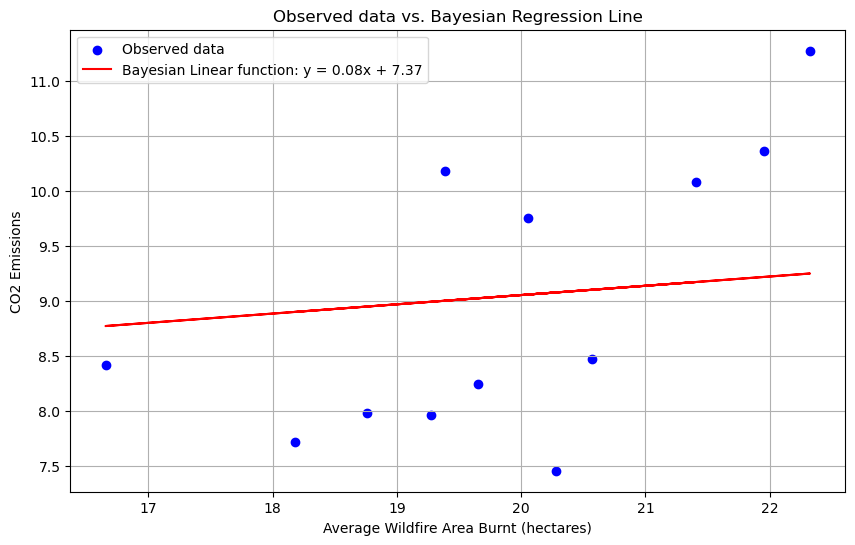

Bayesian Linear function: y = 0.08x + 7.37


In [89]:
# Extract the mean of the posterior for alpha and beta
alpha_mean = np.mean(trace['alpha'])
beta_mean = np.mean(trace['beta'])
print(alpha_mean, beta_mean )
# Generate predictions for the regression line
y_pred = alpha_mean + beta_mean * x_data
y_pred_pymc = y_pred
# Plot the observed data
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, color='blue', label='Observed data')

# Plot the regression line
plt.plot(x_data, y_pred, color='red', label=f'Bayesian Linear function: y = {beta_mean:.2f}x + {alpha_mean:.2f}')

# Add title and labels
plt.title('Observed data vs. Bayesian Regression Line')
plt.xlabel('Average Wildfire Area Burnt (hectares)')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.grid(True)
plt.show()

# Display the linear function
print(f'Bayesian Linear function: y = {beta_mean:.2f}x + {alpha_mean:.2f}')


In [90]:
# from scipy import stats

# # Perform linear regression
# slope, intercept, r_value, p_value, std_err = stats.linregress(Avg_Wildfire_Area_Burnt_btw_2012_and_2023, filtered_pm25_Emissons_in_year_rang_df)
# y_pred_linregress = intercept + slope * x_data
# # Display the linear function
# print(f'Linear function: y = {slope:.2f}x + {intercept:.2f}')
# #

In [91]:

# # Create a scatter plot
# plt.figure(figsize=(10, 6))
# plt.scatter(Avg_Wildfire_Area_Burnt_btw_2012_and_2023, filtered_pm25_Emissons_in_year_rang_df, color='blue', label='Data Points')

# # Adding labels and title
# plt.xlabel('Average Wildfire Area Burnt (hectares)')
# plt.ylabel('PM2.5 Emissions')
# plt.title('Observed data vs. Linear Regression Line')

# x_values = np.linspace(min(Avg_Wildfire_Area_Burnt_btw_2012_and_2023), max(Avg_Wildfire_Area_Burnt_btw_2012_and_2023), 100)

# y_values = slope * x_values +intercept  # Linear equation

# # Plot the line
# plt.plot(x_values, y_values, "r--", label=f'Linear function: y = {slope:.2f}x + {intercept:.2f}')

# # Adding legend
# plt.legend()

# # Show the plot with grid
# plt.grid(True)
# plt.show()


### Mean Squared Error (MSE)

Mean Squared Error (MSE) calculates the average squared difference between the actual values (\( y_data \)) and the predicted values (\( y_pred_pymc \)). It quantifies the average squared distance between the predicted and actual values, with lower values indicating better model performance.

### Root Mean Squared Error (RMSE)

Root Mean Squared Error (RMSE) is the square root of the MSE. It represents the average magnitude of the residuals between predicted and actual values, providing a more interpretable measure of error compared to MSE.

### R-squared (R2)

R-squared (R2) is a statistical measure that represents the proportion of the variance in the dependent variable (\( y_{\text{data}} \)) that is explained by the independent variable(s) (\( x_{\text{data}} \)) in the model. It ranges from 0 to 1, with higher values indicating a better fit of the model to the data.

### Mean Absolute Error (MAE)

Mean Absolute Error (MAE) calculates the average absolute difference between the actual values and the predicted values. It measures the average magnitude of errors in a set of predictions, providing another way to assess the model's performance.


These metrics provide valuable insights into the accuracy and reliability of the linear regression models in predicting PM2.5 emissions based on the area burnt by wildfires.


In [92]:
from sklearn.metrics import mean_squared_error

mse_1 = mean_squared_error(y_data, y_pred_pymc)
print(y_pred_pymc)
mse_2 = mean_squared_error(y_data, y_pred_linregress)
print(y_pred_linregress)

rmse_1 = np.sqrt(mse_1)
rmse_2 = np.sqrt(mse_2)

from sklearn.metrics import r2_score

r2_1 = r2_score(y_data, y_pred_pymc)
r2_2 = r2_score(y_data, y_pred_linregress)

from sklearn.metrics import mean_absolute_error

mae_1 = mean_absolute_error(y_data, y_pred_pymc)
mae_2 = mean_absolute_error(y_data, y_pred_linregress)




[9.00211931 9.17191915 9.05812559 9.21830888 9.249429   9.10192553
 8.77228401 8.99247401 9.07769223 9.0247656  8.94920784 8.90060206]
[2640.76069974 2936.31744247 2738.24626516 3017.06427081 3071.2325316
 2814.48526238 2240.70509346 2623.97189654 2772.3043159  2680.17924393
 2548.66199764 2464.05788036]


In [93]:
print(f"Function 1 - RMSE: {rmse_1}, R-squared: {r2_1}, MAE: {mae_1}")
print(f"Function 2 - RMSE: {rmse_2}, R-squared: {r2_2}, MAE: {mae_2}")

# Decide based on comparison
if rmse_1 < rmse_2 and r2_1 > r2_2:
    print("Function 1 fits better.")
elif rmse_2 < rmse_1 and r2_2 > r2_1:
    print("Function 2 fits better.")
else:
    print("Results are inconclusive or mixed; consider additional analysis.")


Function 1 - RMSE: 1.1265171332349635, R-squared: 0.12733696961740448, MAE: 1.0417892785111873
Function 2 - RMSE: 2712.6816890876935, R-squared: -5060210.23978837, MAE: 2703.3404061666665
Function 1 fits better.


### Conclusion

Our review points to the Bayesian regression model as the better choice for predicting PM2.5 emissions from wildfires, even though it doesn't match the traditional regression model in statistical accuracy(mean square erro, r2 score). This is because the Bayesian model avoids predicting impossible negative PM2.5 values, making it more realistic and useful for making decisions and planning policies.

This model clearly shows that as more area burns, PM2.5 emissions increase. Although the data suggests that reducing the area that burns could also lower emissions, we must remember that the connection between area burnt and PM2.5 isn't perfect(Correlation : 0.65). Other factors also play a role in PM2.5 emissions.

In future models, we aim to include more factors like fire intensity, weather conditions, and how long the fire burns. By considering these additional elements, we can better understand and predict the effects of wildfires on PM2.5 emissions. This will help in creating more effective strategies to manage wildfires and reduce their impact on climate change.


In [94]:
# import statsmodels.api as sm

# # Add a constant to the input data to include the intercept in the model
# x_with_const = sm.add_constant(Avg_Wildfire_Area_Burnt_btw_2012_and_2023)

# # Create a model and fit it
# model = sm.OLS(filtered_pm25_Emissons_in_year_rang_df, x_with_const)
# results = model.fit()

# # Print the summary of the regression
# print(results.summary())


In [95]:

# # Create a scatter plot
# plt.figure(figsize=(10, 6))
# plt.scatter(Avg_Wildfire_Area_Burnt_btw_2012_and_2023, filtered_Co2_Emissions_btw_2012_and_2023_df, color='blue', label='Data Points')

# # Adding labels and title
# plt.xlabel('Average Wildfire Area Burnt (hectares)')
# plt.ylabel('PM2.5 Emissions')
# plt.title('Relationship between Wildfire Area Burnt and PM2.5 Emissions (2012-2023)')

# # Linear function line based on the given equation
# # Define the x range based on your data
# x_values = np.linspace(min(Avg_Wildfire_Area_Burnt_btw_2012_and_2023), max(Avg_Wildfire_Area_Burnt_btw_2012_and_2023), 100)
# y_values = 213.57 * x_values -1031.29  # Linear equation

# # Plot the line
# plt.plot(x_values, y_values, "r--", label='Linear Fit: $y = 1037290.17x - 7663379.35$')

# # Adding legend
# plt.legend()

# # Show the plot with grid
# plt.grid(True)
# plt.show()


In [96]:

correlation_coefficient = np.corrcoef(filtered_pm25_Emissons_in_year_rang_df,filtered_Co2_Emissions_btw_2012_and_2023_df)[0, 1]
print(f'Correlation coefficient: {correlation_coefficient:.2f}')

Correlation coefficient: 1.00


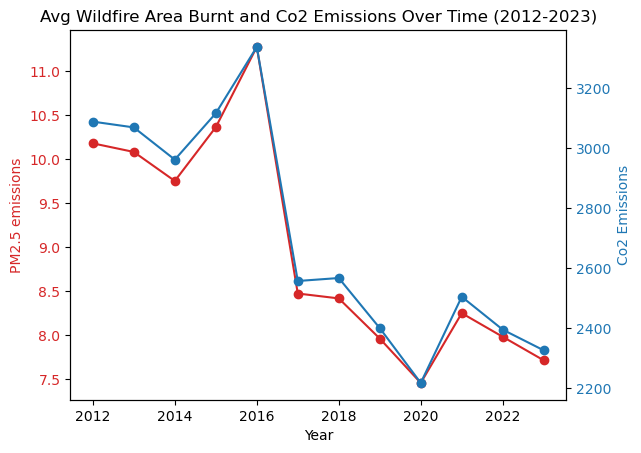

In [97]:
import matplotlib.pyplot as plt


# Create figure and axis objects
fig, ax1 = plt.subplots()

# Plotting the Average Wildfire Area Burnt on the primary y-axis
color = 'tab:red'
ax1.set_xlabel('Year')
ax1.set_ylabel('PM2.5 emissions', color=color)
ax1.plot(year_range, filtered_pm25_Emissons_in_year_rang_df, color=color, marker='o', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the PM2.5 emissions data
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Co2 Emissions', color=color)  # we already handled the x-label with ax1
ax2.plot(year_range, filtered_Co2_Emissions_btw_2012_and_2023_df, color=color, marker='o', linestyle='-')
ax2.tick_params(axis='y', labelcolor=color)

# Adding a title
plt.title('Avg Wildfire Area Burnt and Co2 Emissions Over Time (2012-2023)')

# Show the plot
plt.show()


In [98]:
# # Perform linear regression
# slope, intercept, r_value, p_value, std_err = stats.linregress(filtered_Co2_Emissions_btw_2012_and_2023_df, filtered_pm25_Emissons_in_year_rang_df)

# # Display the linear function
# print(f'Linear function: y = {slope:.2f}x + {intercept:.2f}')


In [99]:

# # Create a scatter plot
# plt.figure(figsize=(10, 6))
# plt.scatter(filtered_Co2_Emissions_btw_2012_and_2023_df, filtered_pm25_Emissons_in_year_rang_df, color='blue', label='Data Points')

# # Adding labels and title
# plt.xlabel('Co2 Emissions')
# plt.ylabel('PM2.5 Emissions')
# plt.title('Observed data vs. Linear Regression Line')

# x_values = np.linspace(min(filtered_Co2_Emissions_btw_2012_and_2023_df), max(filtered_Co2_Emissions_btw_2012_and_2023_df), 100)

# y_values = slope * x_values +intercept  # Linear equation

# # Plot the line
# plt.plot(x_values, y_values, "r--", label=f'Linear function: y = {slope:.2f}x + {intercept:.2f}')

# # Adding legend
# plt.legend()

# # Show the plot with grid
# plt.grid(True)
# plt.show()


# Area burned by wildfires by land cover type, World

In [100]:
# Load CSV file into a DataFrame
forest = pd.read_csv('data/area-burned-wildfires-by-type.csv')
forest['Yearly burned area across shrublands and grasslands'] /= 10**6
forest['Yearly burned area across savannas'] /= 10**6
forest['Yearly burned area across forests'] /= 10**6
forest['Yearly burned area across croplands'] /= 10**6
forest.head()

Entity Code  Year  \
0  Afghanistan  AFG  2002   
1  Afghanistan  AFG  2003   
2  Afghanistan  AFG  2004   
3  Afghanistan  AFG  2005   
4  Afghanistan  AFG  2006   

   Yearly burned area across shrublands and grasslands  \
0                                           0.018053     
1                                           0.112030     
2                                           0.024557     
3                                           0.010883     
4                                           0.007170     

   Yearly burned area across savannas  Yearly burned area across forests  \
0                            0.000000                                0.0   
1                            0.000000                                0.0   
2                            0.000000                                0.0   
3                            0.000064                                0.0   
4                            0.000064                                0.0   

   Yearly burned area across croplands  
0                             0.014167  
1                             0.021681  
2                             0.004358  
3                             0.001395  
4                             0.009810

In [101]:
world_forest_data = forest[(forest['Entity'] == 'World') & (forest['Code'] == 'OWID_WRL')]
world_forest_data.head()

Entity      Code  Year  \
4851  World  OWID_WRL  2002   
4852  World  OWID_WRL  2003   
4853  World  OWID_WRL  2004   
4854  World  OWID_WRL  2005   
4855  World  OWID_WRL  2006   

      Yearly burned area across shrublands and grasslands  \
4851                                          242.92587     
4852                                          191.12650     
4853                                          223.48029     
4854                                          196.69395     
4855                                          210.65245     

      Yearly burned area across savannas  Yearly burned area across forests  \
4851                           158.60573                          24.417036   
4852                           177.56168                          33.777550   
4853                           162.90482                          35.284390   
4854                           183.63990                          33.586056   
4855                           150.56760                          31.339608   

      Yearly burned area across croplands  
4851                            35.789416  
4852                            33.917016  
4853                            36.734068  
4854                            41.020372  
4855                            36.541216

# Yearly Burned Areas Across Different Land Types

This plot illustrates the yearly burned areas across various land types, including shrublands and grasslands, savannas, forests, and croplands. Each subplot represents the burned area (in hectares) over the years for a specific land type.

- **Yearly burned area across shrublands and grasslands:** This subplot shows the burned area across shrublands and grasslands over time.
- **Yearly burned area across savannas:** Here, the burned area across savannas is depicted annually.
- **Yearly burned area across forests:** The subplot displays the burned area across forests throughout the years.
- **Yearly burned area across croplands:** Lastly, the burned area across croplands is presented on an annual basis.

The x-axis represents the years, while the y-axis indicates the burned area in hectares. Each subplot provides insights into the trends and variations in burned areas across different land types over time.


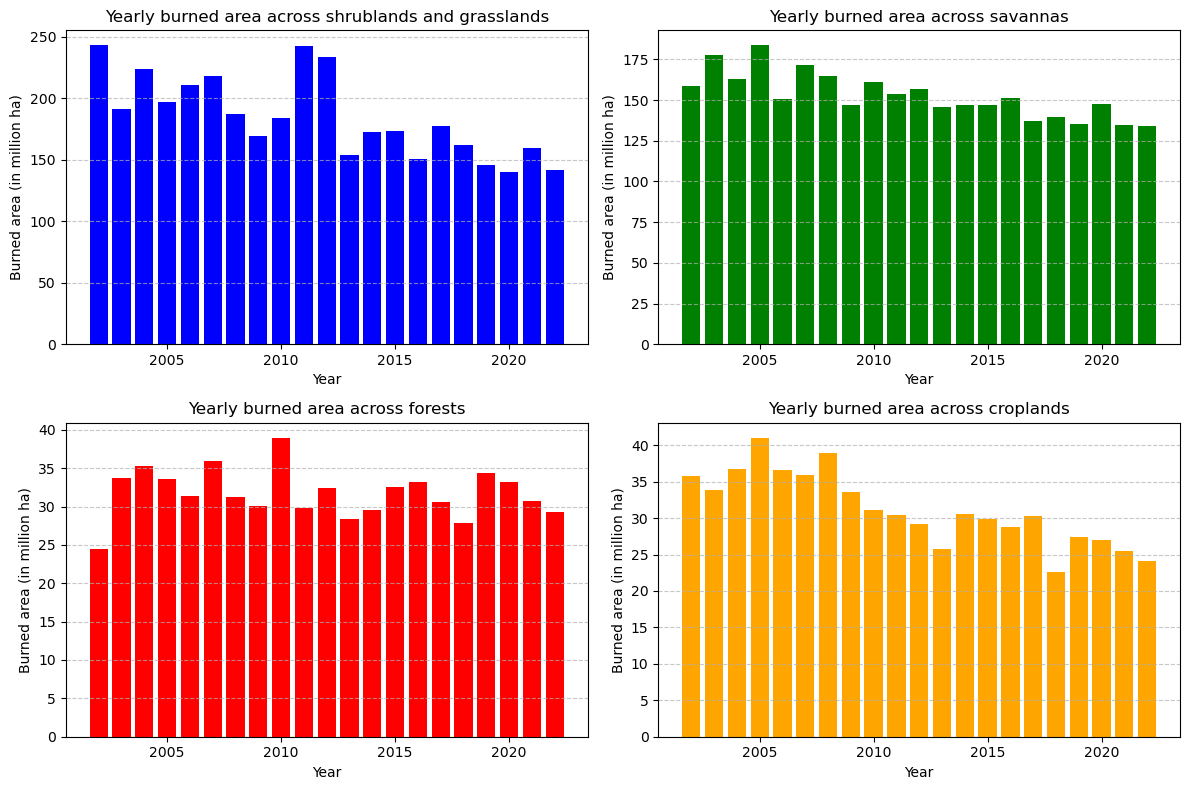

In [102]:

# Extracting data for plotting
years = world_forest_data['Year']
shrublands_grasslands = world_forest_data['Yearly burned area across shrublands and grasslands']
savannas = world_forest_data['Yearly burned area across savannas']
forests = world_forest_data['Yearly burned area across forests']
croplands = world_forest_data['Yearly burned area across croplands']

# Plotting
plt.figure(figsize=(12, 8))

# Plot for Yearly burned area across shrublands and grasslands
plt.subplot(2, 2, 1)
plt.bar(years, shrublands_grasslands, color='b')
plt.title('Yearly burned area across shrublands and grasslands')
plt.xlabel('Year')
plt.ylabel('Burned area (in million ha)')
#plt.yticks(range(0, 200000000 + 50000000, 50000000))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot for Yearly burned area across savannas
plt.subplot(2, 2, 2)
plt.bar(years, savannas, color='g')
plt.title('Yearly burned area across savannas')
plt.xlabel('Year')
plt.ylabel('Burned area (in million ha)')
#plt.yticks(range(0, 200000000+ 50000000, 50000000))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot for Yearly burned area across forests
plt.subplot(2, 2, 3)
plt.bar(years, forests, color='r')
plt.title('Yearly burned area across forests')
plt.xlabel('Year')
plt.ylabel('Burned area (in million ha)')
#plt.yticks(range(0, 200000000 + 50000000, 50000000))
#plt.yticks(range(0, 50000000 + 5000000, 25000000))
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Plot for Yearly burned area across croplands
plt.subplot(2, 2, 4)
plt.bar(years, croplands, color='orange')
plt.title('Yearly burned area across croplands')
plt.xlabel('Year')
plt.ylabel('Burned area (in million ha)')
#plt.yticks(range(0, 50000000 + 5000000, 25000000))
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# Wildfire area burned by land cover type, 2002 to 2022

In [103]:
# Load CSV file into a DataFrame
land = pd.read_csv('data/annual-burned-area-by-landcover.csv')
land['Yearly burned area across shrublands and grasslands'] /= 10**6
land['Yearly burned area across savannas'] /= 10**6
land['Yearly burned area across forests'] /= 10**6
land['Yearly burned area across croplands'] /= 10**6
land['Yearly burned area across other land categories'] /= 10**6
land.head()

Entity Code  Year  Yearly burned area across other land categories  \
0  Afghanistan  AFG  2002                                         0.000000   
1  Afghanistan  AFG  2003                                         0.001309   
2  Afghanistan  AFG  2004                                         0.000408   
3  Afghanistan  AFG  2005                                         0.000086   
4  Afghanistan  AFG  2006                                         0.001116   

   Yearly burned area across croplands  Yearly burned area across forests  \
0                             0.014167                                0.0   
1                             0.021681                                0.0   
2                             0.004358                                0.0   
3                             0.001395                                0.0   
4                             0.009810                                0.0   

   Yearly burned area across savannas  \
0                            0.000000   
1                            0.000000   
2                            0.000000   
3                            0.000064   
4                            0.000064   

   Yearly burned area across shrublands and grasslands  
0                                           0.018053    
1                                           0.112030    
2                                           0.024557    
3                                           0.010883    
4                                           0.007170

In [104]:
world_land_data = land[(land['Entity'] == 'World') & (land['Code'] == 'OWID_WRL')]
world_land_data.head()

Entity      Code  Year  Yearly burned area across other land categories  \
4851  World  OWID_WRL  2002                                         0.920907   
4852  World  OWID_WRL  2003                                         0.953664   
4853  World  OWID_WRL  2004                                         1.019178   
4854  World  OWID_WRL  2005                                         1.557241   
4855  World  OWID_WRL  2006                                         1.230681   

      Yearly burned area across croplands  Yearly burned area across forests  \
4851                            35.789416                          24.417036   
4852                            33.917016                          33.777550   
4853                            36.734068                          35.284390   
4854                            41.020372                          33.586056   
4855                            36.541216                          31.339608   

      Yearly burned area across savannas  \
4851                           158.60573   
4852                           177.56168   
4853                           162.90482   
4854                           183.63990   
4855                           150.56760   

      Yearly burned area across shrublands and grasslands  
4851                                          242.92587    
4852                                          191.12650    
4853                                          223.48029    
4854                                          196.69395    
4855                                          210.65245

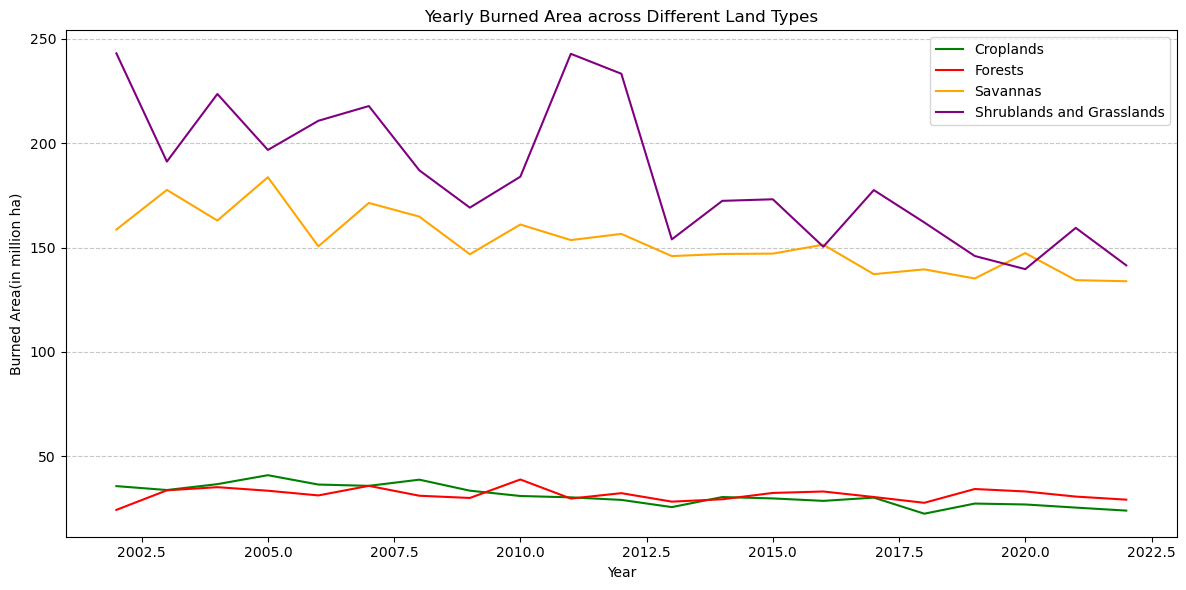

In [105]:


# Extracting data for plotting
years = world_land_data['Year']
other_land = world_land_data['Yearly burned area across other land categories']
croplands = world_land_data['Yearly burned area across croplands']
forests = world_land_data['Yearly burned area across forests']
savannas = world_land_data['Yearly burned area across savannas']
shrublands_grasslands = world_land_data['Yearly burned area across shrublands and grasslands']

# Plotting
plt.figure(figsize=(12, 6))

plt.plot(years, croplands, label='Croplands', color='green')
plt.plot(years, forests, label='Forests', color='red')
plt.plot(years, savannas, label='Savannas', color='orange')
plt.plot(years, shrublands_grasslands, label='Shrublands and Grasslands', color='purple')

plt.title('Yearly Burned Area across Different Land Types')
plt.xlabel('Year')
plt.ylabel('Burned Area(in million ha)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()



The above line plot illustrates the yearly burned area across various land types, including croplands, forests, savannas, and shrublands/grasslands. Each line represents the burned area (in hectares) over the years for a specific land type.

- **Croplands:** The green line depicts the yearly burned area across croplands.
- **Forests:** The red line represents the burned area across forests annually.
- **Savannas:** The orange line shows the burned area across savannas over time.
- **Shrublands and Grasslands:** The purple line indicates the burned area across shrublands and grasslands throughout the years.

The x-axis represents the years, while the y-axis indicates the burned area in hectares. This plot provides insights into the trends and variations in burned areas across different land types over time.


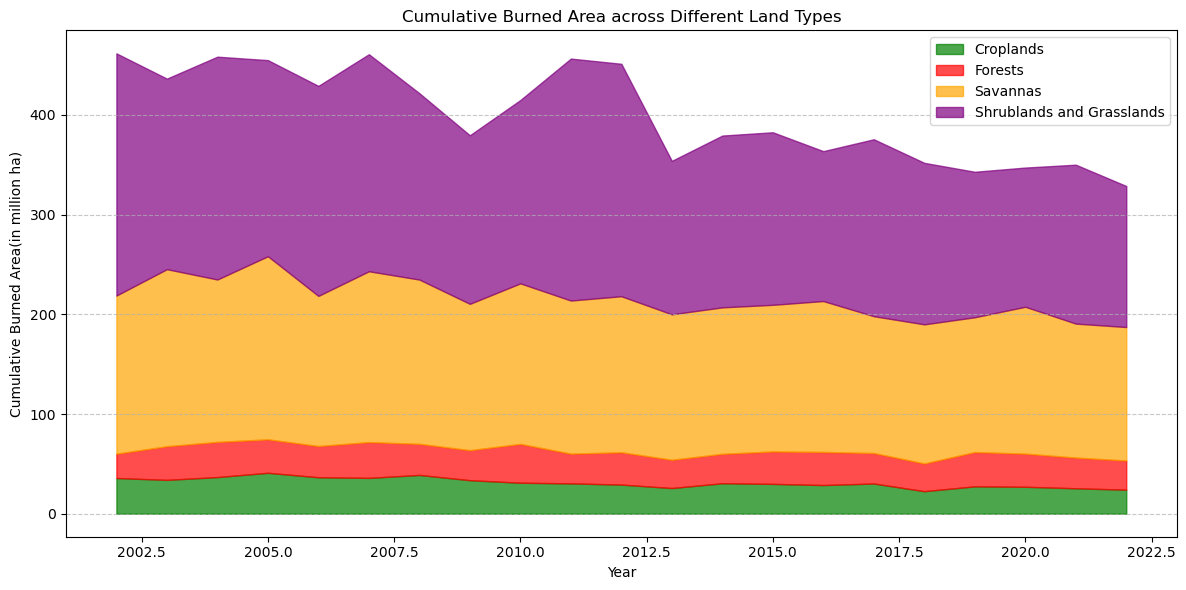

In [106]:


# Extracting data for plotting
years = world_land_data['Year']
croplands = world_land_data['Yearly burned area across croplands']
forests = world_land_data['Yearly burned area across forests']
savannas = world_land_data['Yearly burned area across savannas']
shrublands_grasslands = world_land_data['Yearly burned area across shrublands and grasslands']

# Plotting
plt.figure(figsize=(12, 6))

plt.fill_between(years, croplands, label='Croplands', color='green', alpha=0.7)
plt.fill_between(years, croplands, croplands + forests, label='Forests', color='red', alpha=0.7)
plt.fill_between(years, croplands + forests, croplands + forests + savannas, label='Savannas', color='orange', alpha=0.7)
plt.fill_between(years, croplands + forests + savannas, croplands + forests + savannas + shrublands_grasslands, label='Shrublands and Grasslands', color='purple', alpha=0.7)

plt.title('Cumulative Burned Area across Different Land Types')
plt.xlabel('Year')
plt.ylabel('Cumulative Burned Area(in million ha)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


This filled area plot illustrates the cumulative burned area across various land types over the years. Each filled area represents the cumulative burned area (in hectares) for a specific land type.

### Filtering data for below 6 continents

In [107]:

continents = [
    'Africa', 
    'North America', 
    'South America',  
    'Asia', 
    'Europe', 
    'Oceania' 
]


year_range = range(2012, 2024)

# Dictionaries to hold filtered data
filtered_area_burnt_type_by_continent = {}

# Filtering data for each continent and year range
for continent in continents:
    # Filter Area Burnt
    continent_area_burnt = forest[
        (forest['Entity'] == continent) 
#         & 
#         (df['Year'].isin(year_range)
#         )
    ]
    filtered_area_burnt_type_by_continent[continent] = continent_area_burnt

# Now print the filtered datasets for the first continent as an example
# continent = continents[0]  # Change this index for other continents
# print(f"{continent} Area Burnt:")
# print(filtered_area_burnt_by_continent[continent].head())
# print(f"{continent} CO2 Emissions:")
# print(filtered_Co2_Emissions_by_continent[continent].head())
# print(f"{continent} PM2.5 Emissions:")
# print(filtered_pm25_Emissions_by_continent[continent].head())


# Yearly Burned Area Across Continents and Land Types

This multi-plot visualization displays the yearly burned area across different land types for various continents. Each subplot represents a continent, and within each subplot, the yearly burned area (in hectares) for different land types is plotted against the years.

- **Continents:** The visualization covers six continents: Africa, North America, South America, Asia, Europe, and Oceania.

- **Land Types:** The land types include yearly burned areas across shrublands and grasslands, savannas, forests, and croplands.

Each line plot within a subplot represents a specific land type, showcasing its yearly burned area trend over the years. The x-axis represents the years, while the y-axis indicates the burned area in hectares.

This visualization provides insights into how the yearly burned area varies across different land types within each continent over time.


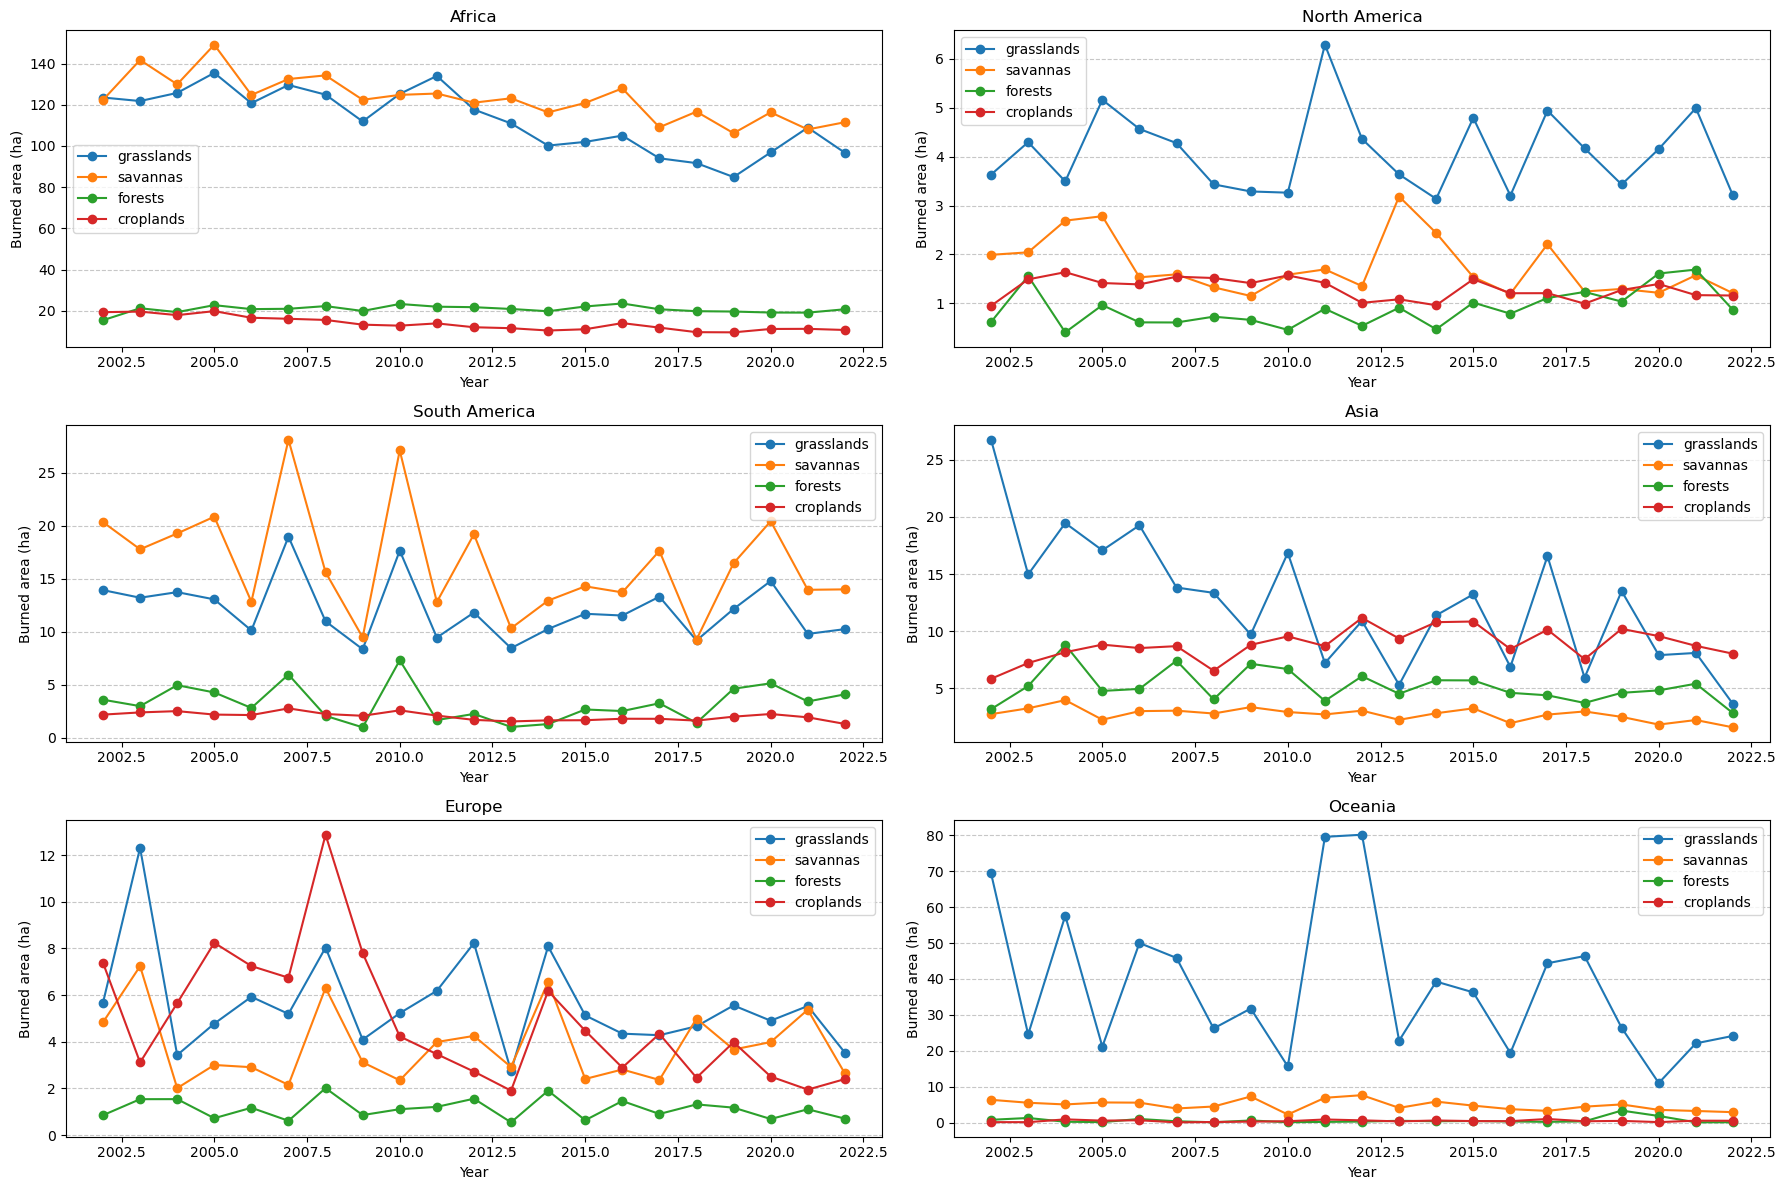

In [108]:

# Continents and land types
continents = [
    'Africa', 
    'North America', 
    'South America',  
    'Asia', 
    'Europe', 
    'Oceania' 
]

land_types = [
    'Yearly burned area across shrublands and grasslands',
    'Yearly burned area across savannas',
    'Yearly burned area across forests',
    'Yearly burned area across croplands'
]

# Plotting
plt.figure(figsize=(18, 12))

# Loop through each continent
for i, continent in enumerate(continents, 1):
    plt.subplot(3, 2, i)
    plt.title(continent)
    plt.xlabel('Year')
    plt.ylabel('Burned area (ha)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Loop through each land type
    for land_type in land_types:
        # Extract data for the current continent and land type
        data = filtered_area_burnt_type_by_continent[continent]
        years = data['Year']
        burned_area = data[land_type]
        
        # Plot
        plt.plot(years, burned_area, label=land_type.split(' ')[-1], marker='o')

    plt.legend()

plt.tight_layout()
plt.show()
